## Reading in packages

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
#import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc
import seaborn as sns
from decimal import Decimal

sns.set_theme()
sns.set(rc={'figure.figsize':(10,10)})
from mpl_toolkits.mplot3d import Axes3D
# Tensorflow related
# import tensorflow as tf
# from tensorflow import keras

# from tensorflow.keras import layers
# from tensorflow.keras import regularizers
# import tensorflow.compat.v2.feature_column as fc

# #!pip install -q git+https://github.com/tensorflow/docs

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots

#print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
from scipy import interp
from sklearn.metrics import roc_curve, auc
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v5

# from utils.models import make_input_fn
# from utils.models import performanceTesting,scoreFunction
# from utils.plotting import plot_confusion_matrix

C:\Users\PC\AppData\Local\Temp\tmp8bftv7vz\tensorboard_logs


## Extracting data

In [125]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec.csv
1: aggregateTAQ_May2020_30sec.csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ticker              sector exchange     marketCap
12    AAPL          Technology      NMS  1.578173e+12
20    ABBV          Healthcare      NYQ  1.742612e+11
34     ABT          Healthcare      NYQ  1.631410e+11
126    AEP           Utilities      NYQ  4.089551e+10
379    AMT         Real Estate      NYQ  1.171259e+11
428    APD     Basic Materials      NYQ  5.464395e+10
697     BA         Industrials      NYQ  1.020356e+11
699   BABA   Consumer Cyclical      NYQ  5.936536e+11
700    BAC  Financial Services      NYQ  2.020550e+11
870    BHP     Basic Materials      NYQ  1.258194e+11

In [20]:
azure_files_path = '../AzureML/Output_from_cloud/2020-12-21'
files = os.listdir(azure_files_path)
files

['hyperparameters_lr_20201221_v3.txt',
 'hyperparameters_nn_20201221_v1.txt',
 'metrics_lr_20201221_v3.txt',
 'metrics_nn_20201221_v1.txt']

In [4]:
# hyperfiles_nn = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('hyper' in i) & ('nn' in i)]
# metricfiles_nn = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('metric' in i) & ('nn' in i)]
hyperfiles_nn = [i for i in os.listdir(azure_files_path) if ('hyper' in i) & ('nn' in i)]
metricfiles_nn = [i for i in os.listdir(azure_files_path) if ('metric' in i) & ('nn' in i)]

In [5]:
hyperfiles_nn

['hyperparameters_nn_20201221_v1.txt']

# Loading Neural Network

## Hyperparameters

In [6]:
### Reading in the file

# with open('../AzureML/Output_from_cloud/'+hyperfiles_nn[-1],'r') as file:
#     content = file.readlines()

with open(azure_files_path+'/'+hyperfiles_nn[-1],'r') as file:
    content = file.readlines()

## Containers for the data
all_ids = []
all_parameters = []

## Going over each line in the text file
for a in np.arange(len(content[0:-1])):
    
    ## Split the lines on tabs
    temp_parameters = re.split('[\t]',content[a])[1]
    
    ## Basic string cleaning, i.e. removing redundant characters
#     test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
#                                                                        .replace('}','')\
#                                                                        .replace('\n','')\
#                                                                        .replace('"',''))]
    test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                       .replace('}','')\
                                                                       .replace('\n','')\
                                                                       .replace('"','')\
                                                                       .replace('--','')
                                                                       .replace('\'',''))]
    
    ## Output of test is a list of lists, where each sublist holds the name of a model variable and its value.
    ## We create a dictornary to hold all model variables, making it easy to add the observation to the dataframe.
    test = {i[0]:i[1] for i in test}
    
    # Constructing the dataframe
    if a == 0:
        parameters = pd.DataFrame(test,index=[re.split('[\t]',content[a])[0]])
    
    else:
        
        parameters.loc[re.split('[\t]',content[a])[0]] = pd.Series(test)

## Metrics

In [7]:
## Readidng in the file
# with open('../AzureML/Output_from_cloud/'+metricfiles_nn[-1],'r') as file:
#     content = file.readlines()

with open(azure_files_path+'/'+metricfiles_nn[-1],'r') as file:
    content = file.readlines()

## Containers
t11 = []
t12 = []
t13 = []

t21 = []
t22 = []
t23 = []

## Going over each line
for i in np.arange(len(content)):#
    
    ## Split each line on tabs
    temp = re.split('\t',content[i].replace('\n',''))
    
    #print(temp)
    
    ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
    ## and 2. a time series of a metric for each model.
    
    ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
    ## It stored separately for the time series.
    if len(temp[2]) < 50:

        t11.append(temp[0])
        t12.append(temp[1])
        t13.append(temp[2])
    
    ## Time series
    else:
    
        container = np.zeros(155)
        temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

        container[0:len(temp1)] = temp1
        container[len(temp1):] = temp1[-1]

        t21.append(temp[0])
        t22.append(temp[1])
        t23.append(container)        

## Storing the time series in a dataframe
arrays = [t21,t22]
tuples = list(zip(*arrays))

runningMetrics = pd.DataFrame(np.array(t23),
                              index=pd.MultiIndex.from_tuples(tuples),
                              columns = [np.arange(155).astype(str)]
                             )
## Storing the final metrics in a dataframe.
arrays = [t11,t12]
tuples = list(zip(*arrays))
finalMetrics = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])

# Attaching the last observation of each model, for each metric, to the parameters of the model

In [8]:
## Resetting indcies and rename columns
runningMetrics = runningMetrics.reset_index().rename(columns={'level_0':'run_id','level_1':'metric'})
runningMetrics.columns = runningMetrics.columns.get_level_values(0)

## Adding a column of short ids, to merge on.
runningMetrics['id'] = [re.split('_',i)[-1] for i in runningMetrics.run_id]

## Creating a table, having the short id in the rows and the last observation for each metric in the columns. 
table = pd.pivot_table(runningMetrics[['run_id','metric','154','id']],index='id',columns=['metric'])
table.columns = table.columns.get_level_values(1)
table = table.round(5).reset_index()

## Preparing the parameter dataframe.
parameters = parameters.reset_index().rename(columns={'index':'run_id'})

## Setting short ID
parameters['id'] = [re.split('_',i)[-1] for i in parameters.run_id]

## Creating the combined table
combined_table = parameters.merge(table,
                                     on = 'id',
                                     how='left').sort_values('AUC',ascending=False)
combined_table

run_id activation-inner  \
690  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_265             tanh   
937   HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_16          sigmoid   
264  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_690          sigmoid   
680  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_274             relu   
213  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_741        leakyrelu   
..                                           ...              ...   
114  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_842        leakyrelu   
398  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_554             tanh   
265  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_686             tanh   
694  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_263             relu   
407  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_548          sigmoid   

    activation-output batch-norm batch-shuffle batch-size dropout-ratio  \
690           softmax          1             1       3300           0.1   
937           softmax          1             0      10725           0.1   
264           softmax          1             1      10725             0   
680           softmax          0             1      21450           0.3   
213           softmax          0             1      10725             0   
..                ...        ...           ...        ...           ...   
114            linear          0             1       3300           0.2   
398            linear          0             0      21450           0.2   
265            linear          0             0       3300             0   
694            linear          0             1      10725           0.1   
407            linear          0             1      10725             0   

    feature-lags featureset first-layer-neurons  ... pastobs-in-percentage  \
690            5          1                  64  ...                     1   
937            3          3                 128  ...                     1   
264            1          3                 128  ...                     1   
680            5          3                  64  ...                     1   
213            1          0                 128  ...                     1   
..           ...        ...                 ...  ...                   ...   
114            5          1                 128  ...                     0   
398            5          0                 128  ...                     1   
265            1          2                  32  ...                     0   
694            3          3                 128  ...                     1   
407            1          3                  32  ...                     0   

    pre-processing second-layer-neurons   id      AUC Accuracy     Loss  \
690            std                   64  265  0.79518  0.61517  0.90243   
937            std                   64   16  0.78352  0.60490  0.92952   
264       quantgau                   64  690  0.78147  0.60463  0.90541   
680            pow                  128  274  0.78059  0.62574  0.87993   
213            std                   32  741  0.77868  0.62748  0.86669   
..             ...                  ...  ...      ...      ...      ...   
114        stacked                  128  842  0.00000  0.44592  0.67319   
398         minmax                   32  554  0.00000  0.21256  1.61055   
265        stacked                  128  686  0.00000  0.55001  0.68814   
694           None                  128  263  0.00000  0.25163  1.05823   
407       quantgau                  128  548  0.00000  0.18745  0.00000   

    Train AUC Train Accuracy  Train Loss  
690   0.79514        0.63969     0.81699  
937   0.78345        0.63285     0.82121  
264   0.78139        0.63891     0.82597  
680   0.78055        0.62047     0.86376  
213   0.77866        0.61201     0.87951  
..        ...            ...         ...  
114   0.00000        0.44535     0.67499  
398   0.00000        0.20827     1.61073  
265   0.00000        0.54646     0.68959  
694   0.00000        0.24629     1.05837  
4

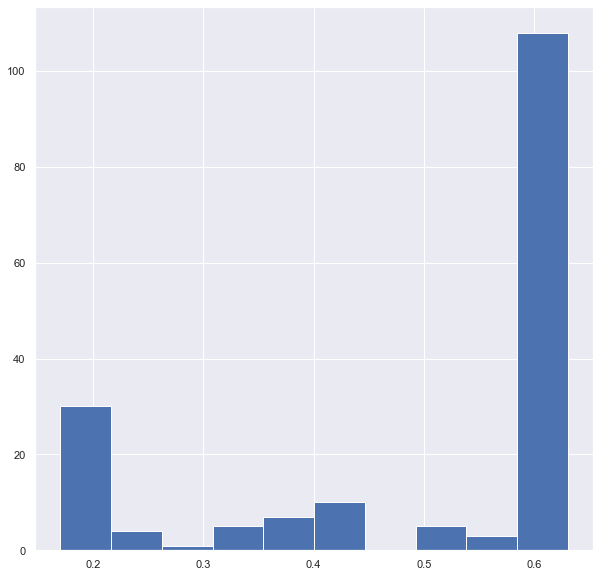

In [9]:
runningMetrics[(runningMetrics.metric=='Accuracy')&\
               (np.isin(runningMetrics.id,parameters[parameters['label-type']=='2'].id.values))].sort_values('154')['154'].hist()

In [10]:
## Creating a top-X table for each label-type of a given metric, here AUC.
temp_auc = pd.pivot_table(combined_table[['label-type','AUC','id']],index='id',columns='label-type')
temp_acc = pd.pivot_table(combined_table[['label-type','Accuracy','id']],index='id',columns='label-type')

## Final output - AUC
final_output_auc = pd.DataFrame(np.sort(temp_auc.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_auc.columns.get_level_values(1)).loc[0:10]
## Final output - Accuracy
final_output_acc = pd.DataFrame(np.sort(temp_acc.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_acc.columns.get_level_values(1))#.loc[0:10]
# final_output

In [11]:
tempFinal_v0 = combined_table[np.isin(combined_table.AUC,final_output_auc.loc[0].values.flatten())]
tempFinal_v0.index = tempFinal_v0.loc[:,'label-type']
tempFinal_v0

run_id activation-inner  \
label-type                                                                 
2           HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_265             tanh   
4           HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_203        leakyrelu   
3           HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_129          sigmoid   
1            HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_57             tanh   
0           HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_927             relu   

           activation-output batch-norm batch-shuffle batch-size  \
label-type                                                         
2                    softmax          1             1       3300   
4                    softmax          0             1      21450   
3                    softmax          1             1      21450   
1                    softmax          1             1       3300   
0                    softmax          1             0      21450   

           dropout-ratio feature-lags featureset first-layer-neurons  ...  \
label-type                                                            ...   
2                    0.1            5          1                  64  ...   
4                      0            1          2                  64  ...   
3                      0            1          1                  64  ...   
1                      0            1          3                 128  ...   
0                    0.1            5          1                 128  ...   

           pastobs-in-percentage pre-processing second-layer-neurons   id  \
label-type                                                                  
2                              1            std                   64  265   
4                              1            std                   64  203   
3                              0            pow                  128  129   
1                              0            pow                  128   57   
0                              0       quantgau                  128  927   

                AUC Accuracy     Loss Train AUC Train Accuracy  Train Loss  
label-type                                                                  
2           0.79518  0.61517  0.90243   0.79514        0.63969     0.81699  
4           0.74993  0.42211  1.35455   0.74990        0.43109     1.31745  
3           0.68184  0.26584  1.92156   0.68168        0.46871     1.25441  
1           0.66374  0.41135  1.11319   0.66369        0.51894     0.97454  
0           0.65395  0.53883  0.73130   0.65379        0.68120     0.58972  

[5 rows x 25 columns]

In [12]:
tempFinal_v1 = combined_table[np.isin(combined_table.Accuracy,final_output_acc.loc[0].values.flatten())].sort_values('label-type').copy(deep=True)
tempFinal_v1.index = tempFinal_v1.loc[:,'label-type']
tempFinal_v1

run_id activation-inner  \
label-type                                                                 
0             HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_6        leakyrelu   
1           HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_210          sigmoid   
2           HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_763          sigmoid   
3           HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_519        leakyrelu   
4           HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_383          sigmoid   

           activation-output batch-norm batch-shuffle batch-size  \
label-type                                                         
0                    softmax          0             0       3300   
1                     linear          0             1       3300   
2                    softmax          1             1       3300   
3                    softmax          0             1      10725   
4                    softmax          0             1      10725   

           dropout-ratio feature-lags featureset first-layer-neurons  ...  \
label-type                                                            ...   
0                    0.2            0          2                 128  ...   
1                    0.5            0          3                 128  ...   
2                    0.3            0          3                  32  ...   
3                    0.1            1          2                  64  ...   
4                    0.1            1          2                  64  ...   

           pastobs-in-percentage pre-processing second-layer-neurons   id  \
label-type                                                                  
0                              1            pow                   32    6   
1                              1            pow                   64  210   
2                              0        stacked                   64  763   
3                              0        stacked                   32  519   
4                              0       quantgau                   64  383   

                AUC Accuracy     Loss Train AUC Train Accuracy  Train Loss  
label-type                                                                  
0           0.59536  0.55947  0.67144   0.59535        0.56380     0.67089  
1           0.01173  0.43677  1.04742   0.01087        0.42672     1.05332  
2           0.77054  0.63028  0.85575   0.77050        0.60303     0.89171  
3           0.64863  0.30824  1.50001   0.64861        0.30822     1.50519  
4           0.73661  0.43527  1.32137   0.73658        0.40995     1.36071  

[5 rows x 25 columns]

In [13]:
tempFinal_v0.loc['0']

run_id                   HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_927
activation-inner                                                relu
activation-output                                            softmax
batch-norm                                                         1
batch-shuffle                                                      0
batch-size                                                     21450
dropout-ratio                                                    0.1
feature-lags                                                       5
featureset                                                         1
first-layer-neurons                                              128
label-type                                                         0
learning-rate                                                  0.001
n-epochs                                                         150
n-layers                                                           2
nn-type                           

## Structuring for visualisation

In [14]:
first_step = tempFinal_v0.copy(deep=True).drop(['run_id','n-epochs'],axis=1).sort_index().round({'AUC':3,#'label-type',
                                                                                                              'Accuracy':3,
                                                                                                              'Loss':3,
                                                                                                              'Train AUC':3,
                                                                                                              'Train Accuracy':3,
                                                                                                              'Train Loss':3})

###     First variables for indentification, the data related variables, estimation parameters, model parameters and then performance.
columns_on_top = ['nn-type','id','label-type','featureset','pre-processing','pastobs-in-percentage','feature-lags',
                  'batch-norm','batch-shuffle','batch-size','dropout-ratio','learning-rate','n-layers']
residual = [i for i in first_step.columns if i not in columns_on_top]
correct_ordered = []
correct_ordered += columns_on_top
correct_ordered += residual
# first_step.T.loc[correct_ordered,:]

results_table = first_step.T.loc[correct_ordered,:]

iterables = [['nn'], results_table.columns]

results_table.columns = pd.MultiIndex.from_product(iterables, names=['first', 'second'])

results_table

first                        nn                                      
second                        0        1        2        3          4
nn-type                    ffnn     ffnn     ffnn     ffnn       ffnn
id                          927       57      265      129        203
label-type                    0        1        2        3          4
featureset                    1        3        1        1          2
pre-processing         quantgau      pow      std      pow        std
pastobs-in-percentage         0        0        1        0          1
feature-lags                  5        1        5        1          1
batch-norm                    1        1        1        1          0
batch-shuffle                 0        1        1        1          1
batch-size                21450     3300     3300    21450      21450
dropout-ratio               0.1        0      0.1        0          0
learning-rate             0.001     0.01     0.01     0.01       0.01
n-layers                      2        1        1        4          4
activation-inner           relu     tanh     tanh  sigmoid  leakyrelu
activation-output       softmax  softmax  softmax  softmax    softmax
first-layer-neurons         128      128       64       64         64
second-layer-neurons        128      128       64      128         64
AUC                       0.654    0.664    0.795    0.682       0.75
Accuracy                  0.539    0.411    0.615    0.266      0.422
Loss                      0.731    1.113    0.902    1.922      1.355
Train AUC                 0.654    0.664    0.795    0.682       0.75
Train Accuracy            0.681    0.519     0.64    0.469      0.431
Train Loss                 0.59    0.975    0.817    1.254      1.317

## An example of a box-plot

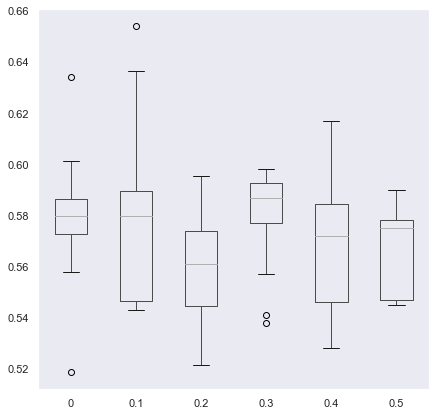

In [15]:
temp = combined_table[(combined_table.loc[:,'label-type']=='0')&\
                      (combined_table.loc[:,'nn-type']=='ffnn')&\
                      (combined_table.AUC>0.5)]
temp_2 = pd.pivot_table(temp,values='AUC',columns='dropout-ratio',index='run_id').reset_index()
temp_2.boxplot(list(temp_2.columns[1:]),figsize=(7,7))#temp_2.columns[2:]
plt.grid(b=None)
plt.show()

In [16]:
cols_not_plot = []
cols_to_plot = []

for i,col in enumerate(temp.columns):
    if (temp.loc[:,col].unique().shape[0]>1)&(temp.loc[:,col].unique().shape[0]<7):
        cols_to_plot.append(col)
        print(col,': ',temp.loc[:,col].unique(),'\n')
    else:
        cols_not_plot.append(col)

activation-inner :  ['relu' 'tanh' 'leakyrelu' 'sigmoid'] 

batch-norm :  ['1' '0'] 

batch-shuffle :  ['0' '1'] 

batch-size :  ['21450' '3300' '10725'] 

dropout-ratio :  ['0.1' '0' '0.4' '0.3' '0.2' '0.5'] 

feature-lags :  ['5' '0' '1' '3'] 

featureset :  ['1' '3' '0' '2'] 

first-layer-neurons :  ['128' '64' '32'] 

learning-rate :  ['0.001' '0.01' '0.1' '0.0001'] 

n-layers :  ['2' '3' '4' '1'] 

pastobs-in-percentage :  ['0' '1'] 

pre-processing :  ['quantgau' 'std' 'pow' 'stacked' 'None' 'minmax'] 

second-layer-neurons :  ['128' '32' '64'] 



In [17]:
len(cols_to_plot)

13

In [18]:
combined_table.columns

Index(['run_id', 'activation-inner', 'activation-output', 'batch-norm',
       'batch-shuffle', 'batch-size', 'dropout-ratio', 'feature-lags',
       'featureset', 'first-layer-neurons', 'label-type', 'learning-rate',
       'n-epochs', 'n-layers', 'nn-type', 'pastobs-in-percentage',
       'pre-processing', 'second-layer-neurons', 'id', 'AUC', 'Accuracy',
       'Loss', 'Train AUC', 'Train Accuracy', 'Train Loss'],
      dtype='object')

In [19]:
combined_table.loc[:,'n-epochs'].unique()

array(['150'], dtype=object)

# Label types

Label type 0: 2 classes - equal split

Label type 1: 3 classes - equal split

Label type 2: 3 classes - non-equal split

Label type 3: 5 classes - equal split

Label type 4: 5 classes - non-equal split

In [20]:
title_holder = {'0':'# of price categories: 2 | Split: 50-50',
                 '1':'# of price categories: 3 | Split: 33-33-33',
                 '2':'# of price categories: 3 | Split: 20-60-20',
                 '3':'# of price categories: 5 | Split: 20-20-20-20-20',
                 '4':'# of price categories: 5 | Split: 10-20-50-20-10'}

In [21]:
# os.mkdir('../../output')

# Feature sets

features_to_use == 0:
    listOfFeatures = [
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime'
                    ]

features_to_use == 1:
    listOfFeatures = [
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'sector'
                    ]

features_to_use == 2:
    listOfFeatures = [
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime',
                        'stok',
                        'stod',
                        'sstod',
                        'roc',
                        'rsi',
                        'atr',
                        'cci',
                        'dpo',
                        'sma',
                        'ema',
                        'macd',
                        'macd_diff',
                        'macd_signal',
                        'dis5',
                        'dis10'
                        ]

features_to_use == 3: 
    listOfFeatures = [
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'stok',
                    'stod',
                    'sstod',
                    'roc',
                    'rsi',
                    'atr',
                    'cci',
                    'dpo',
                    'sma',
                    'ema',
                    'macd',
                    'macd_diff',
                    'macd_signal',
                    'dis5',
                    'dis10',
                    'sector'
                    ]

In [22]:
x1 = pd.DataFrame({'x^1':'\checkmark'},index=[
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime'
                    ])

x2 = pd.DataFrame({'x^2':'\checkmark'},index=[
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'sector'
                    ])

x3 = pd.DataFrame({'x^3':'\checkmark'},index=[
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime',
                        'stok',
                        'stod',
                        'sstod',
                        'roc',
                        'rsi',
                        'atr',
                        'cci',
                        'dpo',
                        'sma',
                        'ema',
                        'macd',
                        'macd_diff',
                        'macd_signal',
                        'dis5',
                        'dis10'
                        ])

x4 = pd.DataFrame({'x^4':'\checkmark'},index=[
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'stok',
                    'stod',
                    'sstod',
                    'roc',
                    'rsi',
                    'atr',
                    'cci',
                    'dpo',
                    'sma',
                    'ema',
                    'macd',
                    'macd_diff',
                    'macd_signal',
                    'dis5',
                    'dis10',
                    'sector'
                    ])

x5 = pd.DataFrame({'Description':''},index=[
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'stok',
                    'stod',
                    'sstod',
                    'roc',
                    'rsi',
                    'atr',
                    'cci',
                    'dpo',
                    'sma',
                    'ema',
                    'macd',
                    'macd_diff',
                    'macd_signal',
                    'dis5',
                    'dis10',
                    'sector'
                    ])

exo_sets = pd.concat([x1,x2,x3,x4,x5],axis=1).fillna('')
exo_sets

x^1         x^2         x^3         x^4 Description
pastobs       \checkmark  \checkmark  \checkmark  \checkmark            
spread        \checkmark  \checkmark  \checkmark  \checkmark            
bidsize       \checkmark  \checkmark  \checkmark  \checkmark            
ofrsize       \checkmark  \checkmark  \checkmark  \checkmark            
pastreturns   \checkmark  \checkmark  \checkmark  \checkmark            
intradaytime  \checkmark  \checkmark  \checkmark  \checkmark            
sector                    \checkmark              \checkmark            
stok                                  \checkmark  \checkmark            
stod                                  \checkmark  \checkmark            
sstod                                 \checkmark  \checkmark            
roc                                   \checkmark  \checkmark            
rsi                                   \checkmark  \checkmark            
atr                                   \checkmark  \checkmark            
cci                                   \checkmark  \checkmark            
dpo                                   \checkmark  \checkmark            
sma                                   \checkmark  \checkmark            
ema                                   \checkmark  \checkmark            
macd                                  \checkmark  \checkmark            
macd_diff                             \checkmark  \checkmark            
macd_signal                           \checkmark  \checkmark            
dis5                                  \checkmark  \checkmark            
dis10                                 \checkmark  \checkmark

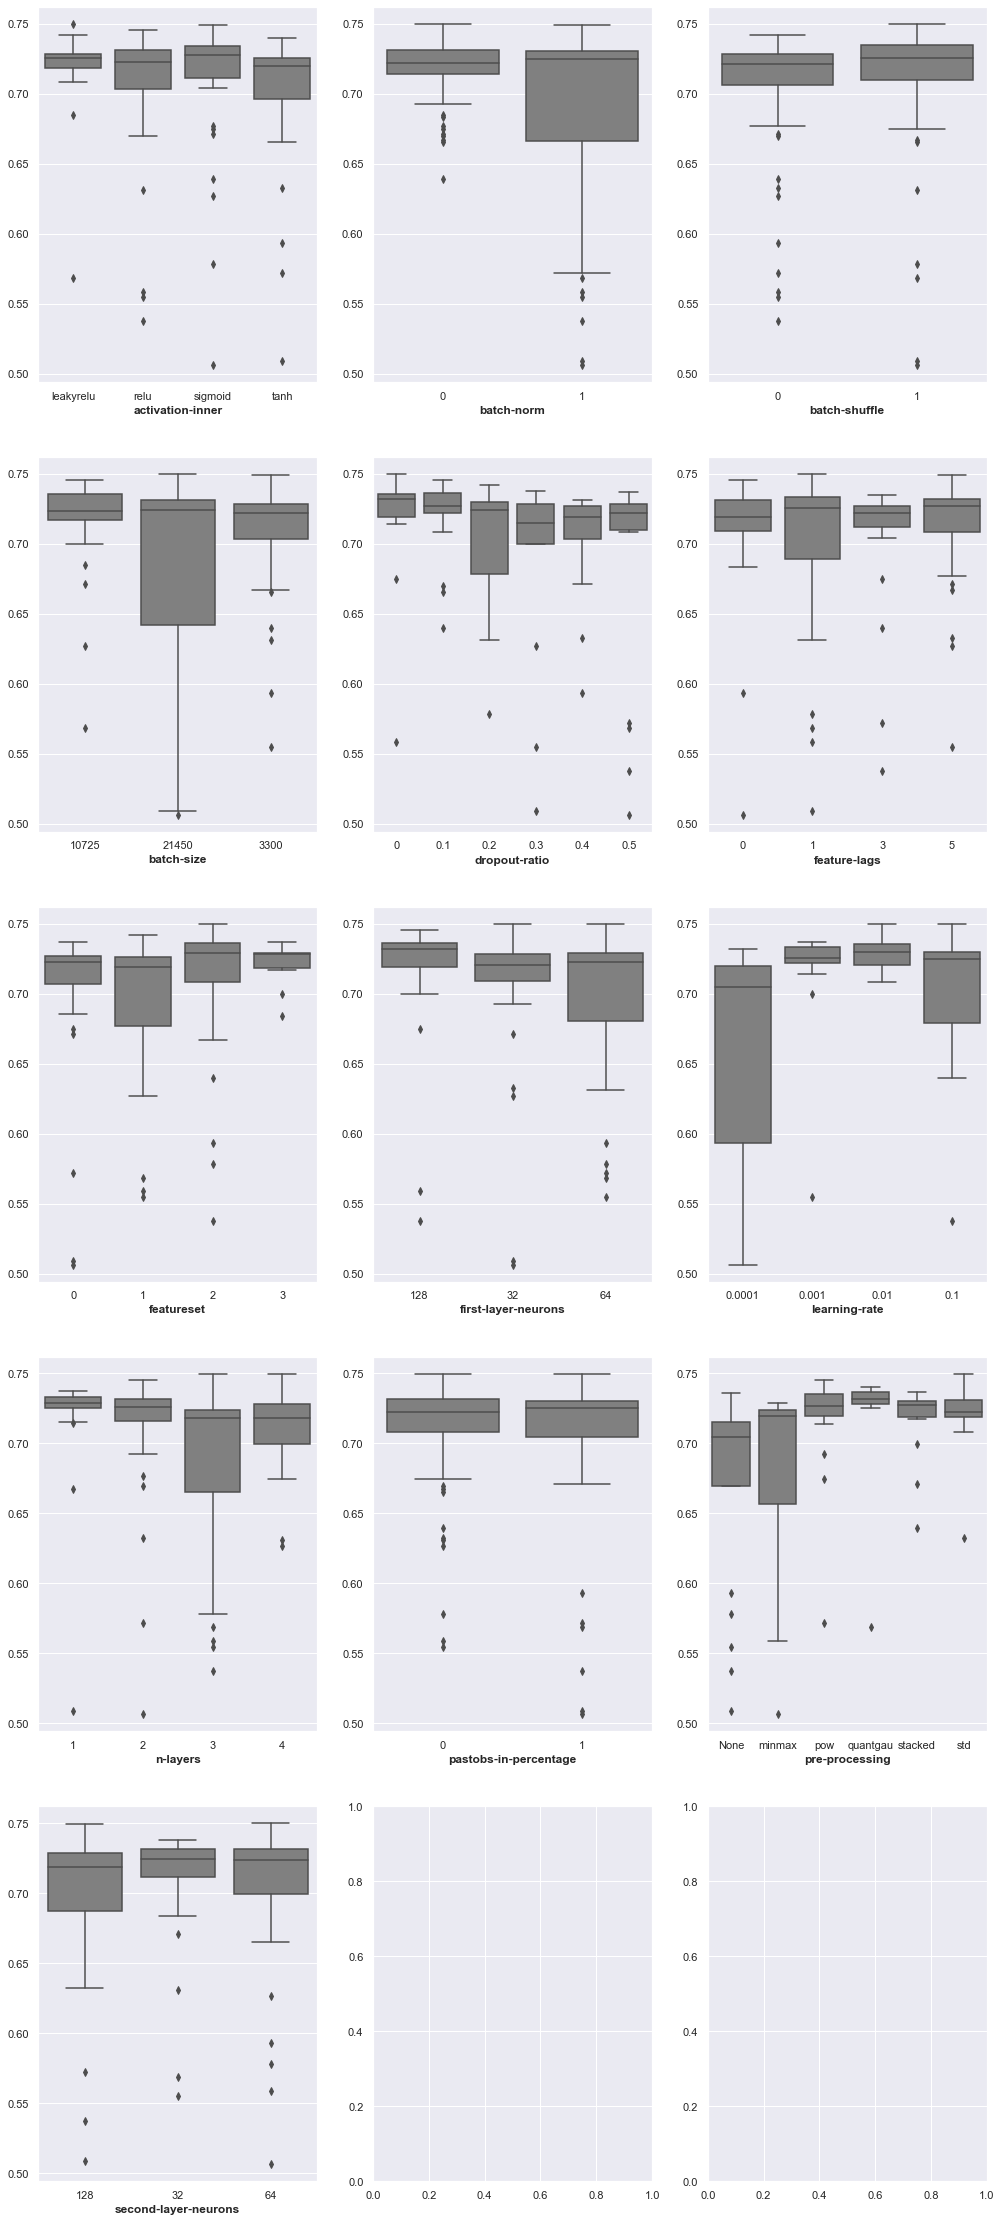

In [23]:
import seaborn as sns

temp = combined_table[(combined_table.loc[:,'label-type']=='4')&\
                      (combined_table.loc[:,'nn-type']=='ffnn')&\
                      (combined_table.AUC>0.5)]

fig,ax = plt.subplots(5,3,figsize=(17,40))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
# plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'font.weight': 'normal'})
k = 0

for i in np.arange(5):
    for j in np.arange(3):
        


        if k < len(cols_to_plot):
            temp_2 = pd.pivot_table(temp,values='AUC',columns=cols_to_plot[k],index='run_id').reset_index()

            # sns.set_theme(style="whitegrid")
            # tips = sns.load_dataset("tips")
            # ax = sns.violinplot(x=tips["total_bill"])
            sns.boxplot(data=temp_2,ax=ax[i,j],color='gray')#,bw='scott'
#             ax[i,j].set_xticks(fontsize=12)
#             ax[i,j].set_yticks(fontsize=12)
            # plt.legend(fontsize=14)
            ax[i,j].set_xlabel(temp_2.columns.name,fontsize=12,fontweight='bold')


            k +=1

plt.show()

In [24]:
combined_table[(combined_table.loc[:,'label-type']=='4')&(combined_table.loc[:,'nn-type']=='ffnn')]

run_id activation-inner  \
749  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_203        leakyrelu   
331  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_626          sigmoid   
444  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_511             relu   
246  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_709        leakyrelu   
477  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_475             tanh   
..                                           ...              ...   
162  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_791             relu   
176  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_779          sigmoid   
481  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_476        leakyrelu   
276  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_678          sigmoid   
434  HD_1c31bfb6-c351-4ac5-80ae-2cc10793db6d_521             relu   

    activation-output batch-norm batch-shuffle batch-size dropout-ratio  \
749           softmax          0             1      21450             0   
331           softmax          1             1       3300             0   
444           softmax          1             1      10725           0.1   
246           softmax          0             0      10725           0.2   
477           softmax          0             1      10725           0.1   
..                ...        ...           ...        ...           ...   
162            linear          0             0       3300           0.3   
176            linear          0             1       3300           0.2   
481            linear          0             0      10725           0.1   
276            linear          0             0       3300           0.5   
434            linear          0             0      21450           0.2   

    feature-lags featureset first-layer-neurons  ... pastobs-in-percentage  \
749            1          2                  64  ...                     1   
331            5          2                  32  ...                     0   
444            0          2                 128  ...                     0   
246            5          1                 128  ...                     1   
477            0          2                  32  ...                     0   
..           ...        ...                 ...  ...                   ...   
162            5          1                  64  ...                     1   
176            1          0                 128  ...                     0   
481            1          3                 128  ...                     0   
276            5          1                  64  ...                     1   
434            1          1                 128  ...                     1   

    pre-processing second-layer-neurons   id      AUC Accuracy     Loss  \
749            std                   64  203  0.74993  0.42211  1.35455   
331            std                  128  626  0.74942  0.40550  1.38884   
444            pow                  128  511  0.74546  0.43067  1.33084   
246            pow                   64  709  0.74169  0.42364  1.37288   
477       quantgau                   64  475  0.74017  0.43304  1.32568   
..             ...                  ...  ...      ...      ...      ...   
162            pow                   32  791  0.00000  0.07438  1.34600   
176       quantgau                   64  779  0.00000  0.07507  1.54481   
481           None                  128  476  0.00000  0.08518  1.42205   
276       quantgau                   64  678  0.00000  0.07619  1.37767   
434       quantgau                  128  521  0.00000  0.07830  1.40702   

    Train AUC Train Accuracy  Train Loss  
749   0.74990        0.43109     1.31745  
331   0.74938        0.44001     1.29992  
444   0.74543        0.42084     1.33574  
246   0.74166        0.41964     1.34487  
477   0.74015        0.41031     1.35946  
..        ...            ...         ...  
162   0.00000        0.08571     1.40017  
176   0.00000        0.08475     1.52267  
481   0.00000        0.09196     1.44856  
276   0.00000        0.09025     1.44331  
4

In [25]:
for i in combined_table['nn-type'].unique():
    for j in combined_table['label-type'].unique():
        print()

In [26]:
tt, ss = np.unique(combined_table[combined_table['nn-type']=='ffnn']['label-type'],return_counts=True)
tt, ss

(array(['0', '1', '2', '3', '4'], dtype=object),
 array([209, 198, 173, 175, 200], dtype=int64))

In [27]:
# t,s = np.unique(combined_table[combined_table['nn-type']=='lstm']['label-type'],return_counts=True)
# t,s

# Loading Logistic Regression

In [28]:
os.listdir(azure_files_path) # azure_files_path is defined when loading in the output from the neural network

['hyperparameters_lr_20201221_v3.txt',
 'hyperparameters_nn_20201221_v1.txt',
 'metrics_lr_20201221_v3.txt',
 'metrics_nn_20201221_v1.txt']

In [29]:
# hyperfiles_lr = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('hyper' in i) & ('lr' in i)]
# metricfiles_lr = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('metric' in i) & ('lr' in i)]
hyperfiles_lr = [i for i in os.listdir(azure_files_path) if ('hyper' in i) & ('lr' in i)]
metricfiles_lr = [i for i in os.listdir(azure_files_path) if ('metric' in i) & ('lr' in i)]

In [30]:
hyperfiles_lr

['hyperparameters_lr_20201221_v3.txt']

In [31]:
for j,file in enumerate(hyperfiles_lr):
    
    if j >= 0:
        
        ### Reading in the file

#         with open('../AzureML/Output_from_cloud/'+hyperfiles_lr[j],'r') as file:
#             content = file.readlines()
        with open(azure_files_path+'/'+hyperfiles_lr[j],'r') as file:
            content = file.readlines()

        ## Going over each line in the text file
        for a in np.arange(len(content)):

            ## Split the lines on tabs
            temp_parameters = re.split('[\t]',content[a])[1]

            ## Basic string cleaning, i.e. removing redundant characters
#             test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
#                                                                                .replace('}','')\
#                                                                                .replace('\n','')\
#                                                                                .replace('"',''))]
            test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                       .replace('}','')\
                                                                       .replace('\n','')\
                                                                       .replace('"','')\
                                                                       .replace('--','')\
                                                                       .replace('\'',''))]

            ## Output of test is a list of lists, where each sublist holds the name of a model variable and its value.
            ## We create a dictornary to hold all model variables, making it easy to add the observation to the dataframe.
            try:
                test = {i[0]:i[1] for i in test}

                # Constructing the dataframe
                if (a == 0)&(j==0):
                    parameters_lr = pd.DataFrame(test,index=[re.split('[\t]',content[a])[0]])

                else:

                    parameters_lr.loc[re.split('[\t]',content[a])[0]] = pd.Series(test)
            except:
                print('Line %i in file %s caused an error, which was neglected' % (a,file))
        
#         lastone = a

Line 947 in file <_io.TextIOWrapper name='../AzureML/Output_from_cloud/2020-12-21/hyperparameters_lr_20201221_v3.txt' mode='r' encoding='cp1252'> caused an error, which was neglected


In [32]:
parameters_lr

batch-shuffle batch-size  \
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_946             1      10725   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_935             0       3300   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_943             0      21450   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_939             1      21450   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_942             0       3300   
...                                                   ...        ...   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_5               1      10725   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_0               1      10725   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_8               1      21450   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_7               1      21450   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_1               0       3300   

                                            feature-lags featureset  \
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_946            1          3   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_935            5          0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_943            0          2   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_939            0          2   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_942            3          3   
...                                                  ...        ...   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_5              0          0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_0              5          1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_8              0          0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_7              0          3   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_1              5          3   

                                            l2-penalty l2-type label-type  \
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_946       1000       3          1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_935       0.01       2          3   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_943          1       1          3   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_939       1000       5          3   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_942       1000       2          0   
...                                                ...     ...        ...   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_5         1000       5          1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_0            1       4          2   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_8         0.01       3          0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_7        10000       1          2   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_1       0.0001       2          4   

                                            learning-rate loss-from-logits  \
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_946        0.0001                0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_935        0.0001                1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_943          0.01                0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_939         0.001                1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_942           0.1                1   
...                                                   ...              ...   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_5             0.1                1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_0          0.0001                0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_8          0.0001                0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_7             0.1                1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_1             0.1                0   

                                            n-epochs pastobs-in-percentage  \
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_946      150                     0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_935      150                     1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_943      150                     1   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_939      150                     0   
HD_cd9ee539-71c9-4336-abd1-d57be726ee53_942      150                     1

In [33]:
for j,file in enumerate(metricfiles_lr):
    
    if j >= 0:
        
        ## Readidng in the file
#         with open('../AzureML/Output_from_cloud/'+metricfiles_lr[j],'r') as file:
#             content = file.readlines()
        with open(azure_files_path+'/'+metricfiles_lr[j],'r') as file:
            content = file.readlines()

        ## Containers
        t11 = []
        t12 = []
        t13 = []

        t21 = []
        t22 = []
        t23 = []

        ## Going over each line
        for i in np.arange(len(content)):#

            ## Split each line on tabs
            temp = re.split('\t',content[i].replace('\n',''))

            ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
            ## and 2. a time series of a metric for each model.

            ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
            ## It stored separately for the time series.
            if len(temp[2]) < 50:

                t11.append(temp[0])
                t12.append(temp[1])
                t13.append(temp[2])

            ## Time series
            else:

                container = np.zeros(155)
                temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

                container[0:len(temp1)] = temp1
                container[len(temp1):] = temp1[-1]

                t21.append(temp[0])
                t22.append(temp[1])
                t23.append(container)        

        ## Storing the time series in a dataframe
        arrays = [t21,t22]
        tuples = list(zip(*arrays))
        if j == 0:
            
            runningMetrics_lr = pd.DataFrame(np.array(t23),
                                              index=pd.MultiIndex.from_tuples(tuples),
                                              columns = [np.arange(155).astype(str)]
                                             )
        else:
            temp_1 = pd.DataFrame(np.array(t23),
                                  index=pd.MultiIndex.from_tuples(tuples),
                                  columns = [np.arange(155).astype(str)])
            runningMetrics_lr = pd.concat([runningMetrics_lr,temp_1])
        ## Storing the final metrics in a dataframe.
        arrays = [t11,t12]
        tuples = list(zip(*arrays))
        if j == 0:
            
            finalMetrics_lr = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])
        else:
            
            temp = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])
            finalMetrics_lr = pd.concat([finalMetrics_lr,temp],axis = 0)

# Attaching the last observation of each model, for each metric, to the parameters of the model

In [34]:
## Resetting indcies and rename columns
runningMetrics_lr2 = runningMetrics_lr.reset_index().rename(columns={'level_0':'run_id','level_1':'metric'})
runningMetrics_lr2.columns = runningMetrics_lr2.columns.get_level_values(0)

## Adding a column of short ids, to merge on.
runningMetrics_lr2['id'] = [re.split('-',i)[-1] for i in runningMetrics_lr2.run_id] #np.arange(runningMetrics_lr2.shape[0]).astype(str)#
runningMetrics_lr2

# ## Creating a table, having the short id in the rows and the last observation for each metric in the columns. 
table_lr = pd.pivot_table(runningMetrics_lr2[['run_id','metric','154','id']],index='id',columns=['metric'])
table_lr.columns = table_lr.columns.get_level_values(1)
table_lr = table_lr.round(7).reset_index()
table_lr

## Preparing the parameter dataframe.
parameters_lr2 = parameters_lr.reset_index().rename(columns={'index':'run_id'})

## Setting short ID
parameters_lr2['id'] = [re.split('-',i)[-1] for i in parameters_lr2.run_id] #np.arange(parameters_lr2.shape[0]).astype(str) #[re.split('_',i)[-1] for i in parameters_lr.run_id]

## Creating the combined table
combined_table_lr = parameters_lr2.merge(table_lr,
                                     on = 'id',
                                     how='left').sort_values('AUC',ascending=False)
combined_table_lr

run_id batch-shuffle batch-size  \
638  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_308             1       3300   
705  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_241             1      10725   
382  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_565             0      10725   
217  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_729             1      10725   
927   HD_cd9ee539-71c9-4336-abd1-d57be726ee53_18             0      10725   
..                                           ...           ...        ...   
483  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_463             0      10725   
675  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_271             0      21450   
437  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_510             0      21450   
262  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_682             1      10725   
727  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_218             0       3300   

    feature-lags featureset l2-penalty l2-type label-type learning-rate  \
638            0          3          1       0          2          0.01   
705            3          3      0.001       0          2         0.001   
382            5          2     0.0001       2          2         0.001   
217            5          1        0.1       0          2         0.001   
927            3          3      0.001       4          2         0.001   
..           ...        ...        ...     ...        ...           ...   
483            1          0       1000       0          3         0.001   
675            3          2       0.01       0          3           0.1   
437            3          1         10       0          3           0.1   
262            5          3     0.0001       0          3           0.1   
727            0          0        0.1       2          0        0.0001   

    loss-from-logits n-epochs pastobs-in-percentage pre-processing  \
638                0      150                     0       quantgau   
705                0      150                     0        stacked   
382                0      150                     1        stacked   
217                0      150                     0        stacked   
927                0      150                     0        stacked   
..               ...      ...                   ...            ...   
483                1      150                     1       quantgau   
675                1      150                     1           None   
437                1      150                     0           None   
262                1      150                     1           None   
727                1      150                     1           None   

                   id       AUC  Accuracy       Loss  Train AUC  \
638  d57be726ee53_308  0.771761  0.625785   0.863616   0.771745   
705  d57be726ee53_241  0.768538  0.625608   0.867931   0.768511   
382  d57be726ee53_565  0.765900  0.625859   0.867642   0.765868   
217  d57be726ee53_729  0.765573  0.625990   0.873034   0.765550   
927   d57be726ee53_18  0.763237  0.624553   0.877939   0.763206   
..                ...       ...       ...        ...        ...   
483  d57be726ee53_463  0.004005  0.292019   1.530025   0.004005   
675  d57be726ee53_271  0.000643  0.236466  11.746910   0.000645   
437  d57be726ee53_510  0.000187  0.257661   9.044662   0.000187   
262  d57be726ee53_682  0.000136  0.244013   9.470814   0.000137   
727  d57be726ee53_218  0.000000  0.549858   0.705130   0.000000   

     Train Accuracy  Train Loss  
638        0.601603    0.898513  
705        0.601714    0.899435  
382        0.600526    0.903092  
217        0.600610    0.906141  
927        0.600038    0.912626  
..              ...         ...  
483        0.291780    1.531282  
675        0.245317    9.073337  
437        0.242897    6.396808  
262        0.238941    8.556830  
727        0.546107    0.706347  

[947 rows x 20 columns]

In [35]:
combined_table_lr

run_id batch-shuffle batch-size  \
638  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_308             1       3300   
705  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_241             1      10725   
382  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_565             0      10725   
217  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_729             1      10725   
927   HD_cd9ee539-71c9-4336-abd1-d57be726ee53_18             0      10725   
..                                           ...           ...        ...   
483  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_463             0      10725   
675  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_271             0      21450   
437  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_510             0      21450   
262  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_682             1      10725   
727  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_218             0       3300   

    feature-lags featureset l2-penalty l2-type label-type learning-rate  \
638            0          3          1       0          2          0.01   
705            3          3      0.001       0          2         0.001   
382            5          2     0.0001       2          2         0.001   
217            5          1        0.1       0          2         0.001   
927            3          3      0.001       4          2         0.001   
..           ...        ...        ...     ...        ...           ...   
483            1          0       1000       0          3         0.001   
675            3          2       0.01       0          3           0.1   
437            3          1         10       0          3           0.1   
262            5          3     0.0001       0          3           0.1   
727            0          0        0.1       2          0        0.0001   

    loss-from-logits n-epochs pastobs-in-percentage pre-processing  \
638                0      150                     0       quantgau   
705                0      150                     0        stacked   
382                0      150                     1        stacked   
217                0      150                     0        stacked   
927                0      150                     0        stacked   
..               ...      ...                   ...            ...   
483                1      150                     1       quantgau   
675                1      150                     1           None   
437                1      150                     0           None   
262                1      150                     1           None   
727                1      150                     1           None   

                   id       AUC  Accuracy       Loss  Train AUC  \
638  d57be726ee53_308  0.771761  0.625785   0.863616   0.771745   
705  d57be726ee53_241  0.768538  0.625608   0.867931   0.768511   
382  d57be726ee53_565  0.765900  0.625859   0.867642   0.765868   
217  d57be726ee53_729  0.765573  0.625990   0.873034   0.765550   
927   d57be726ee53_18  0.763237  0.624553   0.877939   0.763206   
..                ...       ...       ...        ...        ...   
483  d57be726ee53_463  0.004005  0.292019   1.530025   0.004005   
675  d57be726ee53_271  0.000643  0.236466  11.746910   0.000645   
437  d57be726ee53_510  0.000187  0.257661   9.044662   0.000187   
262  d57be726ee53_682  0.000136  0.244013   9.470814   0.000137   
727  d57be726ee53_218  0.000000  0.549858   0.705130   0.000000   

     Train Accuracy  Train Loss  
638        0.601603    0.898513  
705        0.601714    0.899435  
382        0.600526    0.903092  
217        0.600610    0.906141  
927        0.600038    0.912626  
..              ...         ...  
483        0.291780    1.531282  
675        0.245317    9.073337  
437        0.242897    6.396808  
262        0.238941    8.556830  
727        0.546107    0.706347  

[947 rows x 20 columns]

In [39]:
## How many NaN rows?
print(len(combined_table_lr[combined_table_lr.isnull().any(axis=1)]))
# 14 in total: 12 from run 881, 1 (last child run) from run 985 , 1 (last child run) from run 453
# HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_380 doesn't exist in the experiment window in Azure, looks like it was initialised but not run (hyperparams file has it, metrics file does not)
# HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_170 doesn't exist in the experiment window in Azure, looks like it was initialised but not run (hyperparams file has it, metrics file does not)
# HD_914f915c-2cac-473e-bea5-c26e4c83673c has 11x NaNs because they failed (but metrics file does have all except _84! so they are included)
# the 12 missed runs seems to be an error
combined_table_lr[combined_table_lr.isnull().any(axis=1)]

0


Empty DataFrame
Columns: [run_id, batch-shuffle, batch-size, feature-lags, featureset, l2-penalty, l2-type, label-type, learning-rate, loss-from-logits, n-epochs, pastobs-in-percentage, pre-processing, id, AUC, Accuracy, Loss, Train AUC, Train Accuracy, Train Loss]
Index: []

In [40]:
## Creating a top-X table for each label-type of a given metric, here AUC.
temp_auc_lr = pd.pivot_table(combined_table_lr[['label-type','AUC','id']],index='id',columns='label-type')
temp_acc_lr = pd.pivot_table(combined_table_lr[['label-type','Accuracy','id']],index='id',columns='label-type')

## Final output - AUC
final_output_auc_lr = pd.DataFrame(np.sort(temp_auc_lr.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_auc_lr.columns.get_level_values(1)).loc[0:10]
## Final output - Accuracy
final_output_acc_lr = pd.DataFrame(np.sort(temp_acc_lr.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_acc_lr.columns.get_level_values(1))#.loc[0:10]
# final_output

In [41]:
tempFinal_v0_lr = combined_table_lr[np.isin(combined_table_lr.AUC,final_output_auc_lr.loc[0].values.flatten())].reset_index()
tempFinal_v0_lr.index = tempFinal_v0_lr.loc[:,'label-type']
tempFinal_v0_lr

index                                       run_id batch-shuffle  \
label-type                                                                     
2             638  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_308             1   
4             462  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_482             1   
3              45  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_899             1   
1             731  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_215             1   
0             682  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_265             0   

           batch-size feature-lags featureset l2-penalty l2-type label-type  \
label-type                                                                    
2                3300            0          3          1       0          2   
4               10725            5          2          1       0          4   
3                3300            5          0        0.1       0          3   
1                3300            1          2     0.0001       5          1   
0               21450            3          0        100       0          0   

           learning-rate  ... n-epochs pastobs-in-percentage pre-processing  \
label-type                ...                                                 
2                   0.01  ...      150                     0       quantgau   
4                   0.01  ...      150                     1        stacked   
3                  0.001  ...      150                     1            pow   
1                  0.001  ...      150                     0        stacked   
0                   0.01  ...      150                     1        stacked   

                          id       AUC  Accuracy      Loss  Train AUC  \
label-type                                                              
2           d57be726ee53_308  0.771761  0.625785  0.863616   0.771745   
4           d57be726ee53_482  0.734069  0.426578  1.341306   0.734054   
3           d57be726ee53_899  0.637540  0.298811  1.518487   0.637532   
1           d57be726ee53_215  0.614858  0.428229  1.084257   0.614847   
0           d57be726ee53_265  0.579656  0.552526  0.675933   0.579652   

            Train Accuracy  Train Loss  
label-type                              
2                 0.601603    0.898513  
4                 0.405653    1.375623  
3                 0.300422    1.521072  
1                 0.423406    1.085161  
0                 0.548231    0.677740  

[5 rows x 21 columns]

In [42]:
first_step_lr = tempFinal_v0_lr.copy(deep=True).drop(['run_id','n-epochs','id'],axis=1).sort_index().round({'AUC':3,#'label-type',
                                                                                                              'Accuracy':3,
                                                                                                              'Loss':3,
                                                                                                              'Train AUC':3,
                                                                                                              'Train Accuracy':3,
                                                                                                              'Train Loss':3}).rename({'index':'id'},axis=1)

###     First variables for indentification, the data related variables, estimation parameters, model parameters and then performance.
columns_on_top_lr = ['id','label-type','featureset','pre-processing','pastobs-in-percentage','feature-lags',
                  'batch-shuffle','batch-size','learning-rate','l2-penalty']
residual_lr = [i for i in first_step_lr.columns if i not in columns_on_top_lr]
correct_ordered_lr = []
correct_ordered_lr += columns_on_top_lr
correct_ordered_lr += residual_lr
results_table_lr = first_step_lr.T.loc[correct_ordered_lr,:]

iterables = [['lr'], results_table_lr.columns]

results_table_lr.columns = pd.MultiIndex.from_product(iterables, names=['first', 'second'])

results_table_lr
# first_step.T

first                       lr                                   
second                       0        1         2      3        4
id                         682      731       638     45      462
label-type                   0        1         2      3        4
featureset                   0        2         3      0        2
pre-processing         stacked  stacked  quantgau    pow  stacked
pastobs-in-percentage        1        0         0      1        1
feature-lags                 3        1         0      5        5
batch-shuffle                0        1         1      1        1
batch-size               21450     3300      3300   3300    10725
learning-rate             0.01    0.001      0.01  0.001     0.01
l2-penalty                 100   0.0001         1    0.1        1
l2-type                      0        5         0      0        0
loss-from-logits             0        0         0      0        0
AUC                       0.58    0.615     0.772  0.638    0.734
Accuracy                 0.553    0.428     0.626  0.299    0.427
Loss                     0.676    1.084     0.864  1.518    1.341
Train AUC                 0.58    0.615     0.772  0.638    0.734
Train Accuracy           0.548    0.423     0.602    0.3    0.406
Train Loss               0.678    1.085     0.899  1.521    1.376

# Model specifications table

In [44]:
combined_table.columns

Index(['run_id', 'activation-inner', 'activation-output', 'batch-norm',
       'batch-shuffle', 'batch-size', 'dropout-ratio', 'feature-lags',
       'featureset', 'first-layer-neurons', 'label-type', 'learning-rate',
       'n-epochs', 'n-layers', 'nn-type', 'pastobs-in-percentage',
       'pre-processing', 'second-layer-neurons', 'id', 'AUC', 'Accuracy',
       'Loss', 'Train AUC', 'Train Accuracy', 'Train Loss'],
      dtype='object')

In [117]:
data_for_table = combined_table.loc[:,~combined_table.columns.isin(['run_id','id',
                                                   'AUC','Accuracy','Loss',
                                                   'Train AUC','Train Accuracy','Train Loss','nn-type','n-epochs'])]

data_for_table_lr = combined_table_lr.loc[:,~combined_table_lr.columns.isin(['run_id','id',
                                                   'AUC','Accuracy','Loss',
                                                   'Train AUC','Train Accuracy','Train Loss','nn-type','n-epochs'])]

max_unique_val = data_for_table.apply(lambda x: x.unique().shape[0]).max()
max_unique_val_lr = data_for_table_lr.apply(lambda x: x.unique().shape[0]).max()

overall_val_unique = max_unique_val if max_unique_val > max_unique_val_lr else max_unique_val_lr

table = pd.DataFrame(index=np.arange(overall_val_unique))

### First for NN data

for col in data_for_table.columns:
    temp = np.empty(overall_val_unique).astype(str)
    temp[:] = ''
    individual_numb_unique = data_for_table.loc[:,col].unique().shape[0]
    
    if col in ['label-type',
                 'featureset',
                 'pastobs-in-percentage',
                 'feature-lags',
                 'batch-shuffle',
                 'batch-norm',
               'batch-size',
                 'n-layers',
                 'first-layer-neurons',
                 'second-layer-neurons','loss-from-logits']:
        temp[0:individual_numb_unique] = sorted(data_for_table.loc[:,col].unique().astype(int)) if data_for_table.loc[:,col].unique()[0].isnumeric() else data_for_table.loc[:,col].unique()
    else:
        temp[0:individual_numb_unique] = sorted(data_for_table.loc[:,col].unique().astype(float)) if data_for_table.loc[:,col].unique()[0].isnumeric() else data_for_table.loc[:,col].unique()
    table.loc[:,col] = temp

### Secondly for LR data

for col in data_for_table_lr.columns:
    
    if col not in table.columns:
    
        temp = np.empty(overall_val_unique).astype(str)
        temp[:] = ''
        individual_numb_unique = data_for_table_lr.loc[:,col].unique().shape[0]
        if col in ['label-type',
                 'featureset',
                 'pastobs-in-percentage',
                 'feature-lags',
                 'batch-shuffle',
                   'batch-size',
                 'batch-norm',
                 'n-layers',
                 'first-layer-neurons',
                 'second-layer-neurons','loss-from-logits']:
            temp[0:individual_numb_unique] = sorted(data_for_table_lr.loc[:,col].unique().astype(int)) if data_for_table_lr.loc[:,col].unique()[0].isnumeric() else data_for_table_lr.loc[:,col].unique()
        else:
            temp[0:individual_numb_unique] = sorted(data_for_table_lr.loc[:,col].unique().astype(float)) if data_for_table_lr.loc[:,col].unique()[0].isnumeric() else data_for_table_lr.loc[:,col].unique()
        table.loc[:,col] = temp
        
table = table.fillna('').T

table


0         1      2          3        4     5  \
activation-inner          tanh   sigmoid   relu  leakyrelu                  
activation-output      softmax    linear                                    
batch-norm                   0         1                                    
batch-shuffle                0         1                                    
batch-size                3300     10725  21450                             
dropout-ratio              0.1         0    0.3        0.2      0.4   0.5   
feature-lags                 0         1      3          5                  
featureset                   0         1      2          3                  
first-layer-neurons         32        64    128                             
label-type                   0         1      2          3        4         
learning-rate             0.01       0.1  0.001     0.0001                  
n-layers                     1         2      3          4                  
pastobs-in-percentage        0         1                                    
pre-processing             std  quantgau    pow     minmax  stacked  None   
second-layer-neurons        32        64    128                             
l2-penalty              0.0001     0.001   0.01        0.1      1.0  10.0   
l2-type                    0.0       1.0    2.0        3.0      4.0   5.0   
loss-from-logits             0         1                                    

                           6       7        8              9  
activation-inner                                              
activation-output                                             
batch-norm                                                    
batch-shuffle                                                 
batch-size                                                    
dropout-ratio                                                 
feature-lags                                                  
featureset                                                    
first-layer-neurons                                           
label-type                                                    
learning-rate                                                 
n-layers                                                      
pastobs-in-percentage                                         
pre-processing                                                
second-layer-neurons                                          
l2-penalty             100.0  1000.0  10000.0  10000000000.0  
l2-type                  6.0                                  
loss-from-logits

In [118]:
indices_on_top = ['label-type','featureset','pre-processing', 'pastobs-in-percentage', 'feature-lags',
                  'learning-rate','batch-shuffle', 'batch-size','batch-norm','dropout-ratio',
                  'n-layers', 'activation-inner', 'activation-output','first-layer-neurons', 'second-layer-neurons',
                  'l2-penalty','l2-type', 'loss-from-logits']
residual = [i for i in table.index if i not in indices_on_top]
correct_ordered = []
correct_ordered += indices_on_top
correct_ordered += residual

table = table.loc[correct_ordered,:]

# table = table.loc[correct_ordered,:].T.astype({'label-type':float,
#                                              'featureset':float,
#                                              'pastobs-in-percentage':float,
#                                              'feature-lags':float,
#                                              'batch-shuffle':float,
#                                              'batch-norm':float,
#                                              'n-layers':float,
#                                              'first-layer-neurons':float,
#                                              'second-layer-neurons':float}).astype({'label-type':int,
#                                              'featureset':int,
#                                              'pastobs-in-percentage':int,
#                                              'feature-lags':int,
#                                              'batch-shuffle':int,
#                                              'batch-norm':int,
#                                              'n-layers':int,
#                                              'first-layer-neurons':int,
#                                              'second-layer-neurons':int}).astype(str)#'loss-from-logits':int
# table = table.T
### Make bool variables more readable

boolCols = ['pastobs-in-percentage','batch-norm','batch-shuffle','loss-from-logits']

for ind in boolCols:
    
    table.loc[ind,:] = table.loc[ind,:].apply(lambda x: 'Yes' if x == '1' '' else '' if x == '' else 'No')
    
### Ensuring L2-penalty fits

table.loc['l2-penalty',:] = table.loc['l2-penalty',:].apply(lambda x: '%.0e' % Decimal(x) if x != '' else '')
    
### Replacing [_-] with space, and capitalise

table.index = [i.replace('_',' ').replace('-',' ').capitalize() for i in table.index]

### Renaming

table = table.rename(index={'Pre processing':'Transformation',
                                                'Pastobs in percentage':'\text{PD}\;(\%)',
                                                'Feature lags':'Lags',
                                                'First layer neurons':'M_1',
                                                'Second layer neurons':'M_l',
                                                'Featureset':'\mathbb{E}',
                                                'Activation inner':'g(\cdot)_{inner}',
                                                'Activation output':'g(\cdot)_{output}'})
### Show
    
table

0         1      2          3        4      5      6  \
Label type               0         1      2          3        4                 
\mathbb{E}               0         1      2          3                          
Transformation         std  quantgau    pow     minmax  stacked   None          
\text{PD}\;(\%)         No       Yes                                            
Lags                     0         1      3          5                          
Learning rate         0.01       0.1  0.001     0.0001                          
Batch shuffle           No       Yes                                            
Batch size            3300     10725  21450                                     
Batch norm              No       Yes                                            
Dropout ratio          0.1         0    0.3        0.2      0.4    0.5          
N layers                 1         2      3          4                          
g(\cdot)_{inner}      tanh   sigmoid   relu  leakyrelu                          
g(\cdot)_{output}  softmax    linear                                            
M_1                     32        64    128                                     
M_l                     32        64    128                                     
L2 penalty           1e-04     1e-03  1e-02      1e-01    1e+00  1e+01  1e+02   
L2 type                0.0       1.0    2.0        3.0      4.0    5.0    6.0   
Loss from logits        No       Yes                                            

                       7      8      9  
Label type                              
\mathbb{E}                              
Transformation                          
\text{PD}\;(\%)                         
Lags                                    
Learning rate                           
Batch shuffle                           
Batch size                              
Batch norm                              
Dropout ratio                           
N layers                                
g(\cdot)_{inner}                        
g(\cdot)_{output}                       
M_1                                     
M_l                                     
L2 penalty         1e+03  1e+04  1e+10  
L2 type                                 
Loss from logits

# Model results table

In [294]:
max_class_share = {'0':0.50,'1':0.33,'2':0.60,'3':0.20,'4':0.40}

agg_table = pd.concat([results_table,
                       results_table_lr],axis=1).fillna('')
# Relative Accuracy
agg_table.loc['Diff Accuracy',:] = agg_table.loc[['label-type','Accuracy'],:].apply(lambda x: float(x[1])-max_class_share[str(x[0])])
agg_table.loc['Relative Accuracy',:] = agg_table.loc[['label-type','Accuracy'],:].apply(lambda x: float(x[1])/max_class_share[str(x[0])])
agg_table.loc['Relative AUC',:] = agg_table.loc[['label-type','AUC'],:].apply(lambda x: float(x[1])/max_class_share[str(x[0])])

### Adjust decimals
agg_table.loc[['AUC','Accuracy','Loss',
               'Train AUC','Train Accuracy','Train Loss',
               'Diff Accuracy','Relative Accuracy','Relative AUC'],:] = agg_table.loc[['AUC','Accuracy','Loss',
                                                                                       'Train AUC','Train Accuracy',
                                                                                       'Train Loss','Diff Accuracy',
                                                                                       'Relative Accuracy','Relative AUC'],:]\
                                                                        .apply(lambda x: ['%.3f' % Decimal(y) for y in x])


agg_table

first                        nn                                        \
second                        0        1        2        3          4   
nn-type                    ffnn     ffnn     ffnn     ffnn       ffnn   
id                          927       57      265      129        203   
label-type                    0        1        2        3          4   
featureset                    1        3        1        1          2   
pre-processing         quantgau      pow      std      pow        std   
pastobs-in-percentage         0        0        1        0          1   
feature-lags                  5        1        5        1          1   
batch-norm                    1        1        1        1          0   
batch-shuffle                 0        1        1        1          1   
batch-size                21450     3300     3300    21450      21450   
dropout-ratio               0.1        0      0.1        0          0   
learning-rate             0.001     0.01     0.01     0.01       0.01   
n-layers                      2        1        1        4          4   
activation-inner           relu     tanh     tanh  sigmoid  leakyrelu   
activation-output       softmax  softmax  softmax  softmax    softmax   
first-layer-neurons         128      128       64       64         64   
second-layer-neurons        128      128       64      128         64   
AUC                       0.654    0.664    0.795    0.682      0.750   
Accuracy                  0.539    0.411    0.615    0.266      0.422   
Loss                      0.731    1.113    0.902    1.922      1.355   
Train AUC                 0.654    0.664    0.795    0.682      0.750   
Train Accuracy            0.681    0.519    0.640    0.469      0.431   
Train Loss                0.590    0.975    0.817    1.254      1.317   
l2-penalty                                                              
l2-type                                                                 
loss-from-logits                                                        
Diff Accuracy             0.039    0.081    0.015    0.066      0.022   
Relative Accuracy         1.078    1.245    1.025    1.330      1.055   
Relative AUC              1.308    2.012    1.325    3.410      1.875   

first                       lr                                     
second                       0        1         2      3        4  
nn-type                                                            
id                         682      731       638     45      462  
label-type                   0        1         2      3        4  
featureset                   0        2         3      0        2  
pre-processing         stacked  stacked  quantgau    pow  stacked  
pastobs-in-percentage        1        0         0      1        1  
feature-lags                 3        1         0      5        5  
batch-norm                                                         
batch-shuffle                0        1         1      1        1  
batch-size               21450     3300      3300   3300    10725  
dropout-ratio                                                      
learning-rate             0.01    0.001      0.01  0.001     0.01  
n-layers                                                           
activation-inner                                                   
activation-output                                                  
first-layer-neurons                                                
second-layer-neurons                                               
AUC                      0.580    0.615     0.772  0.638    0.734  
Accuracy                 0.553    0.428     0.626  0.299    0.427  
Loss                     0.676    1.084     0.864  1.518    1.341  
Train AUC                0.580    0.615     0.772  0.638    0.734  
Train Accuracy           0.548    0.423     0.602  0.300    0.406  
Train Loss               0.678    1.085     0.899  1.521    1.376  
l2-penalty                 100   0.0

In [295]:
###################################### Only for LATEX table ##############################################


agg_table_latex = agg_table.copy(deep=True)
old_cols = agg_table_latex.columns.copy(deep=True)
agg_table_latex.columns = old_cols.get_level_values(1)
agg_table_latex.loc['model_type',:] = list(old_cols.get_level_values(0))

###     First variables for indentification, the data related variables, estimation parameters, model parameters and then performance.
indices_on_top = ['model_type','label-type','AUC','Accuracy','Loss','Train AUC','Train Accuracy','Train Loss',
                  'Relative Accuracy','Diff Accuracy','Relative AUC',
                  'featureset','id','pre-processing', 'pastobs-in-percentage', 'feature-lags',
                  'learning-rate','batch-shuffle', 'batch-size','batch-norm','dropout-ratio',
                  'n-layers', 'activation-inner', 'activation-output','first-layer-neurons', 'second-layer-neurons',
                  'l2-penalty','l2-type', 'loss-from-logits']
residual = [i for i in agg_table_latex.index if i not in indices_on_top]
correct_ordered = []
correct_ordered += indices_on_top
correct_ordered += residual

### Formatting of L2-penalty to fit in table
agg_table_latex.loc['l2-penalty',:] = agg_table_latex.loc['l2-penalty',:].apply(lambda x: '%.0e' % Decimal(x) if x != '' else '')

agg_table_latex = agg_table_latex.loc[correct_ordered,:].sort_values('label-type',axis=1)

### Make bool variables more readable

boolCols = ['pastobs-in-percentage','batch-norm','batch-shuffle','loss-from-logits']

for ind in boolCols:
    
    agg_table_latex.loc[ind,:] = agg_table_latex.loc[ind,:].apply(lambda x: 'Yes' if x == '1' '' else '' if x == '' else 'No')

### Replacing [_-] with space, and capitalise

agg_table_latex.index = [i.replace('_',' ').replace('-',' ').capitalize() for i in agg_table_latex.index]

### Renaming

agg_table_latex = agg_table_latex.rename(index={'Pre processing':'Transformation',
                                                'Pastobs in percentage':'\text{PD}\;(\%)',
                                                'Feature lags':'Lags',
                                                'First layer neurons':'M_1',
                                                'Second layer neurons':'M_l',
                                                'Featureset':'\mathbb{E}',
                                                'Auc':'AUC, val.',
                                                'Accuracy':'Accruacy, val.',
                                                'Loss':'Loss, val.',
                                                'Train auc': 'AUC, in-sample',
                                                'Train accuracy': 'Accuracy, in-sample',
                                                'Train loss':'Loss, in-sample',
                                                'Relative accuracy': 'Accuracy, rel.*, val.',
                                                'Diff accuracy':'Accuracy, diff.*, val.',
                                                'Relative auc':'AUC, rel.*, val.',
                                                'Activation inner':'g(\cdot)_{inner}',
                                                'Activation output':'g(\cdot)_{output}'}).drop(['Id','Nn type'])
### Show

agg_table_latex

second                         0        0        1        1        2  \
Model type                    nn       lr       nn       lr       nn   
Label type                     0        0        1        1        2   
AUC, val.                  0.654    0.580    0.664    0.615    0.795   
Accruacy, val.             0.539    0.553    0.411    0.428    0.615   
Loss, val.                 0.731    0.676    1.113    1.084    0.902   
AUC, in-sample             0.654    0.580    0.664    0.615    0.795   
Accuracy, in-sample        0.681    0.548    0.519    0.423    0.640   
Loss, in-sample            0.590    0.678    0.975    1.085    0.817   
Accuracy, rel.*, val.      1.078    1.106    1.245    1.297    1.025   
Accuracy, diff.*, val.     0.039    0.053    0.081    0.098    0.015   
AUC, rel.*, val.           1.308    1.160    2.012    1.864    1.325   
\mathbb{E}                     1        0        3        2        1   
Transformation          quantgau  stacked      pow  stacked      std   
\text{PD}\;(\%)               No      Yes       No       No      Yes   
Lags                           5        3        1        1        5   
Learning rate              0.001     0.01     0.01    0.001     0.01   
Batch shuffle                 No       No      Yes      Yes      Yes   
Batch size                 21450    21450     3300     3300     3300   
Batch norm                   Yes               Yes               Yes   
Dropout ratio                0.1                 0               0.1   
N layers                       2                 1                 1   
g(\cdot)_{inner}            relu              tanh              tanh   
g(\cdot)_{output}        softmax           softmax           softmax   
M_1                          128               128                64   
M_l                          128               128                64   
L2 penalty                          1e+02             1e-04            
L2 type                                 0                 5            
Loss from logits                       No                No            

second                         2        3      3          4        4  
Model type                    lr       nn     lr         nn       lr  
Label type                     2        3      3          4        4  
AUC, val.                  0.772    0.682  0.638      0.750    0.734  
Accruacy, val.             0.626    0.266  0.299      0.422    0.427  
Loss, val.                 0.864    1.922  1.518      1.355    1.341  
AUC, in-sample             0.772    0.682  0.638      0.750    0.734  
Accuracy, in-sample        0.602    0.469  0.300      0.431    0.406  
Loss, in-sample            0.899    1.254  1.521      1.317    1.376  
Accuracy, rel.*, val.      1.043    1.330  1.495      1.055    1.067  
Accuracy, diff.*, val.     0.026    0.066  0.099      0.022    0.027  
AUC, rel.*, val.           1.287    3.410  3.190      1.875    1.835  
\mathbb{E}                     3        1      0          2        2  
Transformation          quantgau      pow    pow        std  stacked  
\text{PD}\;(\%)               No       No    Yes        Yes      Yes  
Lags                           0        1      5          1        5  
Learning rate               0.01     0.01  0.001       0.01     0.01  
Batch shuffle                Yes      Yes    Yes        Yes      Yes  
Batch size                  3300    21450   3300      21450    10725  
Batch norm                            Yes                No           
Dropout ratio                           0                 0           
N layers                                4                 4           
g(\cdot)_{inner}                  sigmoid         leakyrelu           
g(\cdot)_{output}                 softmax           softmax           
M_1                                    64                64           
M_l                                   128                64           
L2 penalty                 1e+00           1e-01               1e

## For backtest module

In [198]:
[i.replace('-','_')+'_in' for i in agg_table.index]

['nn_type_in',
 'id_in',
 'label_type_in',
 'featureset_in',
 'pre_processing_in',
 'pastobs_in_percentage_in',
 'feature_lags_in',
 'batch_norm_in',
 'batch_shuffle_in',
 'batch_size_in',
 'dropout_ratio_in',
 'learning_rate_in',
 'n_layers_in',
 'activation_inner_in',
 'activation_output_in',
 'first_layer_neurons_in',
 'second_layer_neurons_in',
 'AUC_in',
 'Accuracy_in',
 'Loss_in',
 'Train AUC_in',
 'Train Accuracy_in',
 'Train Loss_in',
 'l2_penalty_in',
 'l2_type_in',
 'loss_from_logits_in']

In [199]:
agg_table.index = [i.replace('-','_')+'_in' for i in agg_table.index]
agg_table.to_dict()

{('nn', '0'): {'nn_type_in': 'ffnn',
  'id_in': '927',
  'label_type_in': '0',
  'featureset_in': '1',
  'pre_processing_in': 'quantgau',
  'pastobs_in_percentage_in': '0',
  'feature_lags_in': '5',
  'batch_norm_in': '1',
  'batch_shuffle_in': '0',
  'batch_size_in': '21450',
  'dropout_ratio_in': '0.1',
  'learning_rate_in': '0.001',
  'n_layers_in': '2',
  'activation_inner_in': 'relu',
  'activation_output_in': 'softmax',
  'first_layer_neurons_in': '128',
  'second_layer_neurons_in': '128',
  'AUC_in': 0.654,
  'Accuracy_in': 0.539,
  'Loss_in': 0.731,
  'Train AUC_in': 0.654,
  'Train Accuracy_in': 0.681,
  'Train Loss_in': 0.59,
  'l2_penalty_in': '',
  'l2_type_in': '',
  'loss_from_logits_in': ''},
 ('nn', '1'): {'nn_type_in': 'ffnn',
  'id_in': '57',
  'label_type_in': '1',
  'featureset_in': '3',
  'pre_processing_in': 'pow',
  'pastobs_in_percentage_in': '0',
  'feature_lags_in': '1',
  'batch_norm_in': '1',
  'batch_shuffle_in': '1',
  'batch_size_in': '3300',
  'dropout_r

# Plot the runs

In [140]:
tempFinal_v1_lr = combined_table_lr[np.isin(combined_table_lr.Accuracy,final_output_acc_lr.loc[0].values.flatten())].sort_values('label-type').copy(deep=True)
tempFinal_v1_lr.index = tempFinal_v1_lr.loc[:,'label-type']
tempFinal_v1_lr

run_id batch-shuffle  \
label-type                                                              
0           HD_cd9ee539-71c9-4336-abd1-d57be726ee53_659             1   
1           HD_cd9ee539-71c9-4336-abd1-d57be726ee53_933             1   
2           HD_cd9ee539-71c9-4336-abd1-d57be726ee53_609             0   
3           HD_cd9ee539-71c9-4336-abd1-d57be726ee53_481             0   
4           HD_cd9ee539-71c9-4336-abd1-d57be726ee53_304             1   

           batch-size feature-lags featureset l2-penalty l2-type label-type  \
label-type                                                                    
0                3300            0          3     0.0001       3          0   
1               21450            0          3       1000       0          1   
2                3300            0          2      0.001       6          2   
3               10725            1          3          1       0          3   
4               21450            3          0      0.001       2          4   

           learning-rate loss-from-logits n-epochs pastobs-in-percentage  \
label-type                                                                 
0                   0.01                1      150                     0   
1                  0.001                0      150                     1   
2                 0.0001                0      150                     0   
3                  0.001                1      150                     0   
4                  0.001                1      150                     1   

           pre-processing                id       AUC  Accuracy      Loss  \
label-type                                                                  
0                quantgau  d57be726ee53_659  0.137714  0.554671  0.686667   
1                quantgau  d57be726ee53_933  0.605788  0.432893  1.051603   
2                     pow  d57be726ee53_609  0.651166  0.626233  1.087106   
3                     pow  d57be726ee53_481  0.135353  0.302216  1.517675   
4                     std  d57be726ee53_304  0.172496  0.432044  1.357907   

            Train AUC  Train Accuracy  Train Loss  
label-type                                         
0            0.137713        0.548877    0.687824  
1            0.605735        0.426740    1.054513  
2            0.650848        0.600475    1.088823  
3            0.135354        0.304317    1.517173  
4            0.172307        0.405084    1.395748

In [147]:
temp = combined_table_lr[(combined_table.loc[:,'label-type']=='0')&\
                      (combined_table_lr.loc[:,'loss-from-logits']=='0')&\
                      (combined_table_lr.AUC>0.5)]

cols_not_plot = []
cols_to_plot = []

for i,col in enumerate(temp.columns):
    if (temp.loc[:,col].unique().shape[0]>1)&(temp.loc[:,col].unique().shape[0]<7):
        cols_to_plot.append(col)
        print(col,': ',temp.loc[:,col].unique(),'\n')
    else:
        cols_not_plot.append(col)

batch-shuffle :  ['1' '0'] 

batch-size :  ['3300' '21450' '10725'] 

feature-lags :  ['0' '1' '3' '5'] 

featureset :  ['3' '0' '2' '1'] 

label-type :  ['2' '4' '3' '1' '0'] 

learning-rate :  ['0.01' '0.001' '0.1' '0.0001'] 

pastobs-in-percentage :  ['0' '1'] 

pre-processing :  ['quantgau' 'pow' 'minmax' 'stacked' 'None' 'std'] 



C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


# Label types

Label type 0: 2 classes - equal split

Label type 1: 3 classes - equal split

Label type 2: 3 classes - non-equal split

Label type 3: 5 classes - equal split

Label type 4: 5 classes - non-equal split

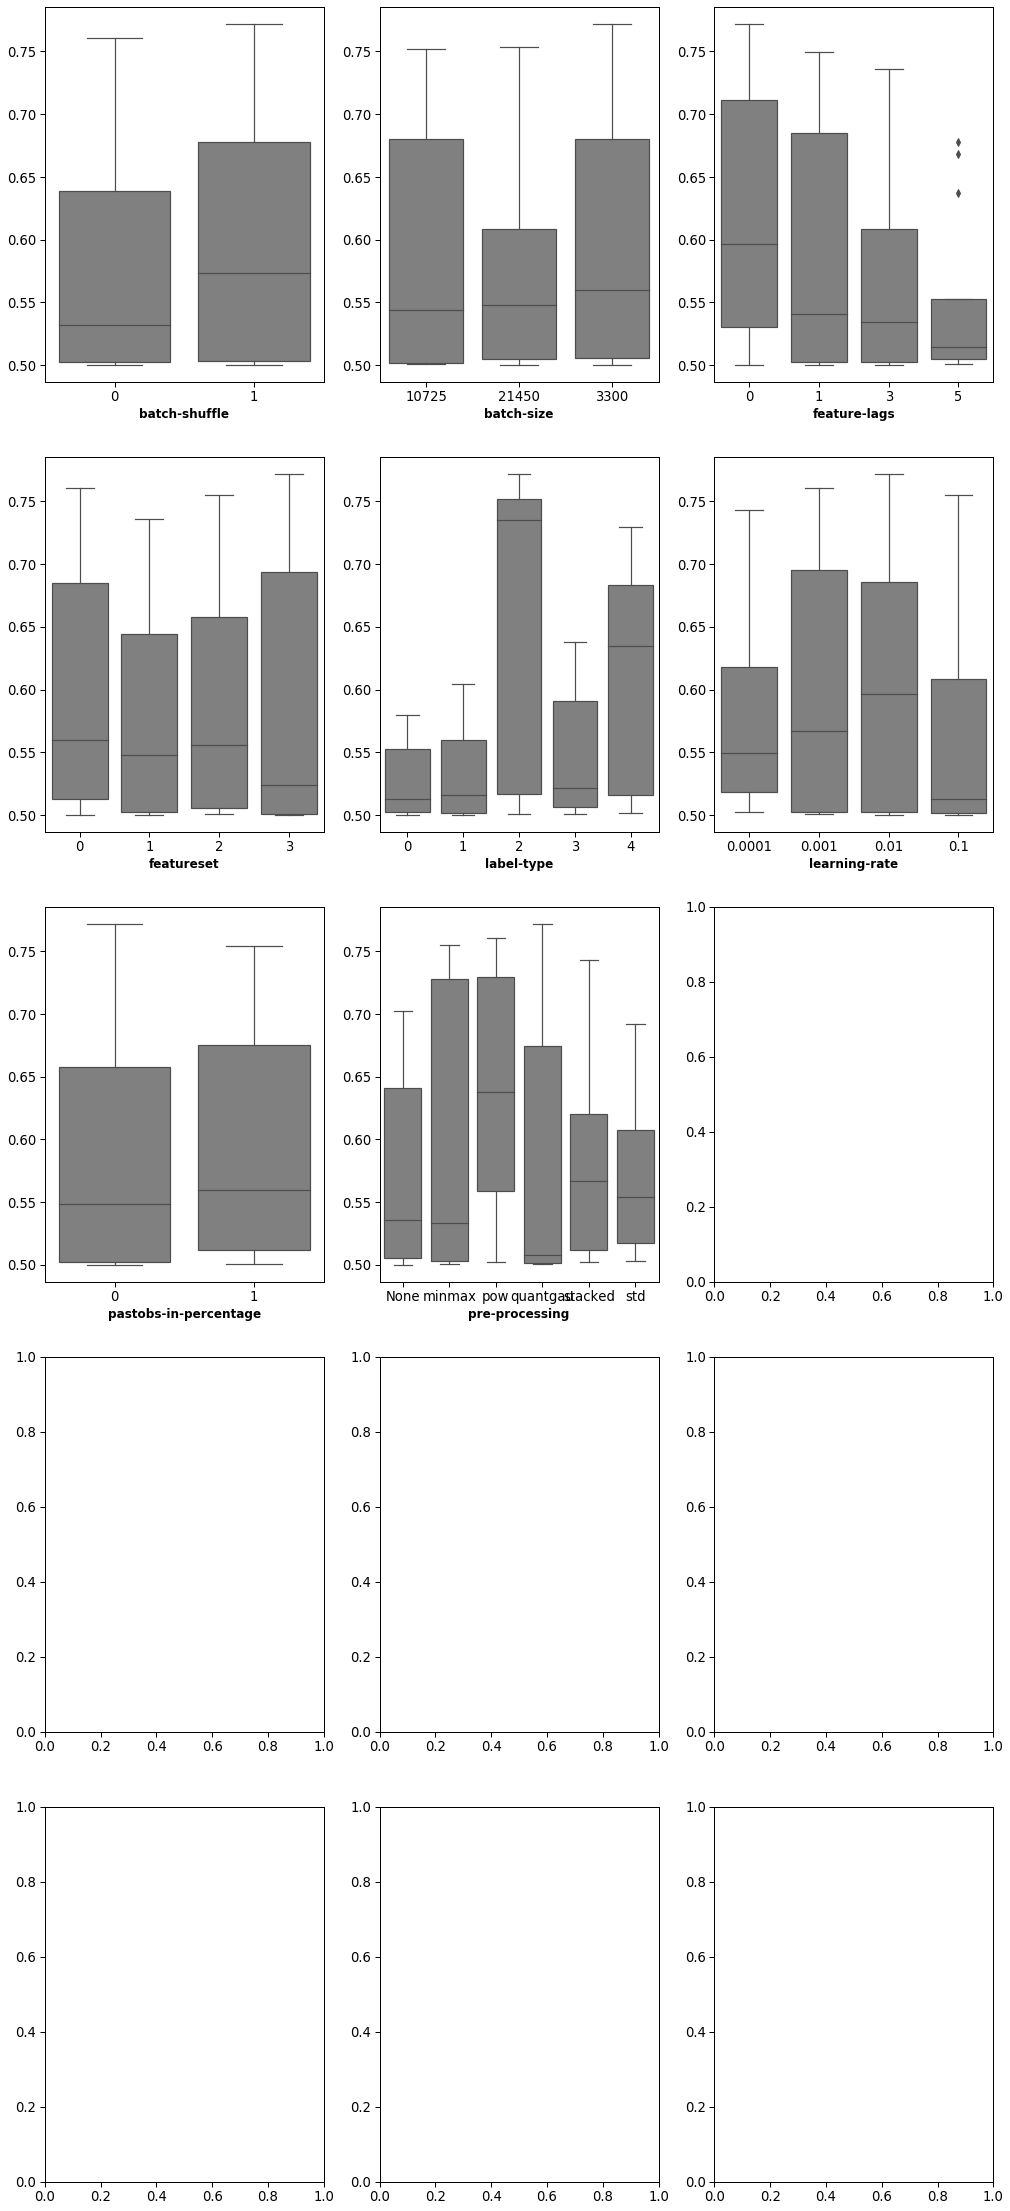

In [148]:
import seaborn as sns

# temp = combined_table_lr[(combined_table_lr.loc[:,'label-type']=='4')&\
#                       (combined_table_lr.loc[:,'loss-from-logits']=='1')&\
#                       (combined_table_lr.AUC>0.5)]

fig,ax = plt.subplots(5,3,figsize=(17,40))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
# plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'font.weight': 'normal'})
k = 0

for i in np.arange(5):
    for j in np.arange(3):
        


        if k < len(cols_to_plot):
            temp_2 = pd.pivot_table(temp,values='AUC',columns=cols_to_plot[k],index='run_id').reset_index()

            # sns.set_theme(style="whitegrid")
            # tips = sns.load_dataset("tips")
            # ax = sns.violinplot(x=tips["total_bill"])
            sns.boxplot(data=temp_2,ax=ax[i,j],color='gray')#,bw='scott'
#             ax[i,j].set_xticks(fontsize=12)
#             ax[i,j].set_yticks(fontsize=12)
            # plt.legend(fontsize=14)
            ax[i,j].set_xlabel(temp_2.columns.name,fontsize=12,fontweight='bold')


            k +=1

plt.show()

# Combined plot

In [154]:
combined_table.columns

Index(['run_id', 'activation-inner', 'activation-output', 'batch-norm',
       'batch-shuffle', 'batch-size', 'dropout-ratio', 'feature-lags',
       'featureset', 'first-layer-neurons', 'label-type', 'learning-rate',
       'n-epochs', 'n-layers', 'nn-type', 'pastobs-in-percentage',
       'pre-processing', 'second-layer-neurons', 'id', 'AUC', 'Accuracy',
       'Loss', 'Train AUC', 'Train Accuracy', 'Train Loss'],
      dtype='object')

In [167]:
label_type = '0'

temp_lr = combined_table_lr[(combined_table_lr.loc[:,'label-type']==label_type)&\
#                       (combined_table_lr.loc[:,'loss-from-logits']=='0')&\
                      (combined_table_lr.AUC>0.5)]

temp_nn = combined_table[(combined_table.loc[:,'label-type']==label_type)&\
#                       (combined_table.loc[:,'nn-type']=='ffnn')&\
                      (combined_table.AUC>0.5)]

######################################## Plotting combined ###########################################

cols_not_plot_lr = []
cols_to_plot_lr = []

for i,col in enumerate(temp_lr.columns):
    if (temp_lr.loc[:,col].unique().shape[0]>1)&(temp_lr.loc[:,col].unique().shape[0]<7):
        cols_to_plot_lr.append(col)
        print(col,': ',temp_lr.loc[:,col].unique(),'\n')
    else:
        cols_not_plot_lr.append(col)

batch-shuffle :  ['0' '1'] 

batch-size :  ['21450' '10725' '3300'] 

feature-lags :  ['3' '1' '0' '5'] 

featureset :  ['0' '2' '1' '3'] 

learning-rate :  ['0.01' '0.001' '0.0001' '0.1'] 

loss-from-logits :  ['0' '1'] 

pastobs-in-percentage :  ['1' '0'] 

pre-processing :  ['stacked' 'std' 'pow' 'quantgau' 'minmax' 'None'] 



In [166]:
######################################### Plot the remaining NN columns separately ######################################

cols_not_plot_nn = []
cols_to_plot_nn = []

for i,col in enumerate(temp_nn.columns):
    if ((temp_nn.loc[:,col].unique().shape[0]>1)&\
        (temp_nn.loc[:,col].unique().shape[0]<7)):
        cols_to_plot_nn.append(col)
        print(col,': ',temp_nn.loc[:,col].unique(),'\n')
    else:
        cols_not_plot_nn.append(col)

activation-inner :  ['relu' 'tanh' 'leakyrelu' 'sigmoid'] 

batch-norm :  ['1' '0'] 

batch-shuffle :  ['0' '1'] 

batch-size :  ['21450' '3300' '10725'] 

dropout-ratio :  ['0.1' '0' '0.4' '0.3' '0.2' '0.5'] 

feature-lags :  ['5' '0' '1' '3'] 

featureset :  ['1' '3' '0' '2'] 

first-layer-neurons :  ['128' '64' '32'] 

learning-rate :  ['0.001' '0.01' '0.1' '0.0001'] 

n-layers :  ['2' '3' '4' '1'] 

pastobs-in-percentage :  ['0' '1'] 

pre-processing :  ['quantgau' 'std' 'pow' 'stacked' 'None' 'minmax'] 

second-layer-neurons :  ['128' '32' '64'] 



In [211]:
cols_to_plot_combined = set(cols_to_plot_lr).intersection(set(cols_to_plot_nn))
cols_to_plot_combined = list(cols_to_plot_combined)

cols_to_plot_nn_only = set(cols_to_plot_nn).difference(set(cols_to_plot_combined))
cols_to_plot_nn_only = list(cols_to_plot_nn_only)

cols_to_plot_lr_only = set(cols_to_plot_lr).difference(set(cols_to_plot_combined))
cols_to_plot_lr_only = list(cols_to_plot_lr_only)

In [212]:
print('For combined plot: \n\n',cols_to_plot_combined,'\n\nLength:',len(cols_to_plot_combined),'\n')
print('For NN plot: \n\n',cols_to_plot_nn_only,'\n\nLength:',len(cols_to_plot_nn_only),'\n')
print('For LR plot: \n\n',cols_to_plot_lr_only,'\n\nLength:',len(cols_to_plot_lr_only),'\n')

For combined plot: 

 ['batch-shuffle', 'learning-rate', 'pastobs-in-percentage', 'batch-size', 'feature-lags', 'pre-processing', 'featureset'] 

Length: 7 

For NN plot: 

 ['activation-inner', 'second-layer-neurons', 'first-layer-neurons', 'n-layers', 'batch-norm', 'dropout-ratio'] 

Length: 6 

For LR plot: 

 ['loss-from-logits'] 

Length: 1 



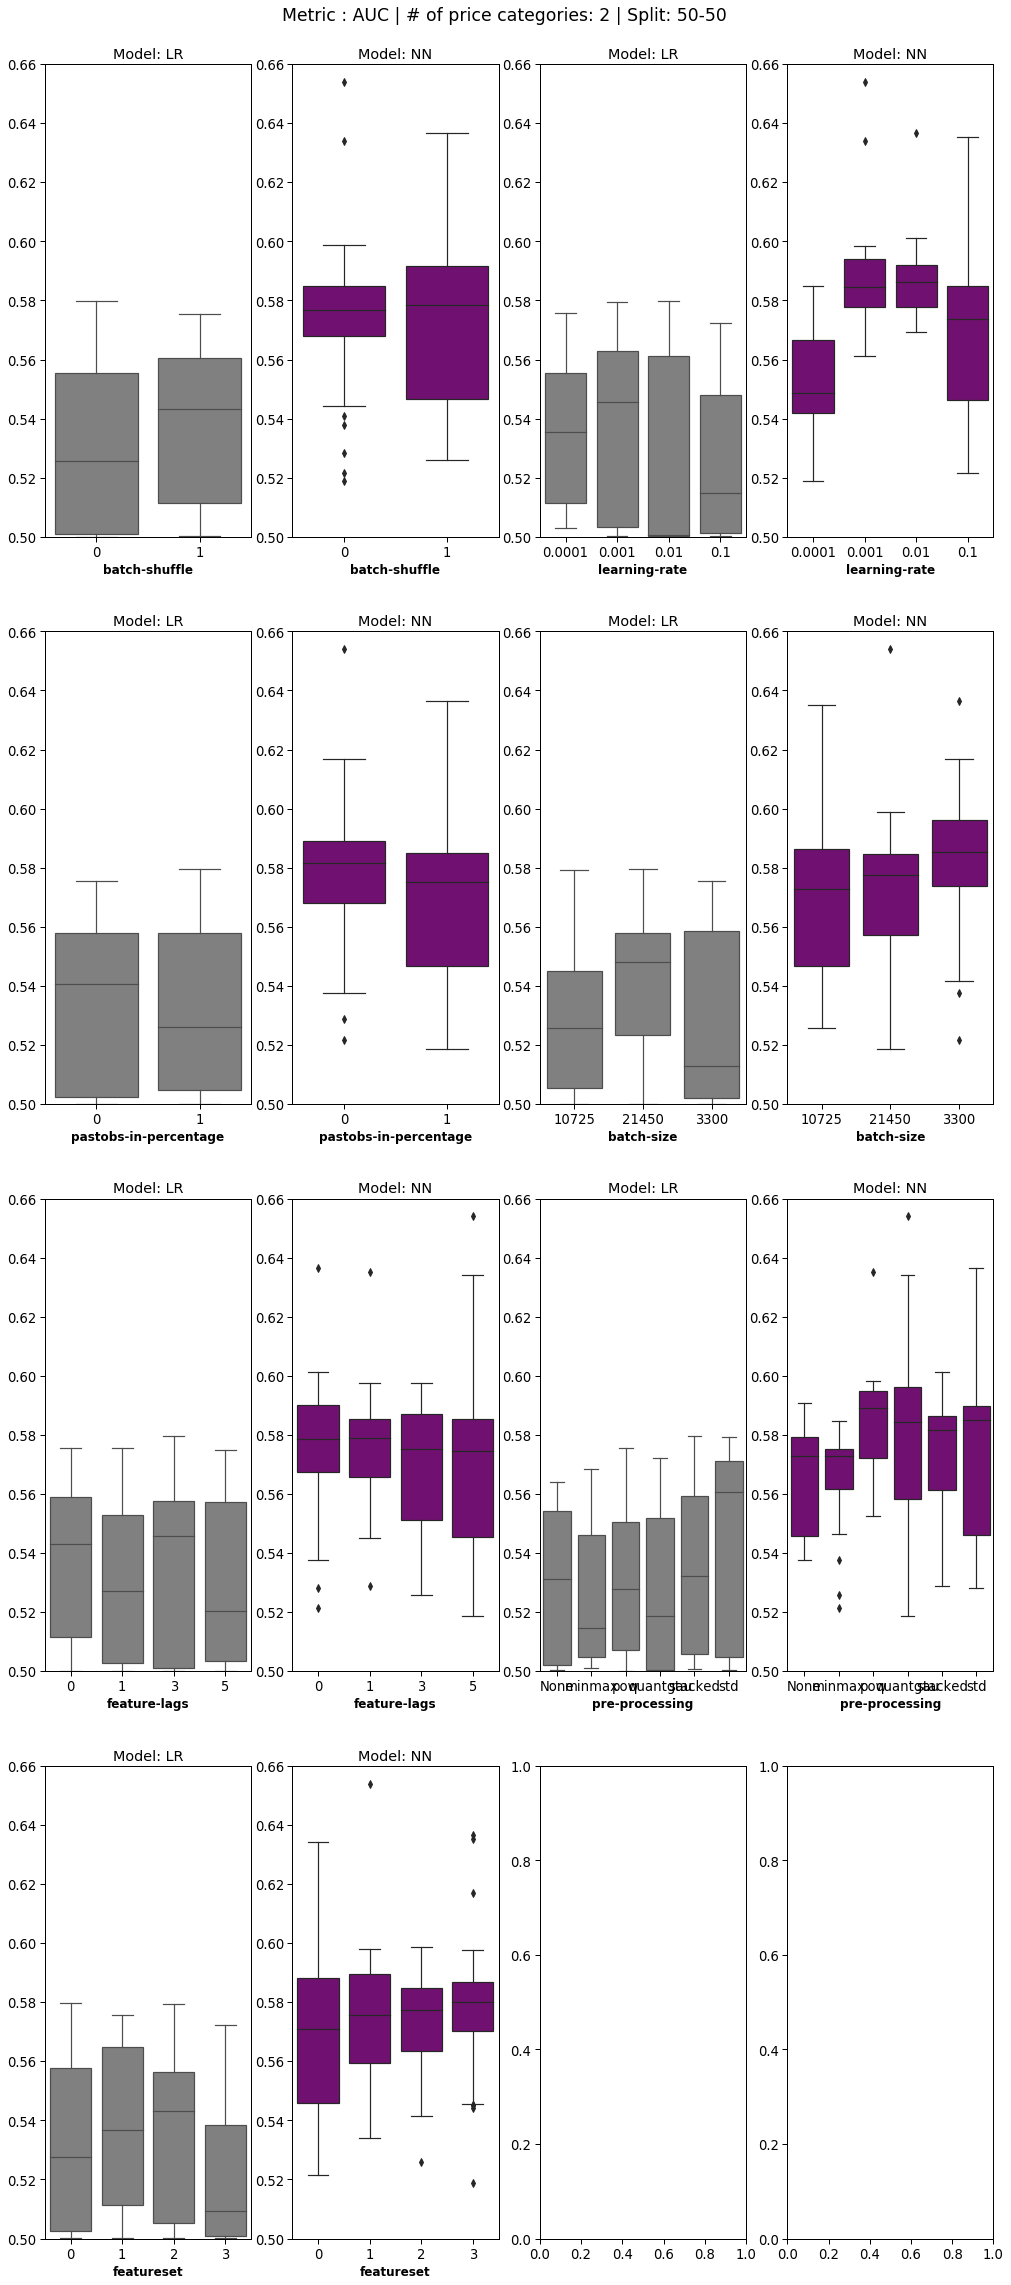

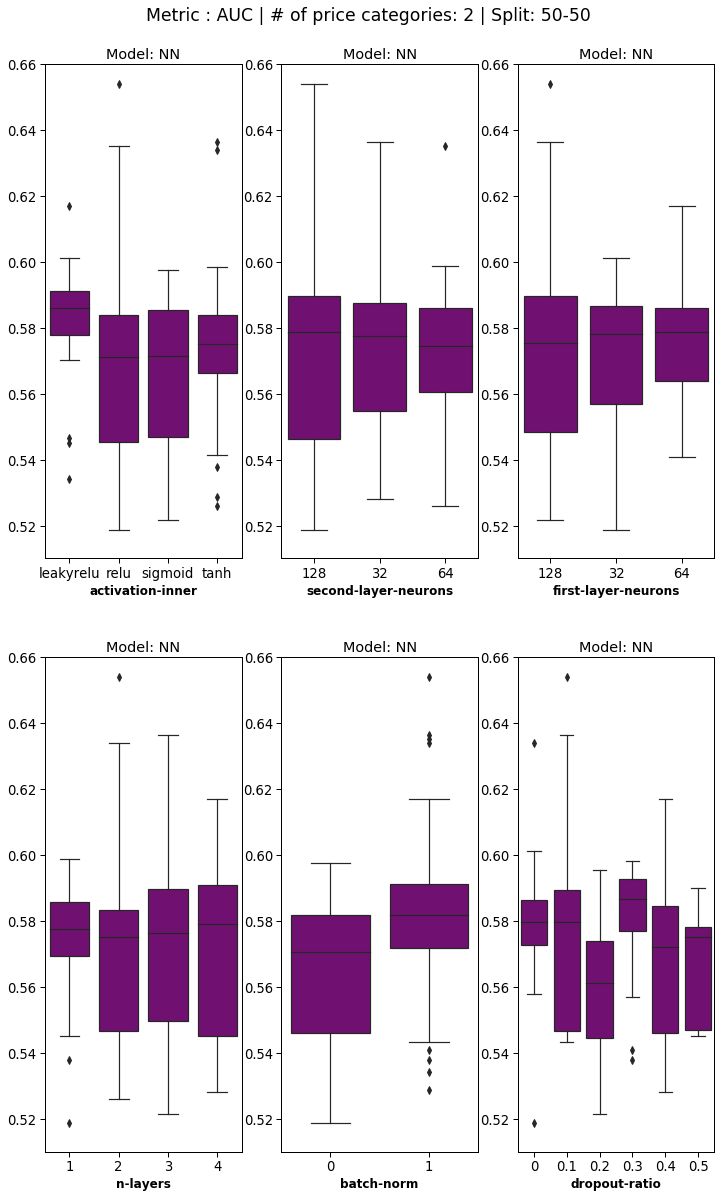

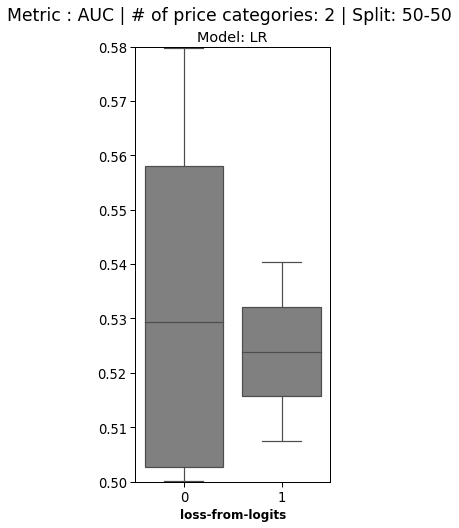

In [223]:
import seaborn as sns

## Two models; plotted next to each other, so at least double up the length above 
# (acutal number should depend on the layout of the plot)
plot_height_combined =  4
plot_width_combined = 4

## Two models; plotted next to each other, so at least double up the length above 
# (acutal number should depend on the layout of the plot)
plot_height_nn =  2
plot_width_nn = 3

## Two models; plotted next to each other, so at least double up the length above 
# (acutal number should depend on the layout of the plot)
plot_height_lr =  1
plot_width_lr = 1

save_plots = False
save_path = '../../../Google Drev/Thesis/Figures/model params'#'../../Figures_Thesis/model_params'
save_date = '20201222'


metric = 'AUC'

for label_type in ['0','1','2','3','4']

fig,ax = plt.subplots(plot_height,
                      plot_width,
                      figsize=(17,40))

sns.set_context("paper", font_scale=1.5)

k = 0

######################################### Plotting intersecting variables #########################################

for i in np.arange(plot_height):
    for j in np.arange(0,plot_width,2):
        
        if k < len(cols_to_plot_combined):
            temp_lr_2 = pd.pivot_table(temp_lr,values=metric,columns=cols_to_plot_combined[k],index='run_id').reset_index()
            temp_nn_2 = pd.pivot_table(temp_nn,values=metric,columns=cols_to_plot_combined[k],index='run_id').reset_index()

            sns.boxplot(data=temp_lr_2,ax=ax[i,j],color='gray')#,bw='scott'
            sns.boxplot(data=temp_nn_2,ax=ax[i,j+1],color='purple')#,bw='scott'

            ### Set title
            ax[i,j].set_title('Model: LR')
            ax[i,j+1].set_title('Model: NN')
            
            ### Set y-axis
            ax[i,j].set_ylim(min(np.floor(temp_lr_2.iloc[:,1:].min().min()*100)/100,
                                 np.floor(temp_nn_2.iloc[:,1:].min().min()*100)/100),
                             max(np.ceil(temp_lr_2.iloc[:,1:].max().max()*100)/100,
                                 np.ceil(temp_nn_2.iloc[:,1:].max().max()*100)/100))
            ax[i,j+1].set_ylim(min(np.floor(temp_lr_2.iloc[:,1:].min().min()*100)/100,
                                 np.floor(temp_nn_2.iloc[:,1:].min().min()*100)/100),
                             max(np.ceil(temp_lr_2.iloc[:,1:].max().max()*100)/100,
                                 np.ceil(temp_nn_2.iloc[:,1:].max().max()*100)/100))
            
            ### Set x-label
            ax[i,j].set_xlabel(temp_lr_2.columns.name,fontsize=12,fontweight='bold')
            ax[i,j+1].set_xlabel(temp_nn_2.columns.name,fontsize=12,fontweight='bold')


            k +=1
fig.suptitle('Metric : {} | {}'.format(metric,title_holder[str(label_type)]),y=0.90)

if save_plots:
    plt.savefig(save_path+'/combined_plot_'+save_date+'.png')
else:
    plt.show()

######################################### Plotting variables only applying for NN #########################################
k = 0

fig,ax = plt.subplots(plot_height_nn,
                      plot_width_nn,
                      figsize=(12,20))

for i in np.arange(plot_height_nn):
    for j in np.arange(plot_width_nn):
        
        if k < len(cols_to_plot_nn_only):
            temp_nn_2 = pd.pivot_table(temp_nn,values=metric,columns=cols_to_plot_nn_only[k],index='run_id').reset_index()

            sns.boxplot(data=temp_nn_2,ax=ax[i,j],color='purple')#,bw='scott'

            ### Set title
            ax[i,j].set_title('Model: NN')
            
            ### Set y-axis
            ax[i,j].set_ylim(np.floor(temp_nn_2.iloc[:,1:].min().min()*100)/100,
                                 np.ceil(temp_nn_2.iloc[:,1:].max().max()*100)/100)
            
            ### Set x-label
            ax[i,j].set_xlabel(temp_nn_2.columns.name,fontsize=12,fontweight='bold')

            k +=1
            
fig.suptitle('Metric : {} | {}'.format(metric,title_holder[str(label_type)]),y=0.92)

if save_plots:
    plt.savefig(save_path+'/nn_plot_'+save_date+'.png')
else:
    plt.show()
    
######################################### Plotting variables only applying for LR #########################################
k = 0

fig,ax = plt.subplots(plot_height_lr,
                      plot_width_lr,
                      figsize=(3.5,8))

for i in np.arange(plot_height_lr):
    for j in np.arange(plot_width_lr):
        
        if k < len(cols_to_plot_lr_only):
            temp_lr_2 = pd.pivot_table(temp_lr,values=metric,columns=cols_to_plot_lr_only[k],index='run_id').reset_index()

            sns.boxplot(data=temp_lr_2,ax=ax,color='gray')#,bw='scott'

            ### Set title
            ax.set_title('Model: LR')
            
            ### Set y-axis
            ax.set_ylim(np.floor(temp_lr_2.iloc[:,1:].min().min()*100)/100,
                             np.ceil(temp_lr_2.iloc[:,1:].max().max()*100)/100)
            
            ### Set x-label
            ax.set_xlabel(temp_lr_2.columns.name,fontsize=12,fontweight='bold')

            k +=1
            
fig.suptitle('Metric : {} | {}'.format(metric,title_holder[str(label_type)]),y=0.95)

if save_plots:
    plt.savefig(save_path+'/lr_plot_'+save_date+'.png')
else:
    plt.show()

# Plotting all label types at once

For combined plot: 

 ['batch-shuffle', 'learning-rate', 'pastobs-in-percentage', 'batch-size', 'feature-lags', 'pre-processing', 'featureset'] 

Length: 7 

For NN plot: 

 ['activation-inner', 'second-layer-neurons', 'first-layer-neurons', 'n-layers', 'batch-norm', 'dropout-ratio'] 

Length: 6 

For LR plot: 

 ['loss-from-logits'] 

Length: 1 

For combined plot: 

 ['batch-shuffle', 'learning-rate', 'pastobs-in-percentage', 'batch-size', 'feature-lags', 'pre-processing', 'featureset'] 

Length: 7 

For NN plot: 

 ['activation-inner', 'activation-output', 'second-layer-neurons', 'first-layer-neurons', 'n-layers', 'batch-norm', 'dropout-ratio'] 

Length: 7 

For LR plot: 

 [] 

Length: 0 

For combined plot: 

 ['batch-shuffle', 'learning-rate', 'pastobs-in-percentage', 'batch-size', 'feature-lags', 'pre-processing', 'featureset'] 

Length: 7 

For NN plot: 

 ['activation-inner', 'activation-output', 'second-layer-neurons', 'first-layer-neurons', 'n-layers', 'batch-norm', 'dropout

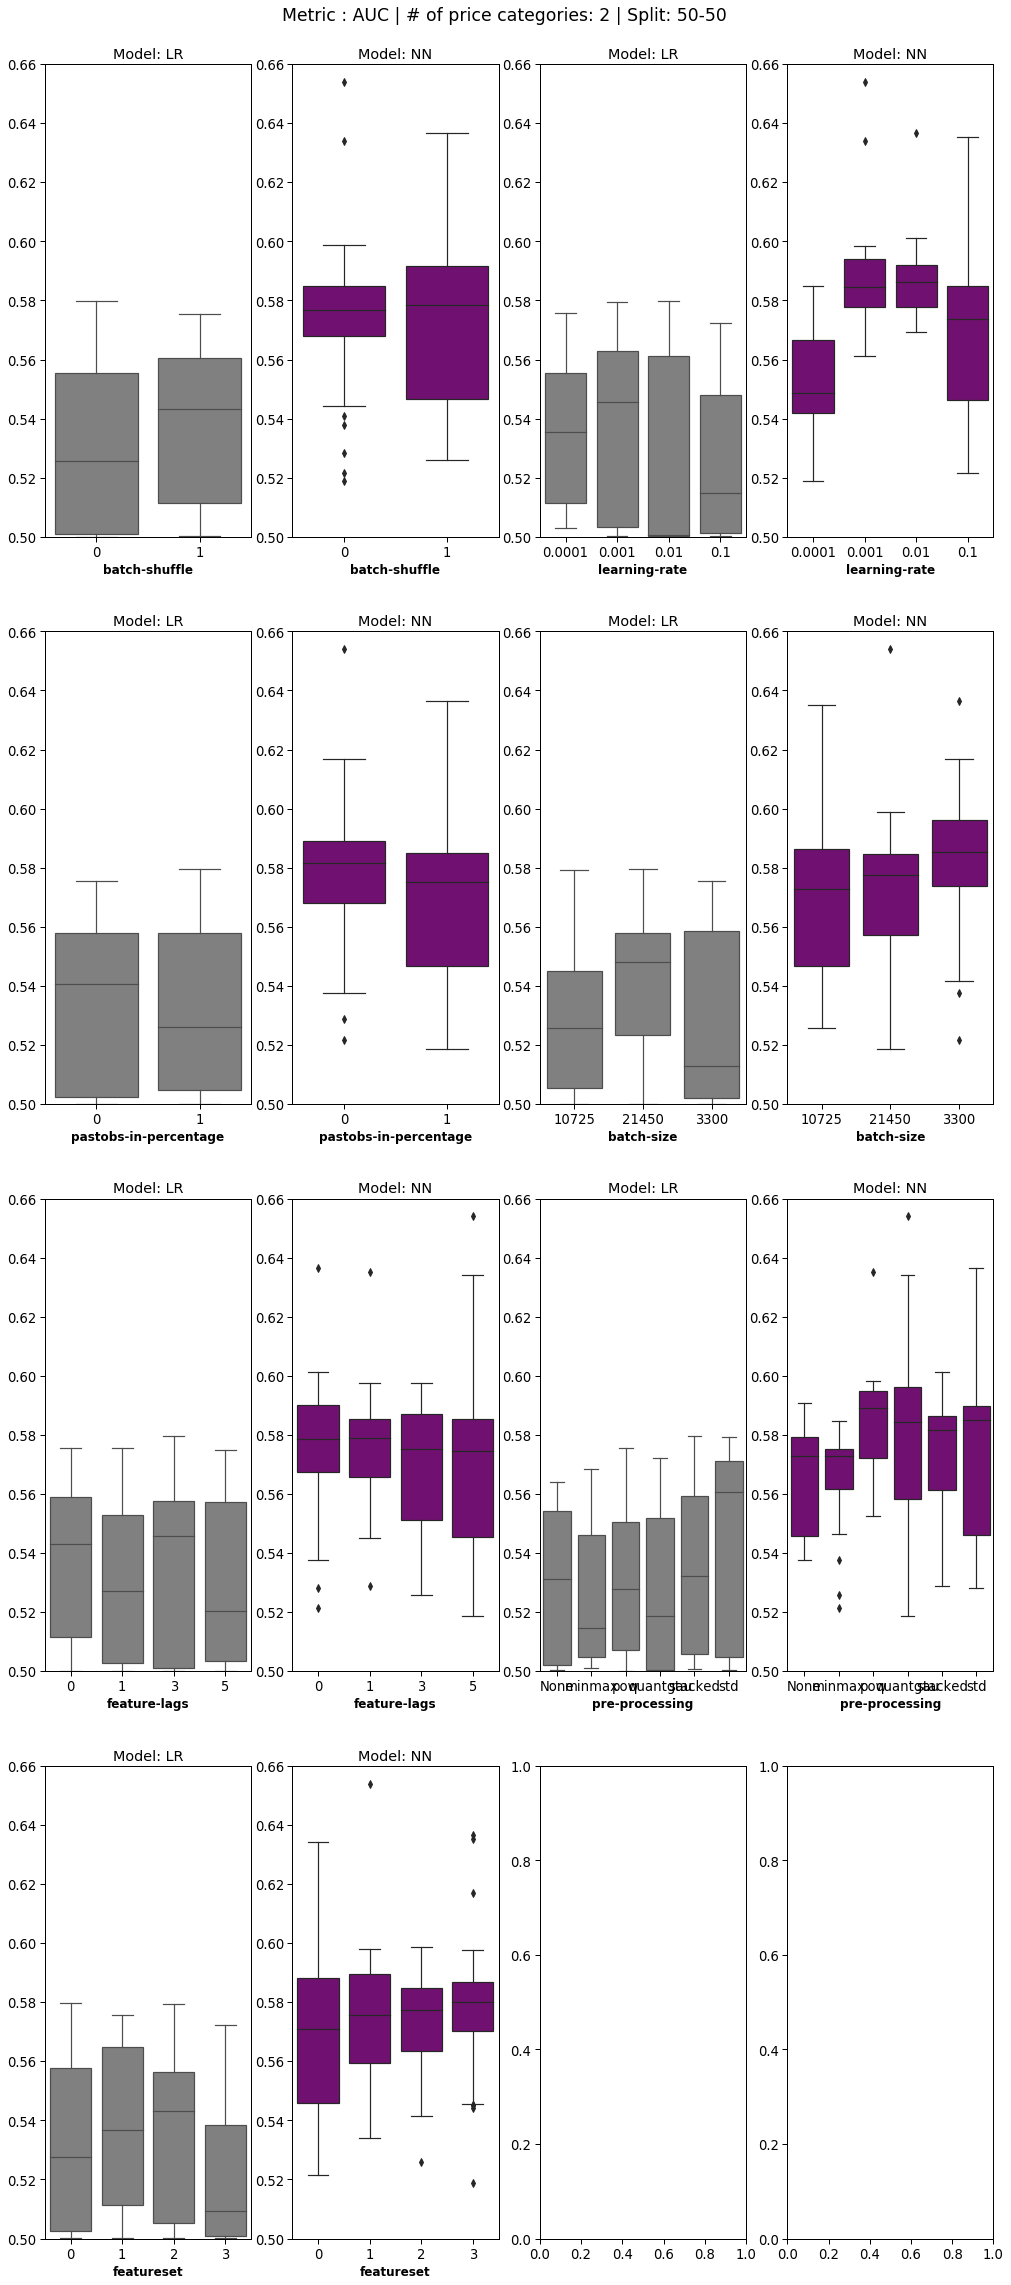

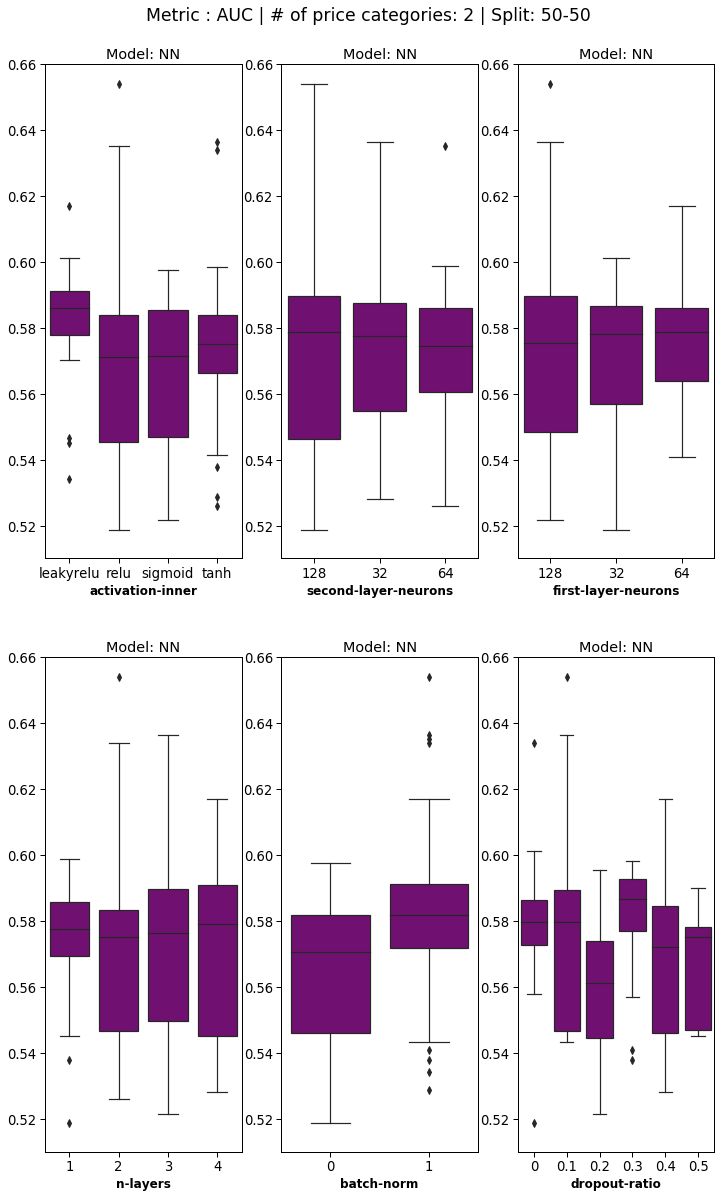

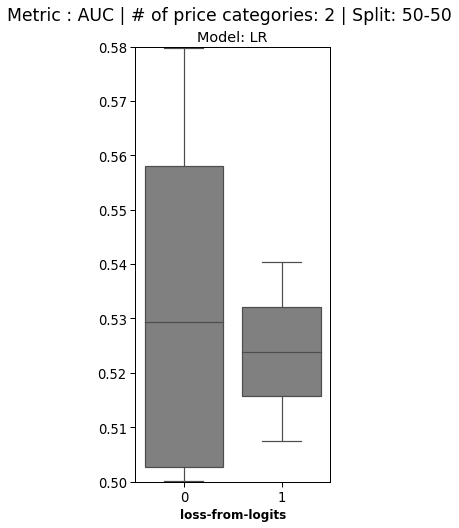

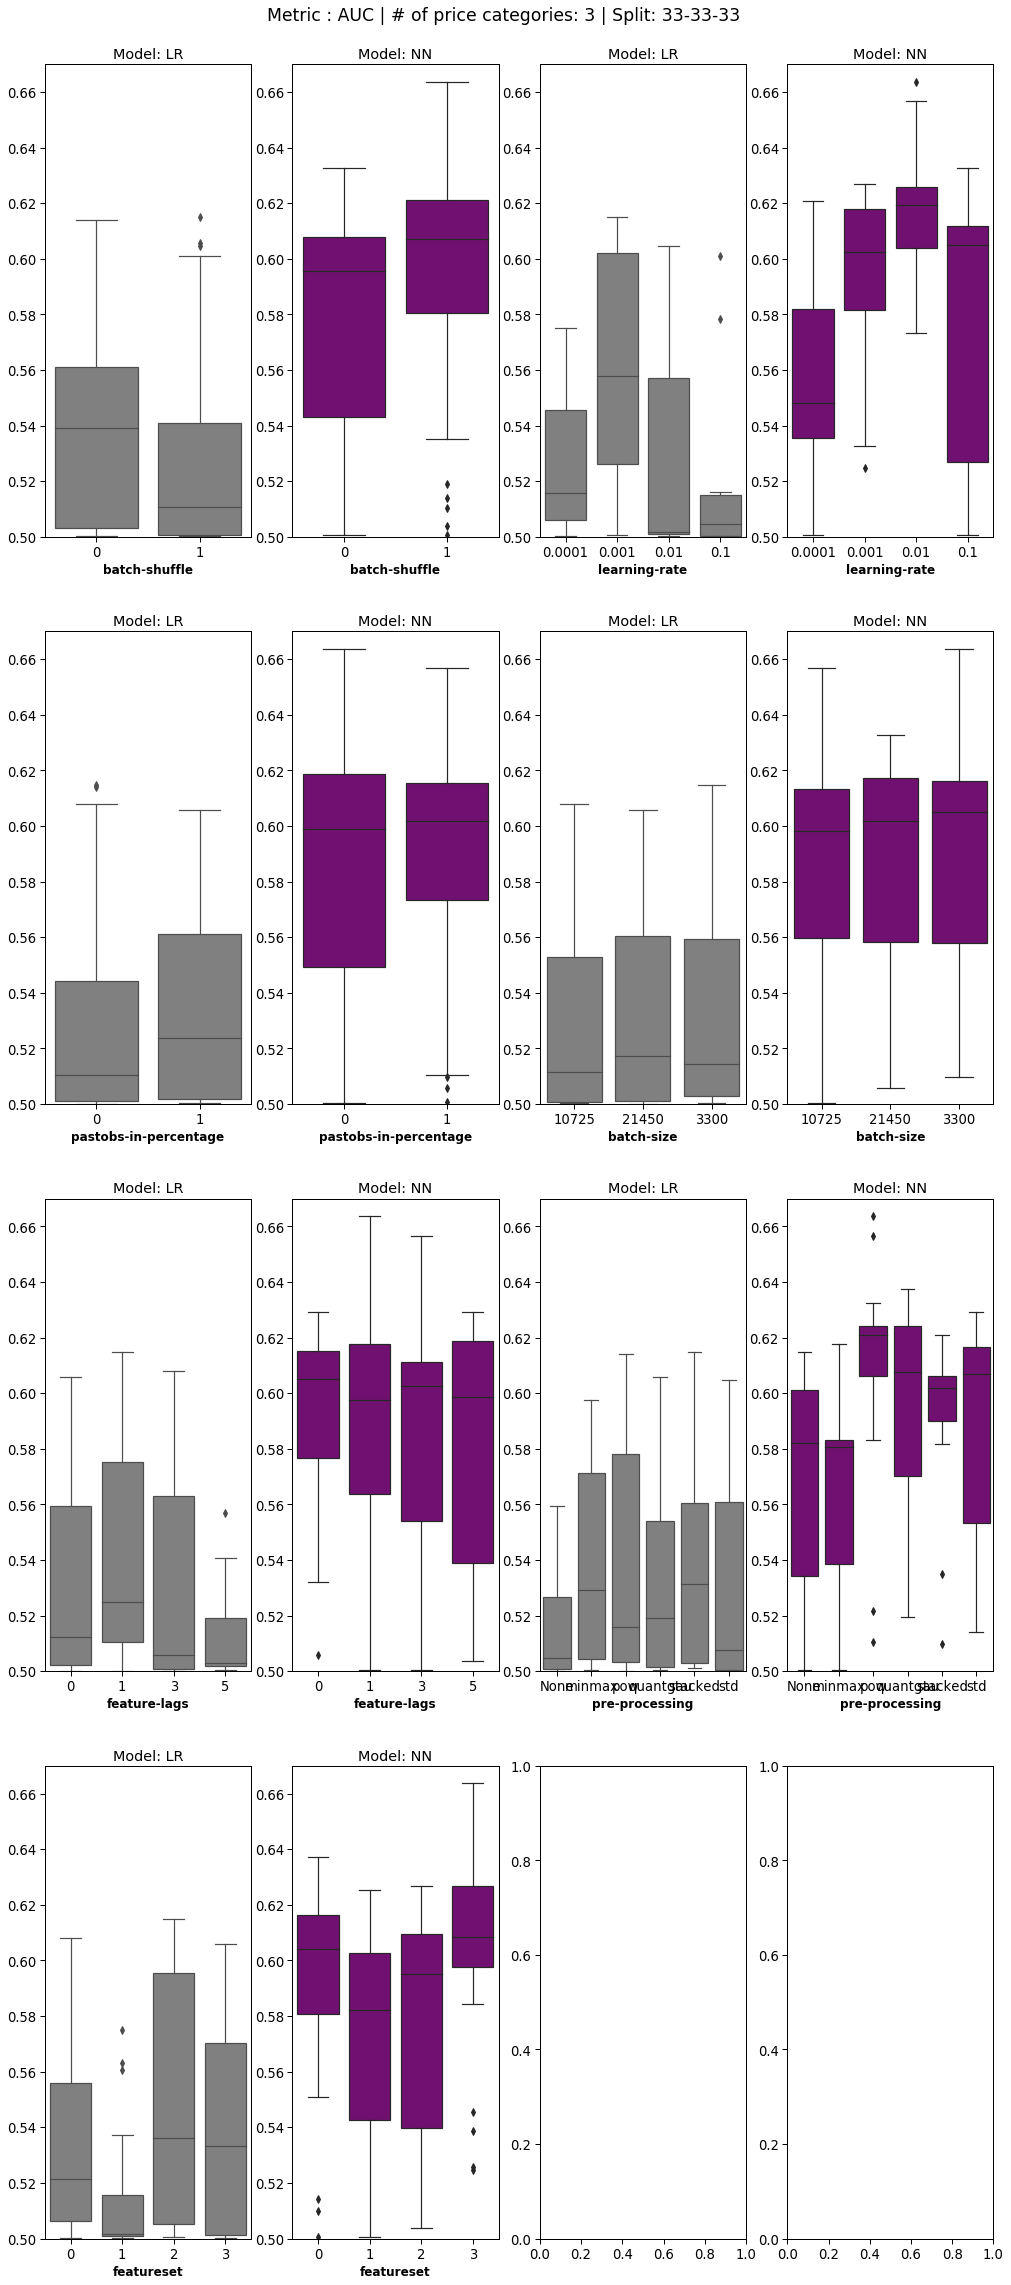

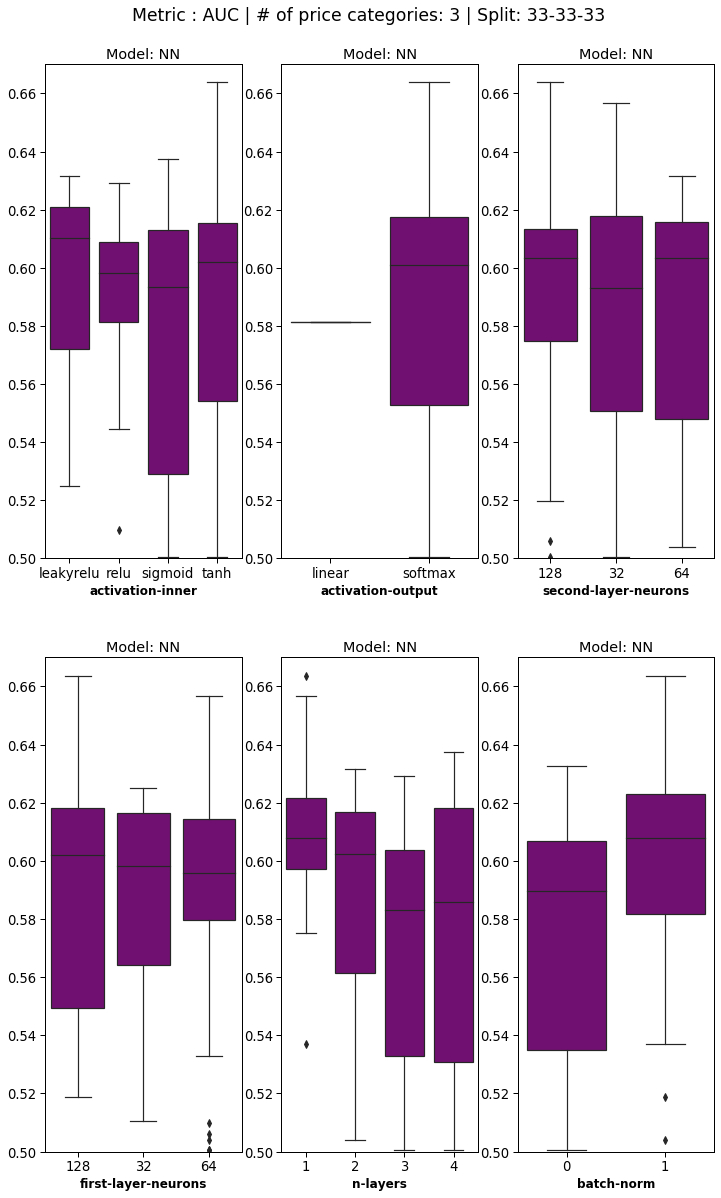

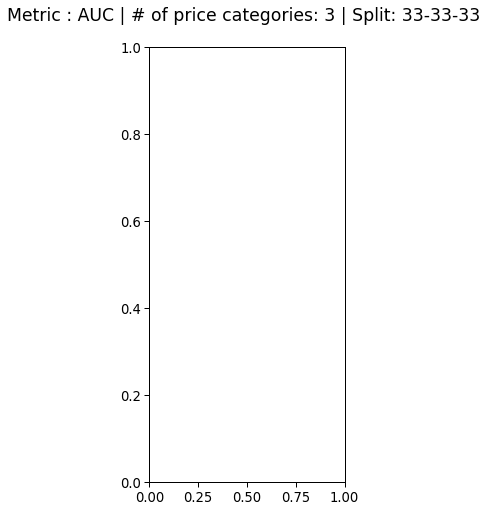

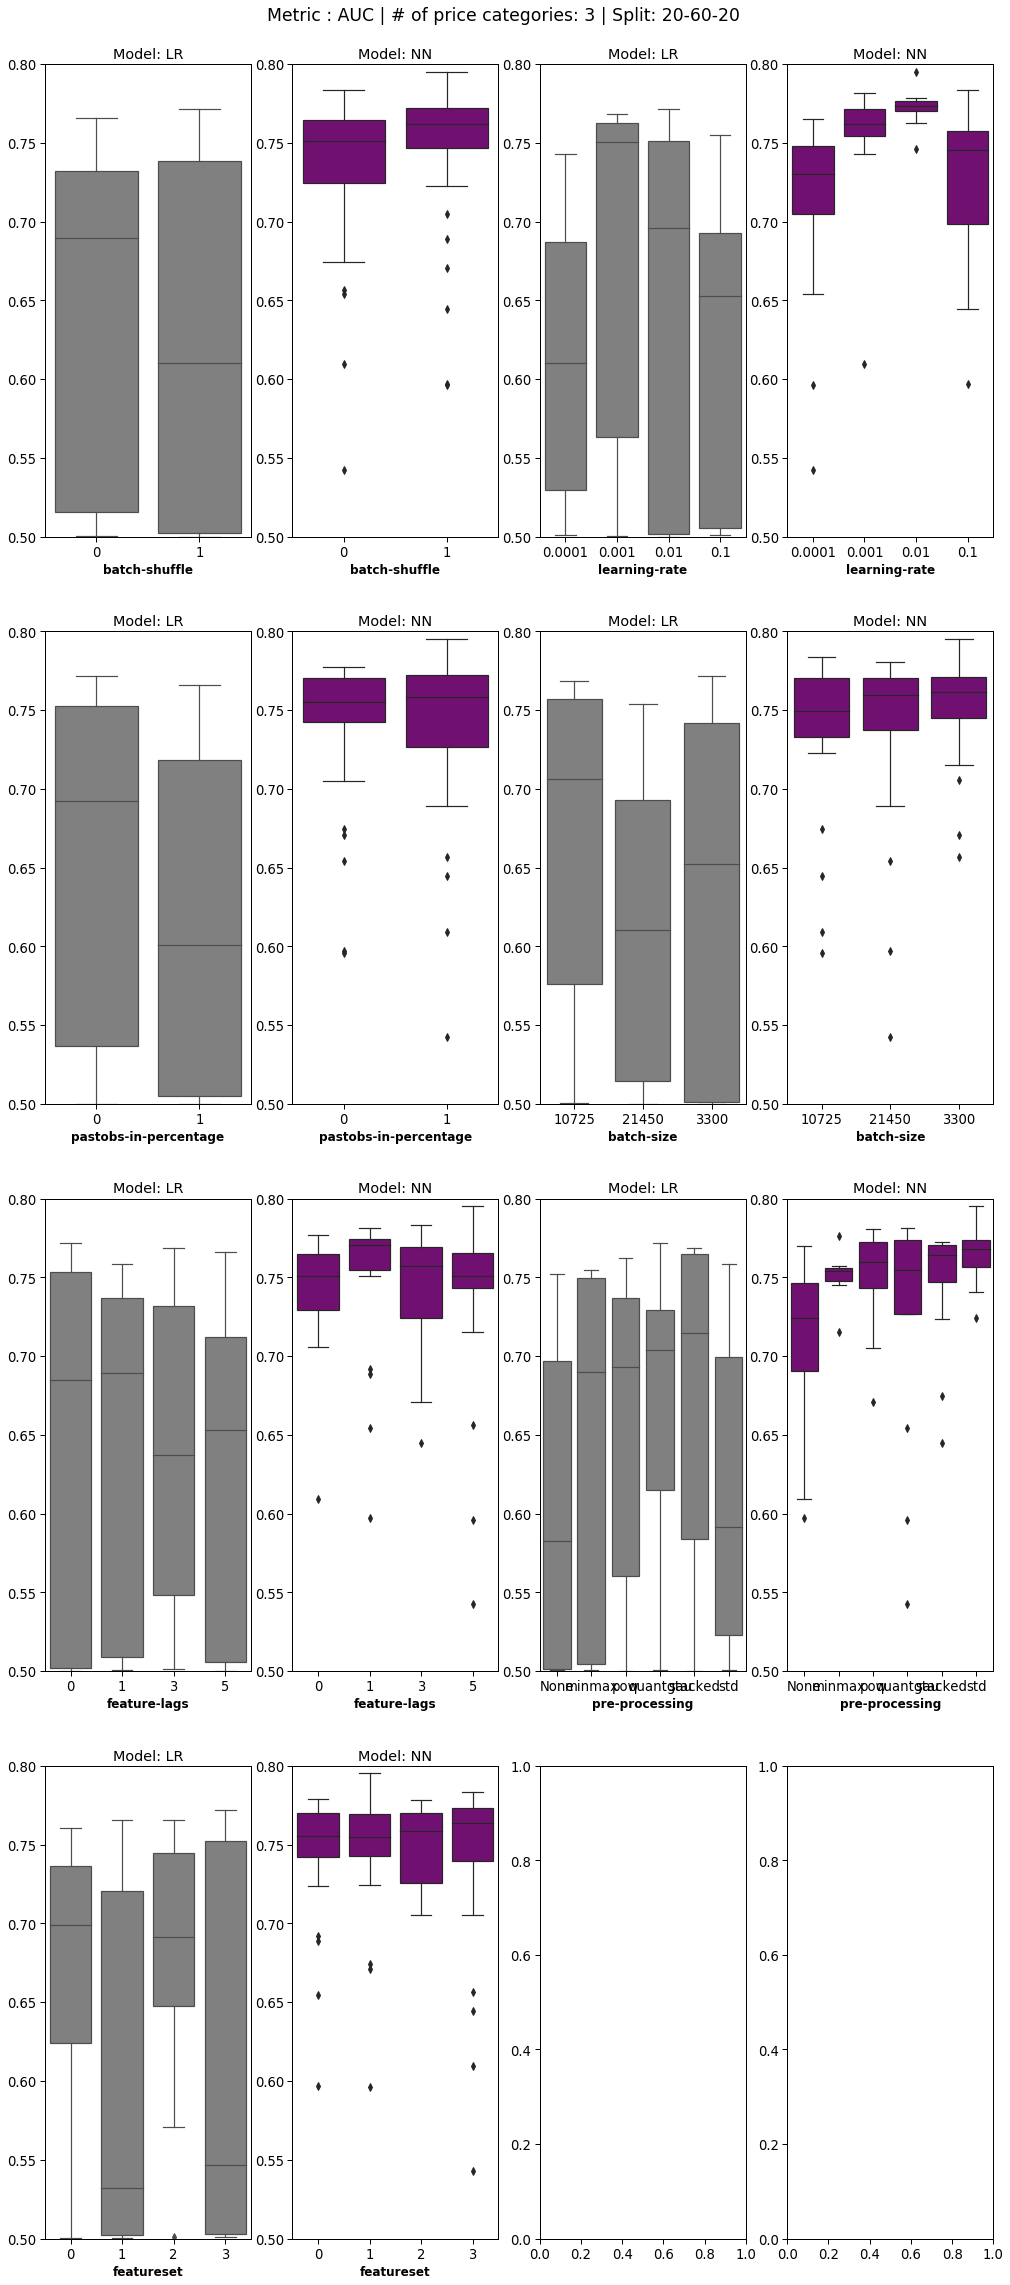

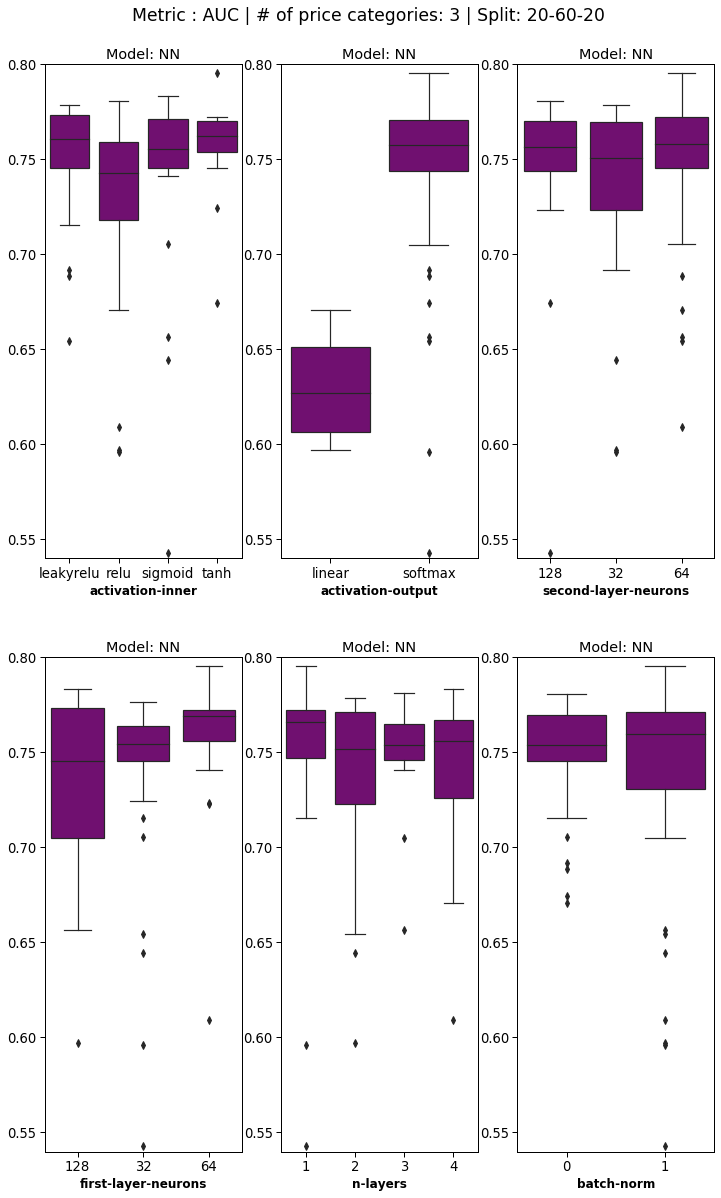

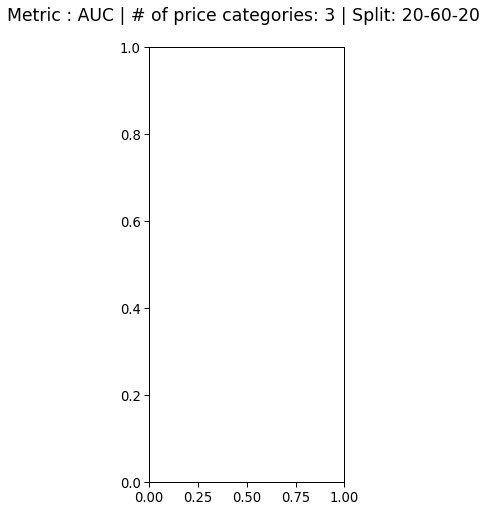

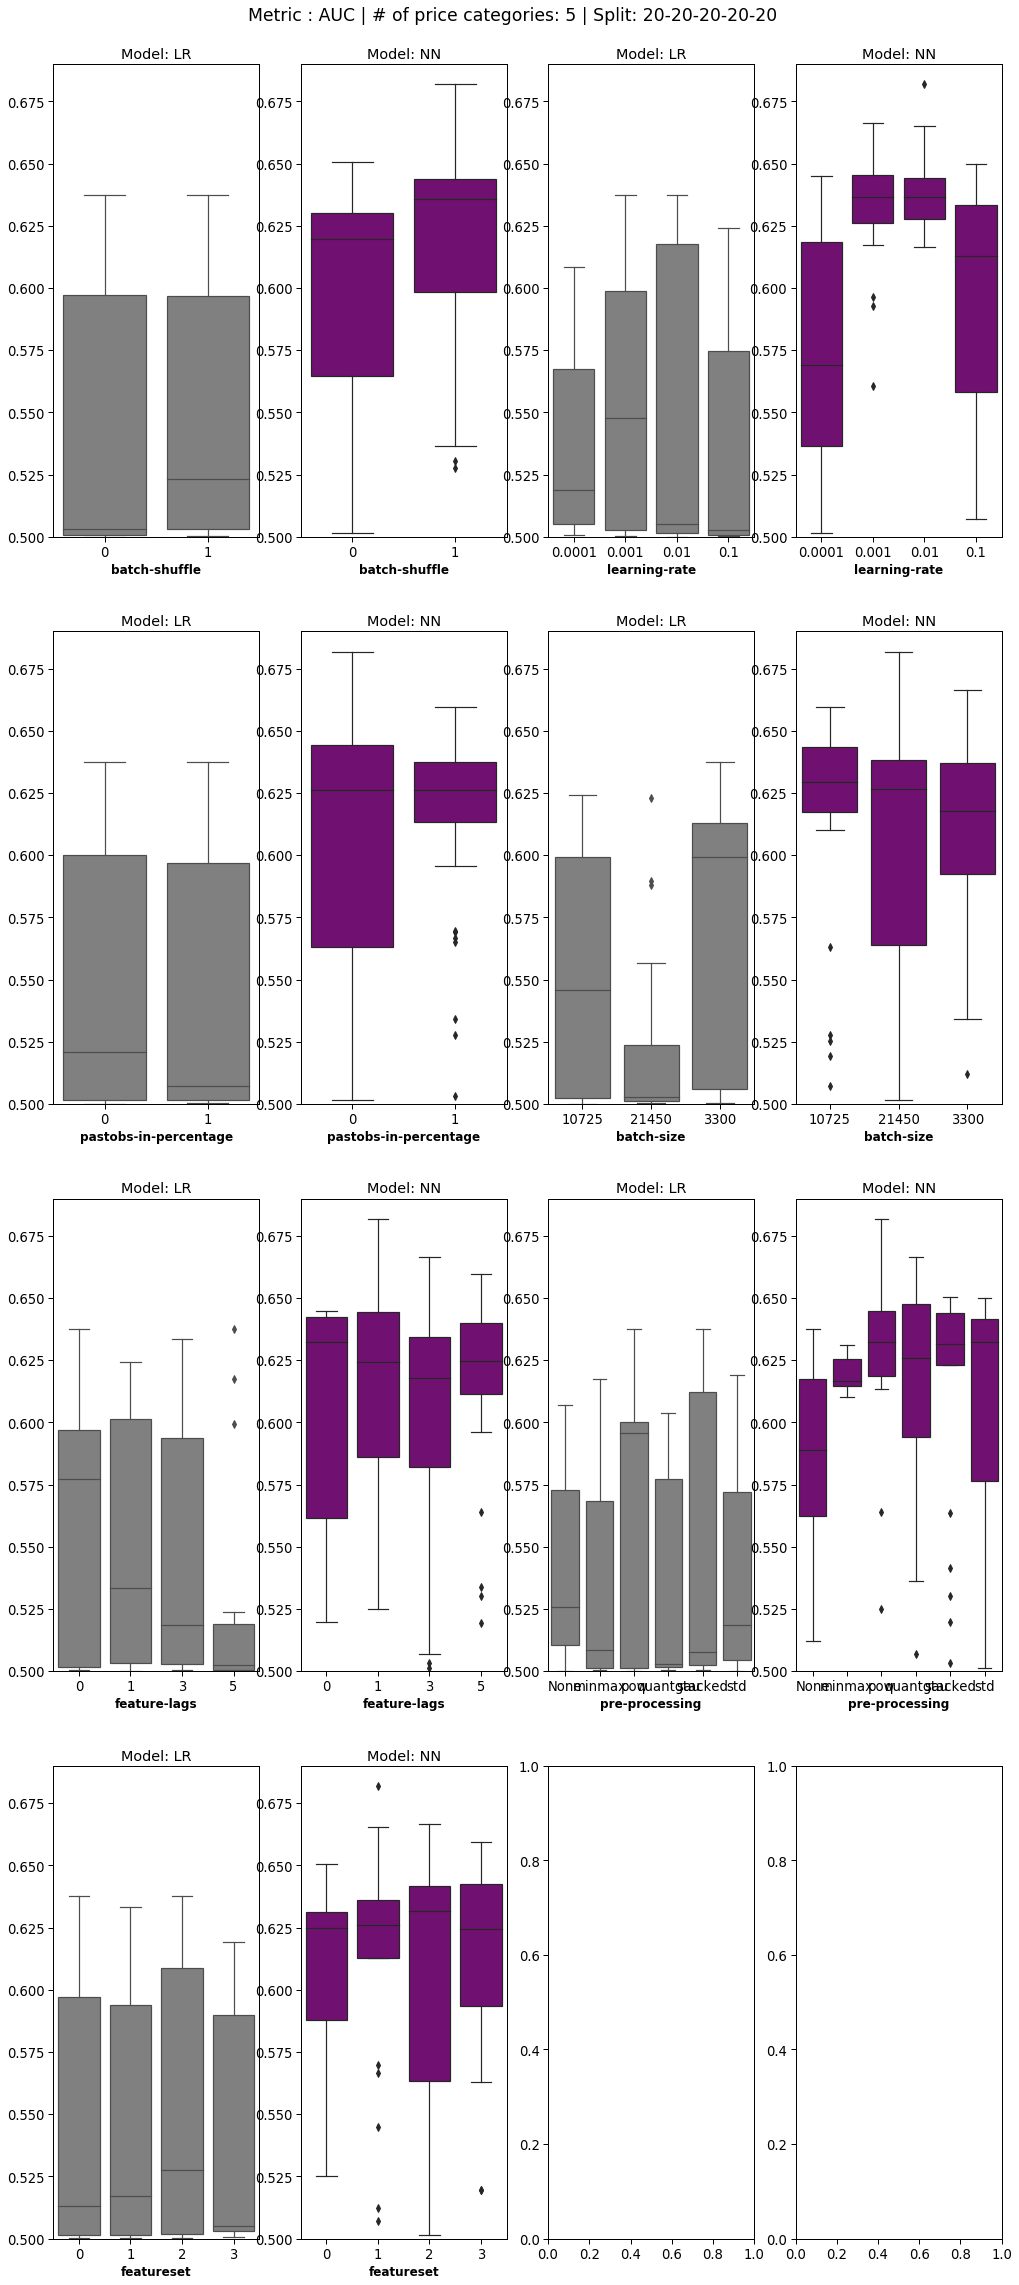

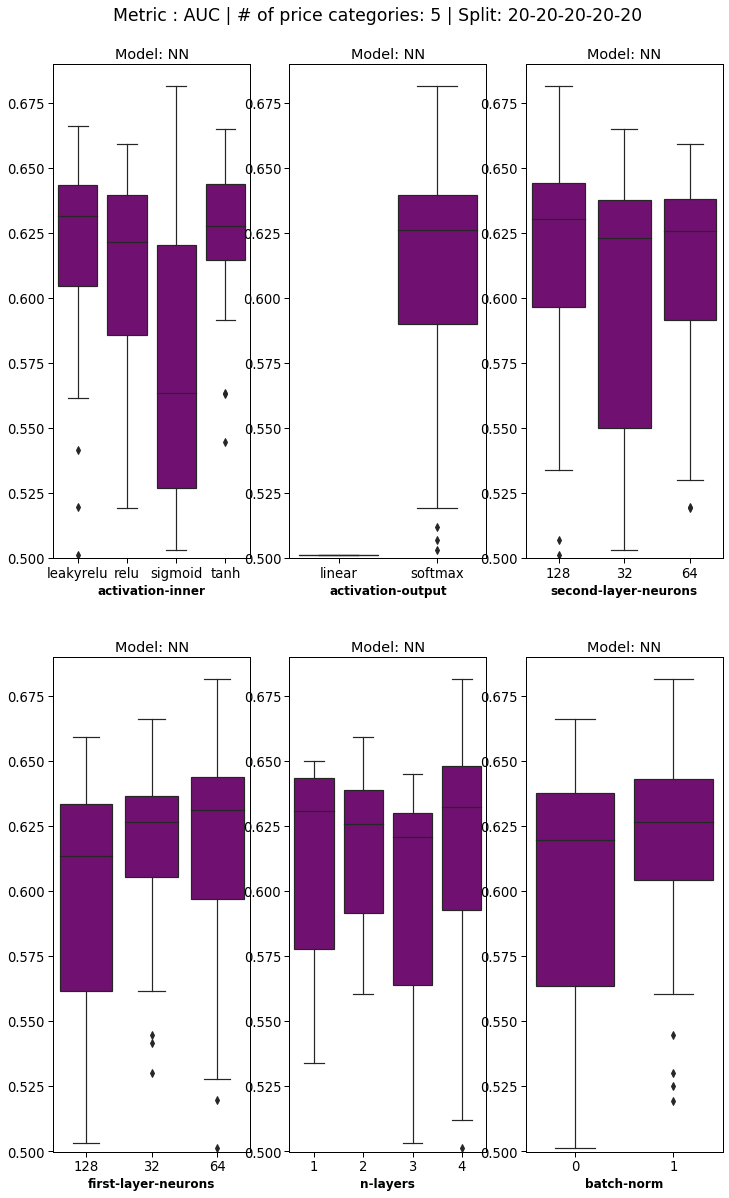

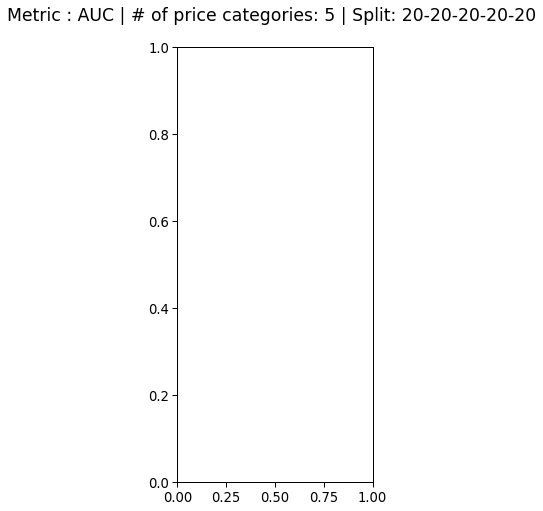

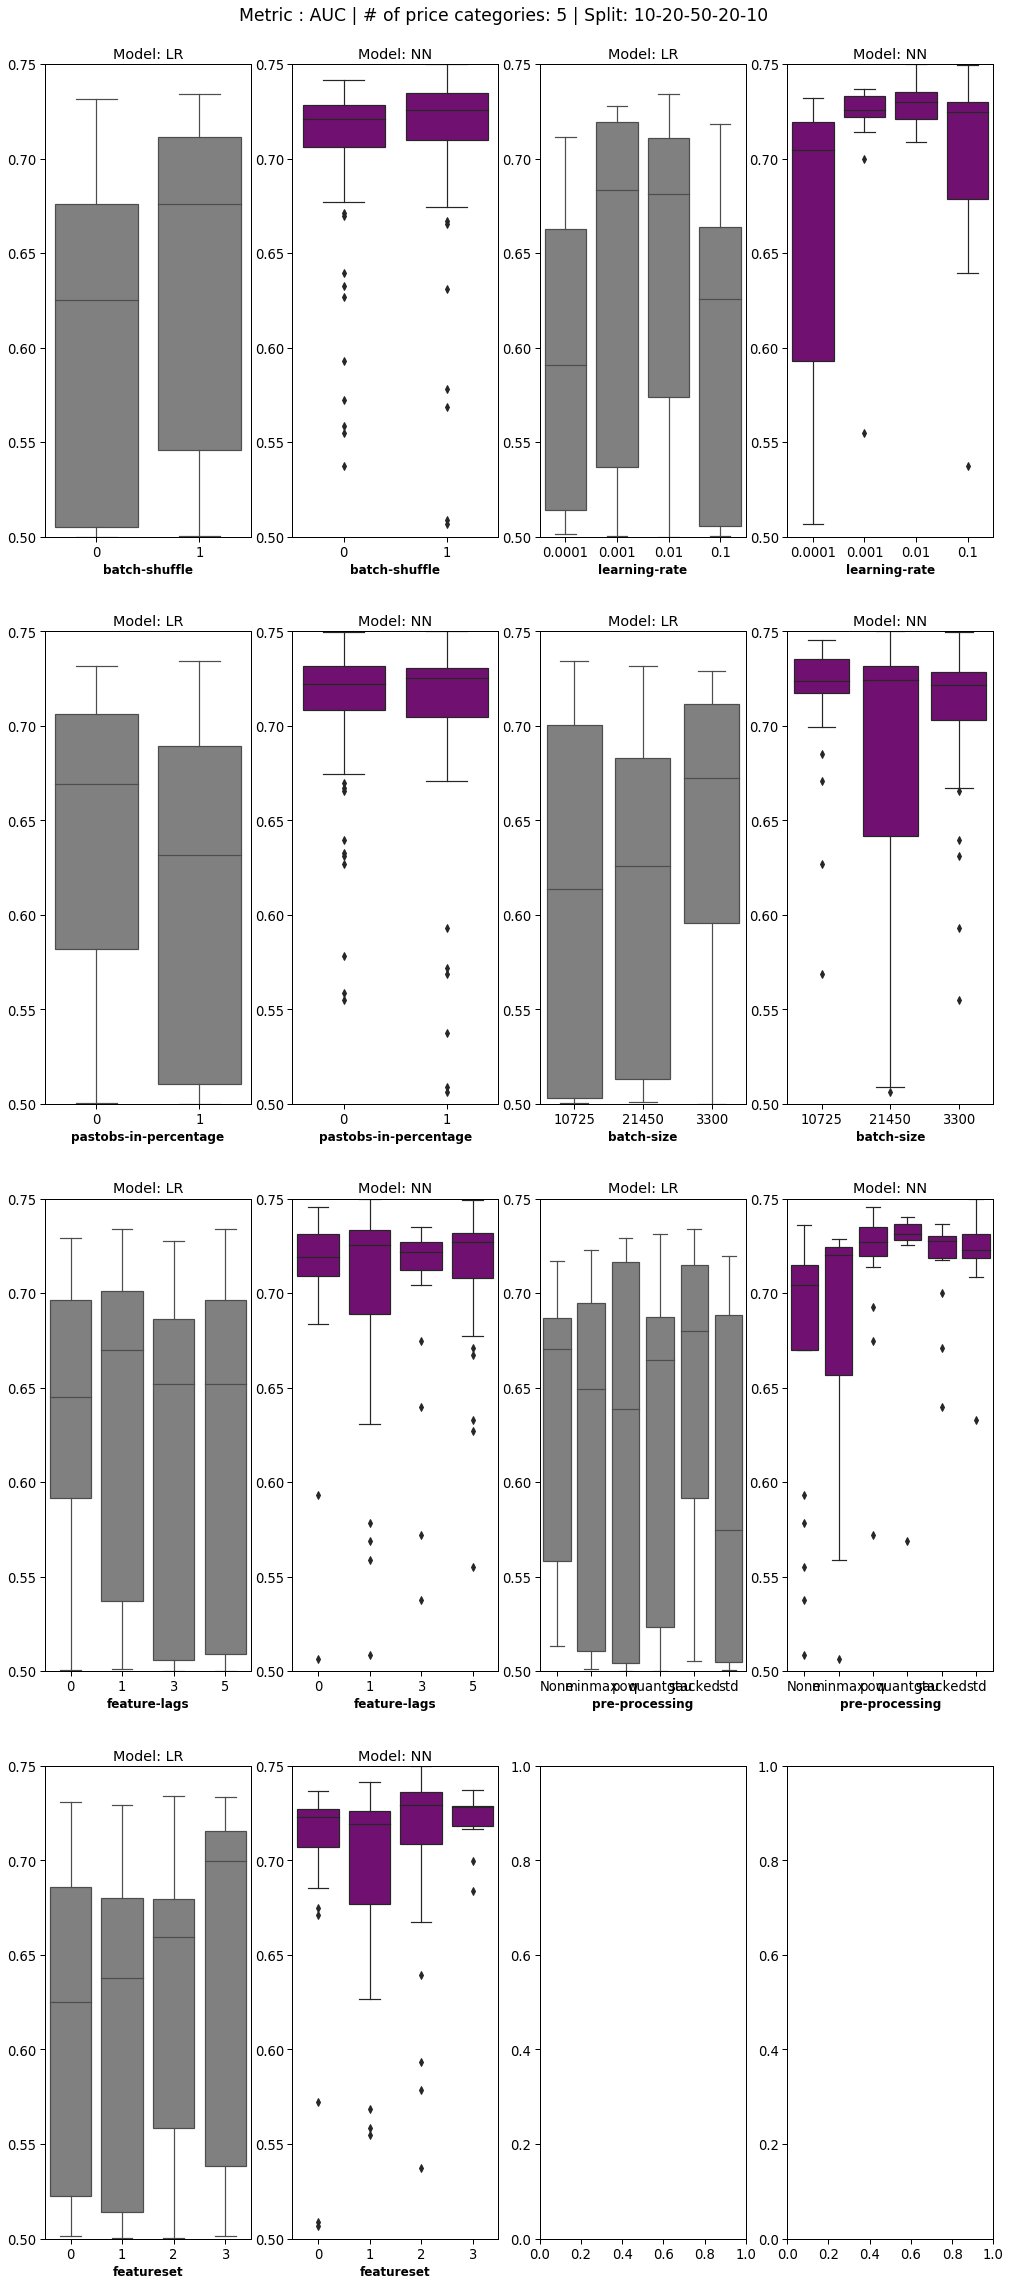

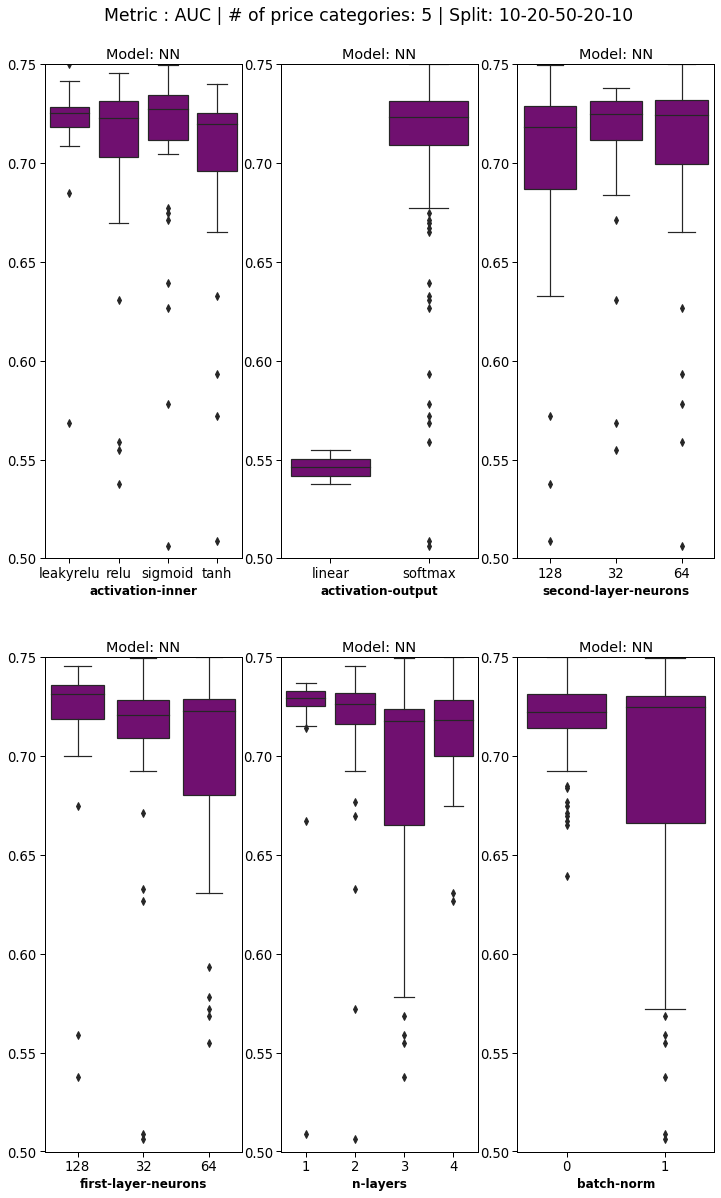

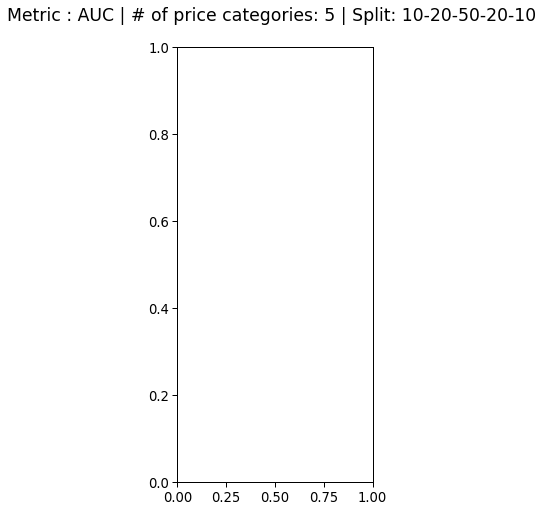

In [233]:
import seaborn as sns

## Two models; plotted next to each other, so at least double up the length above 
# (acutal number should depend on the layout of the plot)
plot_height_combined =  4
plot_width_combined = 4

## Two models; plotted next to each other, so at least double up the length above 
# (acutal number should depend on the layout of the plot)
plot_height_nn =  2
plot_width_nn = 3

## Two models; plotted next to each other, so at least double up the length above 
# (acutal number should depend on the layout of the plot)
plot_height_lr =  1
plot_width_lr = 1

save_plots = True
save_path = '../../../Google Drev/Thesis/Figures/model params'#'../../Figures_Thesis/model_params'
save_date = '20201222'


metric = 'AUC'

########################################### Plot each label type #########################################

for label_type in ['0','1','2','3','4']:#
    
    temp_lr = combined_table_lr[(combined_table_lr.loc[:,'label-type']==label_type)&\
                          (combined_table_lr.AUC>0.5)]

    temp_nn = combined_table[(combined_table.loc[:,'label-type']==label_type)&\
                          (combined_table.AUC>0.5)]

    ######################################## Plotting combined ###########################################

    cols_not_plot_lr = []
    cols_to_plot_lr = []

    for i,col in enumerate(temp_lr.columns):
        if (temp_lr.loc[:,col].unique().shape[0]>1)&(temp_lr.loc[:,col].unique().shape[0]<7):
            cols_to_plot_lr.append(col)
#             print(col,': ',temp_lr.loc[:,col].unique(),'\n')
        else:
            cols_not_plot_lr.append(col)
            
    ######################################### Plot the remaining NN columns separately ######################################

    cols_not_plot_nn = []
    cols_to_plot_nn = []

    for i,col in enumerate(temp_nn.columns):
        if ((temp_nn.loc[:,col].unique().shape[0]>1)&\
            (temp_nn.loc[:,col].unique().shape[0]<7)):
            cols_to_plot_nn.append(col)
#             print(col,': ',temp_nn.loc[:,col].unique(),'\n')
        else:
            cols_not_plot_nn.append(col)
            
    ######################################### Sets to plot  #########################################
    
    cols_to_plot_combined = set(cols_to_plot_lr).intersection(set(cols_to_plot_nn))
    cols_to_plot_combined = list(cols_to_plot_combined)

    cols_to_plot_nn_only = set(cols_to_plot_nn).difference(set(cols_to_plot_combined))
    cols_to_plot_nn_only = list(cols_to_plot_nn_only)

    cols_to_plot_lr_only = set(cols_to_plot_lr).difference(set(cols_to_plot_combined))
    cols_to_plot_lr_only = list(cols_to_plot_lr_only)
    
    print('For combined plot: \n\n',cols_to_plot_combined,'\n\nLength:',len(cols_to_plot_combined),'\n')
    print('For NN plot: \n\n',cols_to_plot_nn_only,'\n\nLength:',len(cols_to_plot_nn_only),'\n')
    print('For LR plot: \n\n',cols_to_plot_lr_only,'\n\nLength:',len(cols_to_plot_lr_only),'\n')
    
    ######################################### Initiate plotting  #########################################
    
    fig,ax = plt.subplots(plot_height,
                          plot_width,
                          figsize=(17,40))

    sns.set_context("paper", font_scale=1.5)

    k = 0

    ######################################### Plotting intersecting variables #########################################

    for i in np.arange(plot_height):
        for j in np.arange(0,plot_width,2):

            if k < len(cols_to_plot_combined):
                temp_lr_2 = pd.pivot_table(temp_lr,values=metric,columns=cols_to_plot_combined[k],index='run_id').reset_index()
                temp_nn_2 = pd.pivot_table(temp_nn,values=metric,columns=cols_to_plot_combined[k],index='run_id').reset_index()

                sns.boxplot(data=temp_lr_2,ax=ax[i,j],color='gray')#,bw='scott'
                sns.boxplot(data=temp_nn_2,ax=ax[i,j+1],color='purple')#,bw='scott'

                ### Set title
                ax[i,j].set_title('Model: LR')
                ax[i,j+1].set_title('Model: NN')

                ### Set y-axis
                ax[i,j].set_ylim(min(np.floor(temp_lr_2.iloc[:,1:].min().min()*100)/100,
                                     np.floor(temp_nn_2.iloc[:,1:].min().min()*100)/100),
                                 max(np.ceil(temp_lr_2.iloc[:,1:].max().max()*100)/100,
                                     np.ceil(temp_nn_2.iloc[:,1:].max().max()*100)/100))
                ax[i,j+1].set_ylim(min(np.floor(temp_lr_2.iloc[:,1:].min().min()*100)/100,
                                     np.floor(temp_nn_2.iloc[:,1:].min().min()*100)/100),
                                 max(np.ceil(temp_lr_2.iloc[:,1:].max().max()*100)/100,
                                     np.ceil(temp_nn_2.iloc[:,1:].max().max()*100)/100))

                ### Set x-label
                ax[i,j].set_xlabel(temp_lr_2.columns.name,fontsize=12,fontweight='bold')
                ax[i,j+1].set_xlabel(temp_nn_2.columns.name,fontsize=12,fontweight='bold')


                k +=1
    fig.suptitle('Metric : {} | {}'.format(metric,title_holder[str(label_type)]),y=0.90)

    if save_plots:
        plt.savefig(save_path+'/'+save_date+'_Label_type_{}_'.format(label_type)+'combined_plot'+'.png')
    else:
        plt.show()

    ######################################### Plotting variables only applying for NN #########################################
    k = 0

    fig,ax = plt.subplots(plot_height_nn,
                          plot_width_nn,
                          figsize=(12,20))

    for i in np.arange(plot_height_nn):
        for j in np.arange(plot_width_nn):

            if k < len(cols_to_plot_nn_only):
                temp_nn_2 = pd.pivot_table(temp_nn,values=metric,columns=cols_to_plot_nn_only[k],index='run_id').reset_index()

                sns.boxplot(data=temp_nn_2,ax=ax[i,j],color='purple')#,bw='scott'

                ### Set title
                ax[i,j].set_title('Model: NN')

                ### Set y-axis
                ax[i,j].set_ylim(np.floor(temp_nn_2.iloc[:,1:].min().min()*100)/100,
                                     np.ceil(temp_nn_2.iloc[:,1:].max().max()*100)/100)

                ### Set x-label
                ax[i,j].set_xlabel(temp_nn_2.columns.name,fontsize=12,fontweight='bold')

                k +=1

    fig.suptitle('Metric : {} | {}'.format(metric,title_holder[str(label_type)]),y=0.92)

    if save_plots:
        plt.savefig(save_path+'/'+save_date+'_Label_type_{}_'.format(label_type)+'nn_plot'+'.png')
    else:
        plt.show()

    ######################################### Plotting variables only applying for LR #########################################
    k = 0

    fig,ax = plt.subplots(plot_height_lr,
                          plot_width_lr,
                          figsize=(3.5,8))

    for i in np.arange(plot_height_lr):
        for j in np.arange(plot_width_lr):

            if k < len(cols_to_plot_lr_only):
                temp_lr_2 = pd.pivot_table(temp_lr,values=metric,columns=cols_to_plot_lr_only[k],index='run_id').reset_index()

                sns.boxplot(data=temp_lr_2,ax=ax,color='gray')#,bw='scott'

                ### Set title
                ax.set_title('Model: LR')

                ### Set y-axis
                ax.set_ylim(np.floor(temp_lr_2.iloc[:,1:].min().min()*100)/100,
                                 np.ceil(temp_lr_2.iloc[:,1:].max().max()*100)/100)

                ### Set x-label
                ax.set_xlabel(temp_lr_2.columns.name,fontsize=12,fontweight='bold')

                k +=1

    fig.suptitle('Metric : {} | {}'.format(metric,title_holder[str(label_type)]),y=0.95)

    if save_plots:
        plt.savefig(save_path+'/'+save_date+'_Label_type_{}_'.format(label_type)+'lr_plot'+'.png')
    else:
        plt.show()

In [163]:
cols_to_plot_nn

['activation-inner',
 'batch-norm',
 'dropout-ratio',
 'first-layer-neurons',
 'n-layers',
 'second-layer-neurons']

In [ ]:
import seaborn as sns

temp = combined_table[(combined_table.loc[:,'label-type']=='4')&\
                      (combined_table.loc[:,'nn-type']=='ffnn')&\
                      (combined_table.AUC>0.5)]

fig,ax = plt.subplots(5,3,figsize=(17,40))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
# plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'font.weight': 'normal'})
k = 0

for i in np.arange(5):
    for j in np.arange(3):
        


        if k < len(cols_to_plot):
            temp_2 = pd.pivot_table(temp,values='AUC',columns=cols_to_plot[k],index='run_id').reset_index()

            # sns.set_theme(style="whitegrid")
            # tips = sns.load_dataset("tips")
            # ax = sns.violinplot(x=tips["total_bill"])
            sns.boxplot(data=temp_2,ax=ax[i,j],color='gray')#,bw='scott'
#             ax[i,j].set_xticks(fontsize=12)
#             ax[i,j].set_yticks(fontsize=12)
            # plt.legend(fontsize=14)
            ax[i,j].set_xlabel(temp_2.columns.name,fontsize=12,fontweight='bold')


            k +=1

plt.show()

In [52]:
stop

NameError: name 'stop' is not defined

### Dropping ETFS and market indices

In [127]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [128]:
########### Generate Features ################

n_feature_lags = 0

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
#                                                     'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                      'macd_diff',
                                                      'macd_signal',
                                                    'dis5',
                                                    'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,ticker_dummies=False)

C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Number of NaNs in label: 1. 1 is expected
Returns that lead to NaNs in label: [0.0907158]
All tickers processed.


## Splitting the data

## Adding ticker dummies

In [129]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='ticker', drop_first=False)], axis=1)

## Constructing our final train/validation sets

In [130]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.75

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*train_size))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(319935, 109)
(319935, 1)
(107195, 109)
(107195, 1)


In [131]:
X_train

open   high    low  spread_open  spread_high  spread_low  \
0       0.420  0.700 -0.070     0.000304     0.000641    0.000034   
1      -0.035  0.130 -0.125     0.001211     0.003143    0.000121   
2       0.075  0.120 -0.010     0.000770     0.001209    0.000220   
3       0.165  0.170 -0.040     0.000856     0.003058    0.000245   
4       0.040  0.255 -0.045     0.000854     0.002772    0.000299   
...       ...    ...    ...          ...          ...         ...   
319930 -0.045  0.000 -0.055     0.000197     0.000591    0.000197   
319931  0.100  0.115 -0.105     0.000550     0.001954    0.000061   
319932  0.105  0.150  0.000     0.000308     0.001437    0.000103   
319933  0.005  0.160 -0.295     0.000210     0.002200    0.000053   
319934 -0.005  0.045 -0.070     0.000160     0.001120    0.000080   

        spread_close  bidsize_open  bidsize_high  bidsize_low  ...  ticker_SO  \
0           0.000237           3.0          50.0          1.0  ...          0   
1           0.002542           1.0           7.0          1.0  ...          0   
2           0.000440           1.0           4.0          1.0  ...          0   
3           0.001716           1.0           8.0          1.0  ...          0   
4           0.001281           2.0           7.0          1.0  ...          0   
...              ...           ...           ...          ...  ...        ...   
319930      0.000394          12.0         229.0          1.0  ...          0   
319931      0.001039           1.0           6.0          1.0  ...          0   
319932      0.000411           1.0          14.0          1.0  ...          0   
319933      0.001835           1.0          15.0          1.0  ...          0   
319934      0.000560           2.0          11.0          1.0  ...          0   

        ticker_SRE  ticker_T  ticker_TM  ticker_TSLA  ticker_TSM  ticker_UNP  \
0                0         0          0            0           0           0   
1                0         0          0            0           0           0   
2                0         0          0            0           0           0   
3                0         0          0            0           0           0   
4                0         0          0            0           0           0   
...            ...       ...        ...          ...         ...         ...   
319930           0         0          0            0           1           0   
319931           0         0          0            0           0           1   
319932           0         0          0            0           0           0   
319933           0         0          0            0           0           0   
319934           0         0          0            0           0           0   

        ticker_UPS  ticker_V  ticker_WMT  
0                0         0           0  
1                0         0           0  
2                0         0           0  
3                0         0           0  
4                0         0           0  
...            ...       ...         ...  
319930           0         0           0  
319931           0         0           0  
319932           1         0           0  
319933           0         1           0  
319934           0         0           1  

[319935 rows x 109 columns]

In [132]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


(array([], dtype=int64),)

In [133]:
y_test_K_2 = y_test.copy(deep=True)
# y_test_K_5 = y_test.copy(deep=True)

In [134]:
y_test_K_2

0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
107190  0.0
107191  0.0
107192  0.0
107193  0.0
107194  0.0

[107195 rows x 1 columns]

In [120]:
y_test_K_5

0
0       1.0
1       0.0
2       0.0
3       2.0
4       0.0
...     ...
107190  0.0
107191  0.0
107192  0.0
107193  0.0
107194  0.0

[107195 rows x 1 columns]

# Plot AUC based on predictions

In [80]:
os.listdir('../../../Google Drev/Thesis/Keras output/round15_1000epochs_earlystopAUC200patience_featuresetanalysis')

['desktop.ini',
 'first_round_was_weird',
 'preds_val_featuresets_28_12_2020_lr_0_feat1.csv',
 'preds_val_featuresets_28_12_2020_lr_3_feat2.csv',
 'preds_val_featuresets_28_12_2020_nn_0_feat3.csv',
 'preds_val_featuresets_28_12_2020_nn_3_feat2.csv',
 'test_model_spec.txt']

In [139]:
path = '../../../Google Drev/Thesis/Keras output/round15_1000epochs_earlystopAUC200patience_featuresetanalysis'#'../../../Google Drev/Thesis/Keras output/round4_1000epochs_noearlystop'
pred_csvs = [i for i in os.listdir(path) if '.csv' in i]#('.csv' in i)&((str(i[-5])=='0')|(str(i[-5])=='3'))
pred_csvs
# preds = pd.read_csv(path+'/'+val_class_preds[j],index_col=[0,1,2]).reset_index()#.drop('level_0',axis=1)

['preds_val_featuresets_28_12_2020_lr_0_feat1.csv',
 'preds_val_featuresets_28_12_2020_lr_3_feat2.csv',
 'preds_val_featuresets_28_12_2020_nn_0_feat3.csv',
 'preds_val_featuresets_28_12_2020_nn_3_feat2.csv']

In [84]:
# n_class_preds = [i for i in pred_csvs if str(n_classes) in i]
val_preds = [i for i in pred_csvs if 'val' in i]
oos_preds = [i for i in pred_csvs if 'oos' in i]
# n_class_preds = [i for i in pred_csvs if i[-5] == '1']

In [89]:
# n_class_preds
val_preds[0][-11]

'0'

In [75]:
y_test_binary.shape

(136430, 1)

In [123]:
y_preds[:-55,:].shape

(107195, 2)

In [90]:
y_test_binary = label_binarize(y_test, classes=[0, 1, 2])

for i in ['0','3']:
    val_class_preds = [l for l in val_preds if str(l[-11])==i]
    print(val_class_preds)
    
    
    
    for j in np.arange(0,2):
        
        preds = pd.read_csv(path+'/'+val_class_preds[j],index_col=[0,1,2]).reset_index()#.drop('level_0',axis=1)
        
        if i == '0':
            y_preds = preds.loc[:,['0','1']].values[:-55,:]
        else:
            y_preds = preds.loc[:,['0','1','2','3','4']].values[:-55,:]
            
        total_fpr = {}
        total_tpr = {}
        total_roc_auc = {}
        
        ## Extract the name 
        filename_split = re.split("[_.]",val_class_preds[j])
        identifier = filename_split[-3]+'_'+filename_split[-2]

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        if i == '0':
            y_test_binary = label_binarize(y_test_K_2, classes=[0, 1])
            n_classes = 2
            
            fpr[0], tpr[0], _ = roc_curve(y_test_binary, y_preds[:, 0])
            roc_auc[0] = auc(fpr[0], tpr[0])
            
        else:
            y_test_binary = label_binarize(y_test_K_5, classes=[0, 1, 2,3,4])
            n_classes = 5

            for ii in range(n_classes):
                fpr[ii], tpr[ii], _ = roc_curve(y_test_binary[:, i], y_preds[:, i])
                roc_auc[ii] = auc(fpr[ii], tpr[ii])

            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([fpr[ii] for ii in range(n_classes)]))

        #     if j == 0:
        #         print(all_fpr)

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for ii in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[ii], tpr[ii])

        #         if (j == 0) & (i == 0):
        #             print('\n',interp(all_fpr, fpr[i], tpr[i]))

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            total_fpr[identifier] = all_fpr
            total_tpr[identifier] = mean_tpr
            total_roc_auc[identifier] = auc(total_fpr[identifier], total_tpr[identifier])
        
#         y_preds

['preds_val_featuresets_28_12_2020_lr_0_feat1.csv', 'preds_val_featuresets_28_12_2020_nn_0_feat3.csv']


ValueError: Found input variables with inconsistent numbers of samples: [136430, 107250]

In [71]:
y_test_binary

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [72]:
y_preds

array([[0.47762334, 0.52237666],
       [0.46471882, 0.5352812 ],
       [0.4165136 , 0.58348644],
       ...,
       [0.35269496, 0.647305  ],
       [0.45645878, 0.5435412 ],
       [0.4777967 , 0.5222033 ]])

In [52]:
preds = pd.read_csv(path+'/'+val_class_preds[0],index_col=[0,1,2]).reset_index()#.drop('level_0',axis=1)

In [53]:
preds

days  timestamps ticker         0         1         2         3  \
0       20200522           0   AAPL  0.386028  0.081373  0.108423  0.094901   
1       20200522           0   ABBV  0.396657  0.056947  0.074846  0.058576   
2       20200522           0    ABT  0.358744  0.064928  0.109401  0.087867   
3       20200522           0    AEP  0.470618  0.063393  0.060075  0.067199   
4       20200522           0    AMT  0.484494  0.050730  0.060699  0.062840   
...          ...         ...    ...       ...       ...       ...       ...   
107245  20200529         389    TSM  0.205393  0.200340  0.167454  0.207375   
107246  20200529         389    UNP  0.259090  0.188278  0.117477  0.191833   
107247  20200529         389    UPS  0.155153  0.149957  0.126713  0.203182   
107248  20200529         389      V  0.217821  0.192695  0.114429  0.185725   
107249  20200529         389    WMT  0.290017  0.151219  0.072880  0.147790   

               4  class  confidence  
0       0.329274      0    0.386028  
1       0.412974      4    0.412974  
2       0.379061      4    0.379061  
3       0.338715      0    0.470618  
4       0.341237      0    0.484494  
...          ...    ...         ...  
107245  0.219438      4    0.219438  
107246  0.243321      0    0.259090  
107247  0.364995      4    0.364995  
107248  0.289330      4    0.289330  
107249  0.338095      4    0.338095  

[107250 rows x 10 columns]

In [26]:
y_preds = preds.loc[:,['0','1','2']].values
y_preds

array([[0.22518289, 0.25525287, 0.5195642 ],
       [0.20868547, 0.19545762, 0.5958569 ],
       [0.3040542 , 0.18152189, 0.5144239 ],
       ...,
       [0.40635034, 0.21207863, 0.38157105],
       [0.38126647, 0.25623307, 0.36250052],
       [0.38174903, 0.25126103, 0.3669899 ]])

In [35]:
y_test_binary = label_binarize(y_test, classes=[0, 1, 2])

In [36]:
y_test_binary

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [37]:
total_fpr = {}
total_tpr = {}
total_roc_auc = {}

In [38]:

#### All in one
for j,pred_file in enumerate(n_class_preds):
    
#     preds = pd.read_csv(path+'/'+n_class_preds[0],index_col=[0,1,2]).reset_index().drop('level_0',axis=1)
    preds = pd.read_csv(path+'/'+pred_file,index_col=np.arange(n_classes)).reset_index().drop('level_0',axis=1)
    preds.loc[:,'confidence'] = preds.iloc[:,0:n_classes].max(axis=1)
    
#     y_preds = preds.loc[:,['0','1','2']].values
    y_preds = preds.loc[:,np.arange(n_classes).astype(str)].values
    
    y_test_binary = label_binarize(y_test, classes=[0, 1, 2])
    
    ## Extract the name 
    filename_split = re.split("[_.]",pred_file)
    identifier = filename_split[-3]+'_'+filename_split[-2]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
#     if j == 0:
#         print(all_fpr)
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
#         if (j == 0) & (i == 0):
#             print('\n',interp(all_fpr, fpr[i], tpr[i]))
        
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    
    
    total_fpr[identifier] = all_fpr
    total_tpr[identifier] = mean_tpr
    total_roc_auc[identifier] = auc(total_fpr[identifier], total_tpr[identifier])

In [39]:
total_roc_auc

{'lr_1': 0.6151800882196703, 'nn_1': 0.5513141060769641}

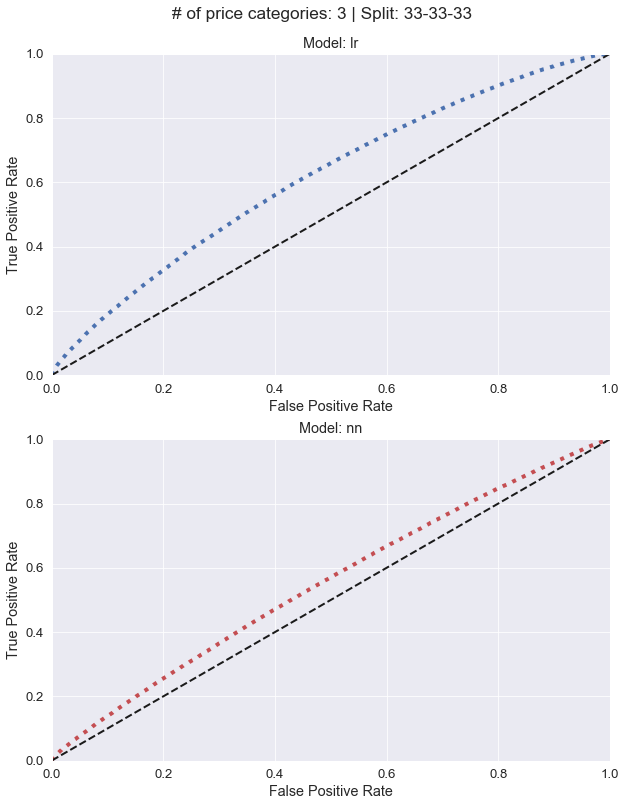

In [434]:
title_holder = {'0':'# of price categories: 2 | Split: 50-50',
                 '1':'# of price categories: 3 | Split: 33-33-33',
                 '2':'# of price categories: 3 | Split: 20-60-20',
                 '3':'# of price categories: 5 | Split: 20-20-20-20-20',
                 '4':'# of price categories: 5 | Split: 10-20-50-20-10'}

############################################# Plot all ROC curves #############################################

sns.set_context("paper", font_scale=1.5)

fig,ax = plt.subplots(2,1,figsize=(10,13))
lw = 2

colors = ['b','r']

for i,j in enumerate(total_roc_auc.keys()):

#     ax[i].plot(total_fpr[j], total_tpr[j],
# #              label='macro-average ROC curve (area = {0:0.2f})'
#     #          label='ROC curve (area = {0:0.2f})'
#                    ''.format(total_roc_auc[j]),
#              color=colors[i], linestyle=':', linewidth=4)
    sns.lineplot(x=total_fpr[j],y=total_tpr[j],
#              label='macro-average ROC curve (area = {0:0.2f})'
    #          label='ROC curve (area = {0:0.2f})'
#                    ''.format(total_roc_auc[j]),
             color=colors[i], linestyle=':', linewidth=4,ax=ax[i],label='Model')
    t = re.split('_',j)
    title = 'Model: {}'.format(t[0]) 
    ax[i].set_title(title)
    ax[i].plot([0, 1], [0, 1], 'k--', lw=lw,label='Random guess')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.0])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

fig.suptitle(title_holder[t[-1]],y=0.93)
plt.legend(loc="lower right")
plt.show()

# Single graph

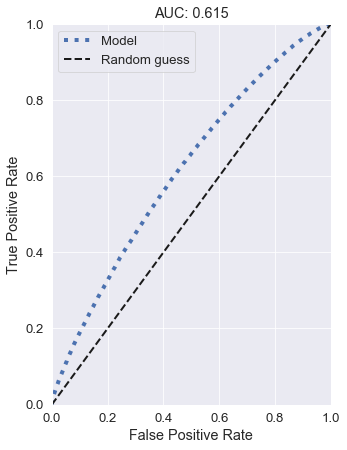

In [56]:
# title_holder = {'0':'# of price categories: 2 | Split: 50-50',
#                  '1':'# of price categories: 3 | Split: 33-33-33',
#                  '2':'# of price categories: 3 | Split: 20-60-20',
#                  '3':'# of price categories: 5 | Split: 20-20-20-20-20',
#                  '4':'# of price categories: 5 | Split: 10-20-50-20-10'}

############################################# Plot all ROC curves #############################################

sns.set_context("paper", font_scale=1.5)

fig,ax = plt.subplots(1,1,figsize=(5,7))
lw = 2

colors = ['b']#,'r'

# for i,j in enumerate(total_roc_auc.keys()):

#     ax[i].plot(total_fpr[j], total_tpr[j],
# #              label='macro-average ROC curve (area = {0:0.2f})'
#     #          label='ROC curve (area = {0:0.2f})'
#                    ''.format(total_roc_auc[j]),
#              color=colors[i], linestyle=':', linewidth=4)
sns.lineplot(x=total_fpr['lr_1'],y=total_tpr['lr_1'],
#              label='macro-average ROC curve (area = {0:0.2f})'
#          label='ROC curve (area = {0:0.2f})'
#                    ''.format(total_roc_auc[j]),
         color=colors[0], linestyle=':', linewidth=4,ax=ax,label='Model')
# t = re.split('_',j)
title = 'AUC: {:.3f}'.format(total_roc_auc['lr_1']) #t[0]
ax.set_title(title)
ax.plot([0, 1], [0, 1], 'k--', lw=lw,label='Random guess')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# fig.suptitle(title_holder[t[-1]],y=0.93)
plt.legend(loc="upper left")
# plt.show()
plt.savefig('../../../Google Drev/Thesis/Figures/Results/AUC_curve',bbox_inches='tight')

# Binary plot

In [138]:
path

'../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'

In [142]:
val_class_preds = [l for l in val_preds if str(l[-11])==i]
print(val_class_preds)
    
    
    
#     for j in np.arange(0,2):
        
preds = pd.read_csv(path+'/'+val_class_preds[0],index_col=[0,1]).reset_index()#.drop('level_0',axis=1)
y_preds = preds.loc[:,['0','1']].values[:-55,:]

['preds_val_featuresets_28_12_2020_lr_0_feat1.csv', 'preds_val_featuresets_28_12_2020_nn_0_feat3.csv']


In [143]:
y_preds

array([[0.46108726, 0.5389128 ],
       [0.4396385 , 0.5603615 ],
       [0.4103311 , 0.58966887],
       ...,
       [0.41369128, 0.5863087 ],
       [0.44885638, 0.5511436 ],
       [0.4439128 , 0.5560872 ]])

In [145]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# y_true = # ground truth labels
# y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test_K_2, y_preds)#y_true,y_probas
plt.show()

ModuleNotFoundError: No module named 'scikitplot'

In [55]:
os.listdir('../../../Google Drev/Thesis/Figures')

['Apple_price_dev_entire_period.png',
 'desktop.ini',
 'Estimation Procedure.PNG',
 'model params',
 'Models.PNG',
 'Results',
 'variables']

In [54]:
# os.mkdir('../../../Google Drev/Thesis/Figures/Results')

# Predictions graph

In [314]:
np.array([i for i in X_test.columns if 'ticker_' in i])

array(['ticker_AAPL', 'ticker_ABBV', 'ticker_ABT', 'ticker_AEP',
       'ticker_AMT', 'ticker_APD', 'ticker_BA', 'ticker_BABA',
       'ticker_BAC', 'ticker_BHP', 'ticker_BP', 'ticker_CCI',
       'ticker_CHL', 'ticker_COST', 'ticker_CSGP', 'ticker_D',
       'ticker_DIS', 'ticker_ECL', 'ticker_ENB', 'ticker_EXC',
       'ticker_FB', 'ticker_FMX', 'ticker_GOOG', 'ticker_INTC',
       'ticker_JNJ', 'ticker_KO', 'ticker_LFC', 'ticker_LIN',
       'ticker_LMT', 'ticker_MA', 'ticker_MCD', 'ticker_MSFT',
       'ticker_NKE', 'ticker_NVDA', 'ticker_NVS', 'ticker_PBR',
       'ticker_PEP', 'ticker_PFE', 'ticker_PLD', 'ticker_PSA',
       'ticker_PTR', 'ticker_PYPL', 'ticker_RTX', 'ticker_SHW',
       'ticker_SNP', 'ticker_SO', 'ticker_SRE', 'ticker_T', 'ticker_TM',
       'ticker_TSLA', 'ticker_TSM', 'ticker_UNP', 'ticker_UPS',
       'ticker_V', 'ticker_WMT'], dtype='<U11')

In [148]:
path = '../../../Google Drev/Thesis/Keras output/round15_1000epochs_earlystopAUC200patience_featuresetanalysis'#'../../../Google Drev/Thesis/Keras output/round4_1000epochs_noearlystop'
pred_csvs = [i for i in os.listdir(path) if '.csv' in i]#('.csv' in i)&((str(i[-5])=='0')|(str(i[-5])=='3'))
pred_csvs


['preds_val_featuresets_28_12_2020_lr_0_feat1.csv',
 'preds_val_featuresets_28_12_2020_lr_3_feat2.csv',
 'preds_val_featuresets_28_12_2020_nn_0_feat3.csv',
 'preds_val_featuresets_28_12_2020_nn_3_feat2.csv']

In [164]:
preds = pd.read_csv(path+'/'+pred_csvs[2],index_col=[0,1]).reset_index()#.drop('level_0',axis=1)
# preds = pd.read_csv(path+'/'+pred_csvs[0],index_col=[0,1,2]).reset_index()#.drop('level_0',axis=1)

In [165]:
preds

days  timestamps ticker         0         1  class  confidence
0       20200522           0   AAPL  0.514709  0.485291      0    0.514709
1       20200522           0   ABBV  0.492985  0.507015      1    0.507015
2       20200522           0    ABT  0.518293  0.481707      0    0.518293
3       20200522           0    AEP  0.585168  0.414832      0    0.585168
4       20200522           0    AMT  0.556153  0.443847      0    0.556153
...          ...         ...    ...       ...       ...    ...         ...
107245  20200529         389    TSM  0.434803  0.565197      1    0.565197
107246  20200529         389    UNP  0.583692  0.416308      0    0.583692
107247  20200529         389    UPS  0.370156  0.629844      1    0.629844
107248  20200529         389      V  0.463049  0.536951      1    0.536951
107249  20200529         389    WMT  0.476427  0.523573      1    0.523573

[107250 rows x 7 columns]

# Get an overview of the distribution of predictions

In [185]:
tickers = []
c_preds = []
for d in data.Ticker.unique():
    
    ticker_index = X_test[X_test.loc[:,'ticker_'+d]==1].index#ticker_to_plot

    ######################################## Ticker specific data ########################################

    X_test_ticker,y_test_ticker,preds_ticker = X_test.loc[ticker_index,:],y_test.loc[ticker_index,:].reset_index(drop=True),preds.loc[ticker_index,:].reset_index(drop=True)

    # preds_ticker.loc[:,'confidence'] = preds_ticker.loc[:,['0','1','2']].max(axis=1)

    days = data.index.get_level_values(0).unique()
    ticker_close_price = data[(data.index.get_level_values(0).isin(days[first_val_day:]))&\
                             (data.Ticker==ticker_to_plot)].close.reset_index().iloc[:-1,:]

    ############################################ Same direction ############################################

    correct_preds = np.zeros(preds_ticker.shape[0])

    booler = np.equal(y_test_ticker.values.T,preds_ticker.loc[:,'class'].values)[0]
    correct_preds[booler] = 1

    ############################################ Opposite direction ############################################

    opposite_direction = np.zeros(preds_ticker.shape[0])

    booler_od = ((y_test_ticker.values.T == 0)&(preds_ticker.loc[:,'class'].values==1)|\
                 (y_test_ticker.values.T == 1)&(preds_ticker.loc[:,'class'].values==0)|\
                 (y_test_ticker.values.T == 1)&(preds_ticker.loc[:,'class'].values!=1)).reshape(-1)

    opposite_direction[booler_od] = 1

    ############################################ Same direction, end categories ############################################

    same_direction = np.zeros(preds_ticker.shape[0])

    booler_sd = ((y_test_ticker.values.T == 0)&(preds_ticker.loc[:,'class'].values==0)|\
                 (y_test_ticker.values.T == 1)&(preds_ticker.loc[:,'class'].values==1)).reshape(-1)

    same_direction[booler_sd] = 1
    
#     print(d,'\n',np.unique(correct_preds,return_counts=True))
    tickers.append(d)
    t,s = np.unique(correct_preds,return_counts=True)
    c_preds.append(s[1])

In [181]:
ticker_to_plot = 'BP'

ticker_index = X_test[X_test.loc[:,'ticker_'+ticker_to_plot]==1].index

######################################## Ticker specific data ########################################

X_test_ticker,y_test_ticker,preds_ticker = X_test.loc[ticker_index,:],y_test.loc[ticker_index,:].reset_index(drop=True),preds.loc[ticker_index,:].reset_index(drop=True)

# preds_ticker.loc[:,'confidence'] = preds_ticker.loc[:,['0','1','2']].max(axis=1)

days = data.index.get_level_values(0).unique()
ticker_close_price = data[(data.index.get_level_values(0).isin(days[first_val_day:]))&\
                         (data.Ticker==ticker_to_plot)].close.reset_index().iloc[:-1,:]

############################################ Same direction ############################################

correct_preds = np.zeros(preds_ticker.shape[0])

booler = np.equal(y_test_ticker.values.T,preds_ticker.loc[:,'class'].values)[0]
correct_preds[booler] = 1

############################################ Opposite direction ############################################

opposite_direction = np.zeros(preds_ticker.shape[0])

booler_od = ((y_test_ticker.values.T == 0)&(preds_ticker.loc[:,'class'].values==1)|\
             (y_test_ticker.values.T == 1)&(preds_ticker.loc[:,'class'].values==0)|\
             (y_test_ticker.values.T == 1)&(preds_ticker.loc[:,'class'].values!=1)).reshape(-1)

opposite_direction[booler_od] = 1

############################################ Same direction, end categories ############################################

same_direction = np.zeros(preds_ticker.shape[0])

booler_sd = ((y_test_ticker.values.T == 0)&(preds_ticker.loc[:,'class'].values==0)|\
             (y_test_ticker.values.T == 1)&(preds_ticker.loc[:,'class'].values==1)).reshape(-1)

same_direction[booler_sd] = 1

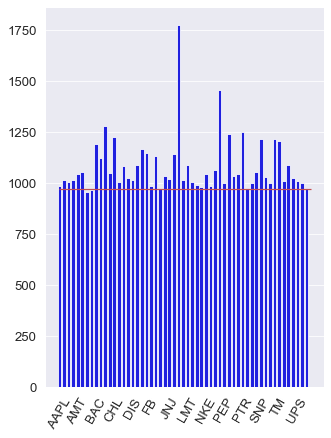

In [200]:
# plt.figure(figsize=(10,7))
fig,ax = plt.subplots(figsize=(10,7))
sns.barplot(x=tickers,y=c_preds,color='blue',)
plt.xticks(np.arange(0,55,4),np.array(tickers)[np.arange(0,55,4)],rotation=60)
# plt.xtickslabels()
plt.hlines(975,0,55,color='r')
plt.show()

In [183]:
ticker_close_price

level_0  level_1   close
0     20200522        0  22.945
1     20200522        1  22.960
2     20200522        2  22.905
3     20200522        3  22.855
4     20200522        4  22.835
...        ...      ...     ...
1944  20200529      384  23.125
1945  20200529      385  23.175
1946  20200529      386  23.170
1947  20200529      387  23.185
1948  20200529      388  23.185

[1949 rows x 3 columns]

# What we are using, alternatives are below

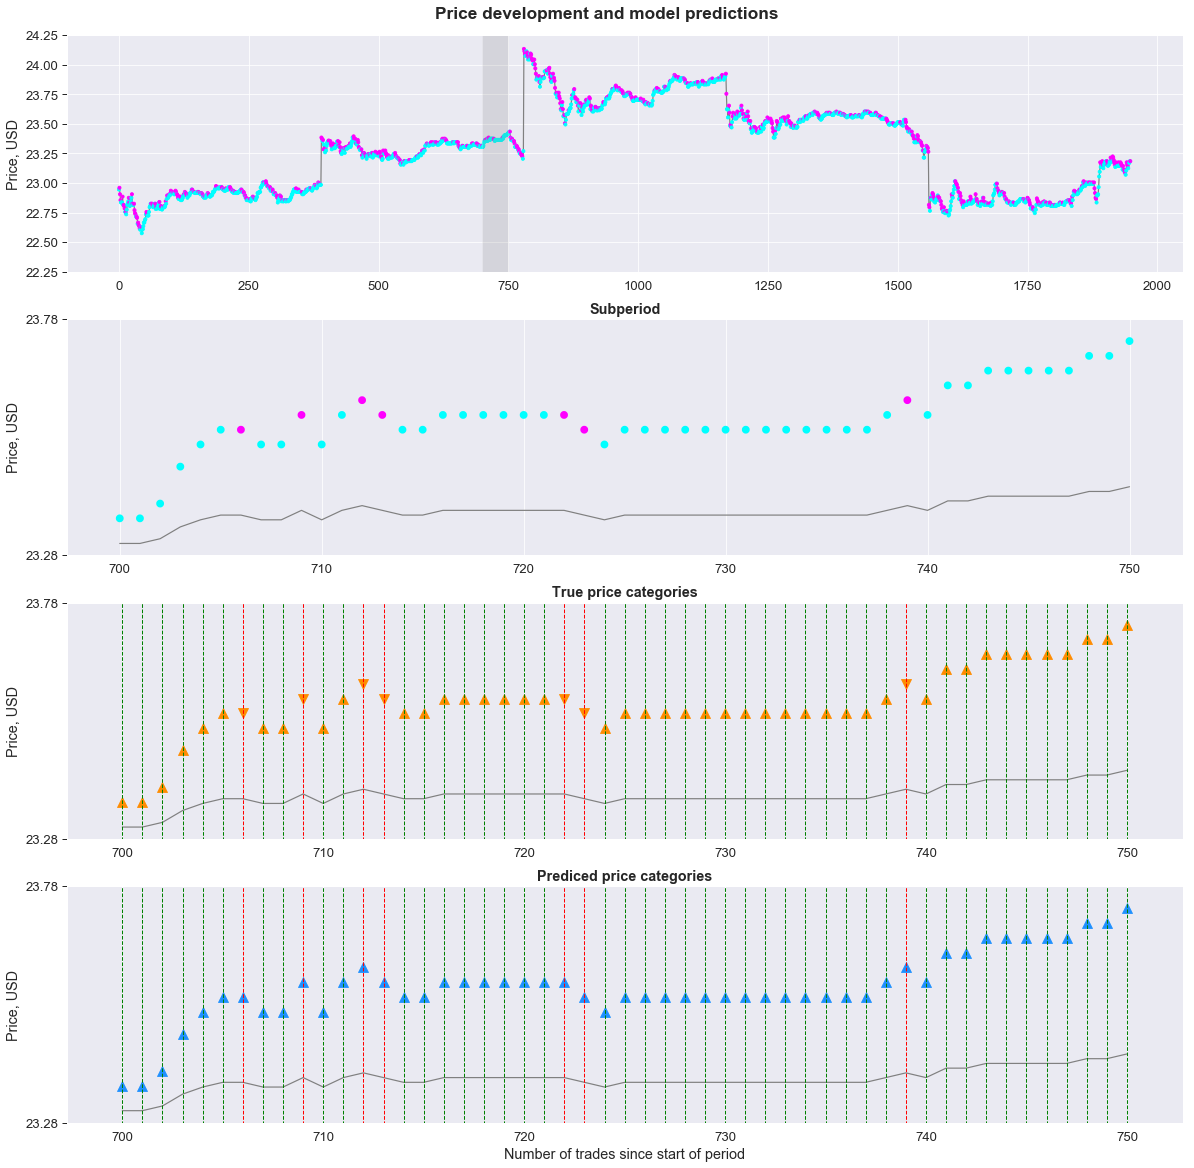

In [182]:
colors = {0:'magenta',1:'cyan'}
# colors_2 = {0:'red',1:'blue',2:'green'}
markers = {0:'v',
           1:'^',
#            2:'^'
          }

sns.set_context("paper", font_scale=1.5)

zoom_period = [700,750]

fig,ax = plt.subplots(4,1,figsize=(20,20))
line_color = 'grey'
################################################ First plot ################################################

ax[0].plot(ticker_close_price.close,color=line_color)

ax2 = ax[0].twinx()

ax2.axvspan(zoom_period[0],zoom_period[1],
            0,1000,
            facecolor='grey', alpha=0.2)

## Adding the predicted labels
ax2.scatter(x = ticker_close_price.index,
            y=ticker_close_price.loc[:,'close'],
           c=pd.Series(correct_preds).apply(lambda x: colors[x]),marker='o',s=10)

pos = ax[0].get_yticks()
ax[0].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[0].set_ylabel('Price, USD')

################################################ Second plot ################################################

ax[1].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[1].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=pd.Series(correct_preds[zoom_period[0]:zoom_period[1]+1]).apply(lambda x: colors[x]),
            marker='o',linewidth=3)#,s=80

step = 0.5
np.arange(pos[0],pos[-1]+step,step)

pos = ax[1].get_yticks()
ax[1].set_ylim(pos[0],pos[-1])
ax[1].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[1].set_title('Subperiod',fontweight='bold')
ax[1].set_ylabel('Price, USD')

# ################################################ Third plot ################################################

ax[2].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[2].twinx()

## Adding actual labels
for c in np.unique(y_test_ticker):
    temp_booler = y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).values==c
    ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1)[temp_booler],
                y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'].values[temp_booler],
               color='darkorange',#dodgerblue
                marker=markers[c],s=100)#y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: markers[x])

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1)
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='green')

pos = ax[2].get_yticks()
ax[2].set_ylim(pos[0],pos[-1])
ax[2].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[2].set_title('True price categories',fontweight='bold')
ax[2].set_ylabel('Price, USD')

# ################################################ Fourth plot ################################################

ax[3].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[3].twinx()

## Adding the predicted labels
# ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
#             y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
#            color=preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).apply(lambda x: colors_2[x]),
#             marker='x',s=80,linewidth=3)
for c in np.unique(preds_ticker.loc[:,'class']):
    temp_booler = preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).values==c
    ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1)[temp_booler],
                y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'].values[temp_booler],
               color='dodgerblue',#darkorange
                marker=markers[c],s=100)

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='green')

pos = ax[3].get_yticks()
ax[3].set_ylim(pos[0],pos[-1])
ax[3].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[3].set_title('Prediced price categories',fontweight='bold')
ax[3].set_xlabel('Number of trades since start of period')
ax[3].set_ylabel('Price, USD')

fig.suptitle('Price development and model predictions',y=0.9,fontweight='bold')


plt.show()

# First attempt

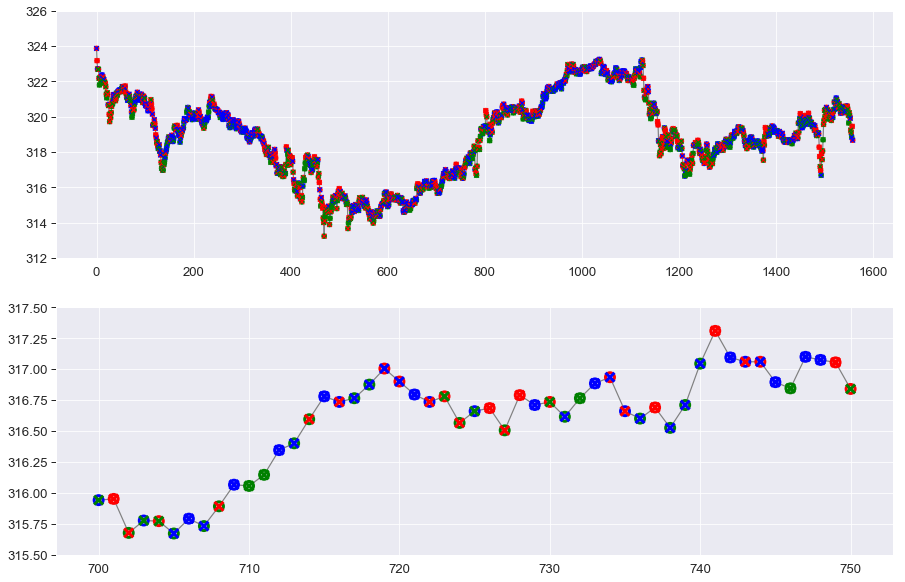

In [435]:
colors = {0:'red',1:'blue',2:'green'}

zoom_period = [700,750]

fig,ax = plt.subplots(2,1,figsize=(15,10))

################################################ Upper plot ################################################

ax[0].plot(ticker_close_price.close,color='black')

# ax[i].plot(series_indexed)
ax2 = ax[0].twinx()

## Adding actual labels
ax2.scatter(x = ticker_close_price.index,
            y=ticker_close_price.loc[:,'close'],
           c=y_test_ticker.loc[:,0].astype(int).apply(lambda x: colors[x]))

## Adding the predicted labels
ax2.scatter(x = ticker_close_price.index,
            y=ticker_close_price.loc[:,'close'],
           c=preds_ticker.loc[:,'class'].astype(int).apply(lambda x: colors[x]),marker='x')

pos = ax[0].get_yticks()
ax[0].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

################################################ Lower plot ################################################

ax[1].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

# ax[i].plot(series_indexed)
ax2 = ax[1].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           edgecolors=y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: colors[x]),
            marker='o',facecolors='none',s=80,linewidth=3)

## Adding the predicted labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).apply(lambda x: colors[x]),
            marker='x',s=80,linewidth=3)

pos = ax[1].get_yticks()
ax[1].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

plt.show()

# Second attempt

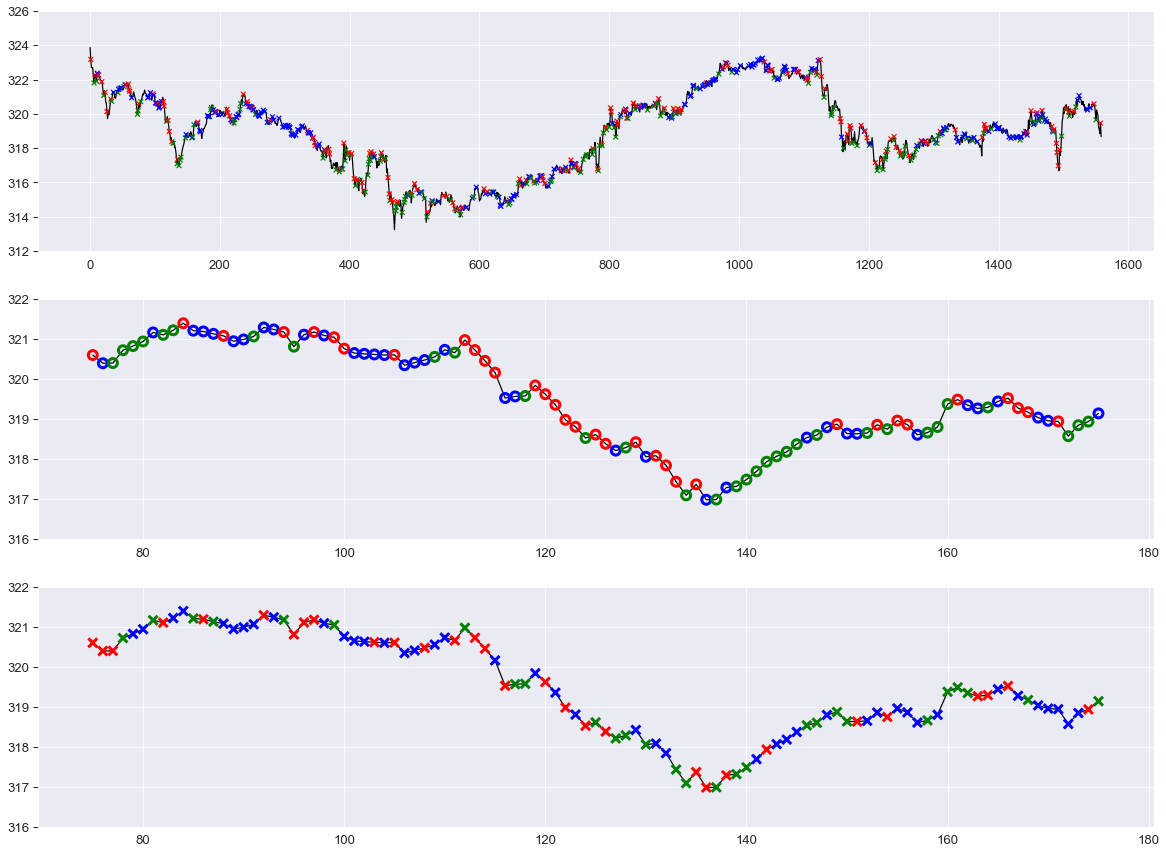

In [439]:
colors = {0:'red',1:'blue',2:'green'}

zoom_period = [75,175]

fig,ax = plt.subplots(3,1,figsize=(20,15))

################################################ Upper plot ################################################

ax[0].plot(ticker_close_price.close,color='black')

# ax[i].plot(series_indexed)
ax2 = ax[0].twinx()

## Adding the predicted labels
ax2.scatter(x = ticker_close_price.index.values[np.equal(y_test_ticker.values.T,preds_ticker.loc[:,'class'].values)[0]],
            y=ticker_close_price.loc[:,'close'].values[np.equal(y_test_ticker.values.T,preds_ticker.loc[:,'class'].values)[0]],
           c=preds_ticker.loc[:,'class'].astype(int).apply(lambda x: colors[x]).values[np.equal(y_test_ticker.values.T,preds_ticker.loc[:,'class'].values)[0]],marker='x')

pos = ax[0].get_yticks()
ax[0].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

################################################ Middle plot ################################################

ax[1].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

# ax[i].plot(series_indexed)
ax2 = ax[1].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           edgecolors=y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: colors[x]),
            marker='o',facecolors='none',s=80,linewidth=3)

pos = ax[1].get_yticks()
ax[1].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

################################################ Lower plot ################################################

ax[2].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

# ax[i].plot(series_indexed)
ax2 = ax[2].twinx()

## Adding the predicted labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).apply(lambda x: colors[x]),
            marker='x',s=80,linewidth=3)

pos = ax[2].get_yticks()
ax[2].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

plt.show()

# Third attempt

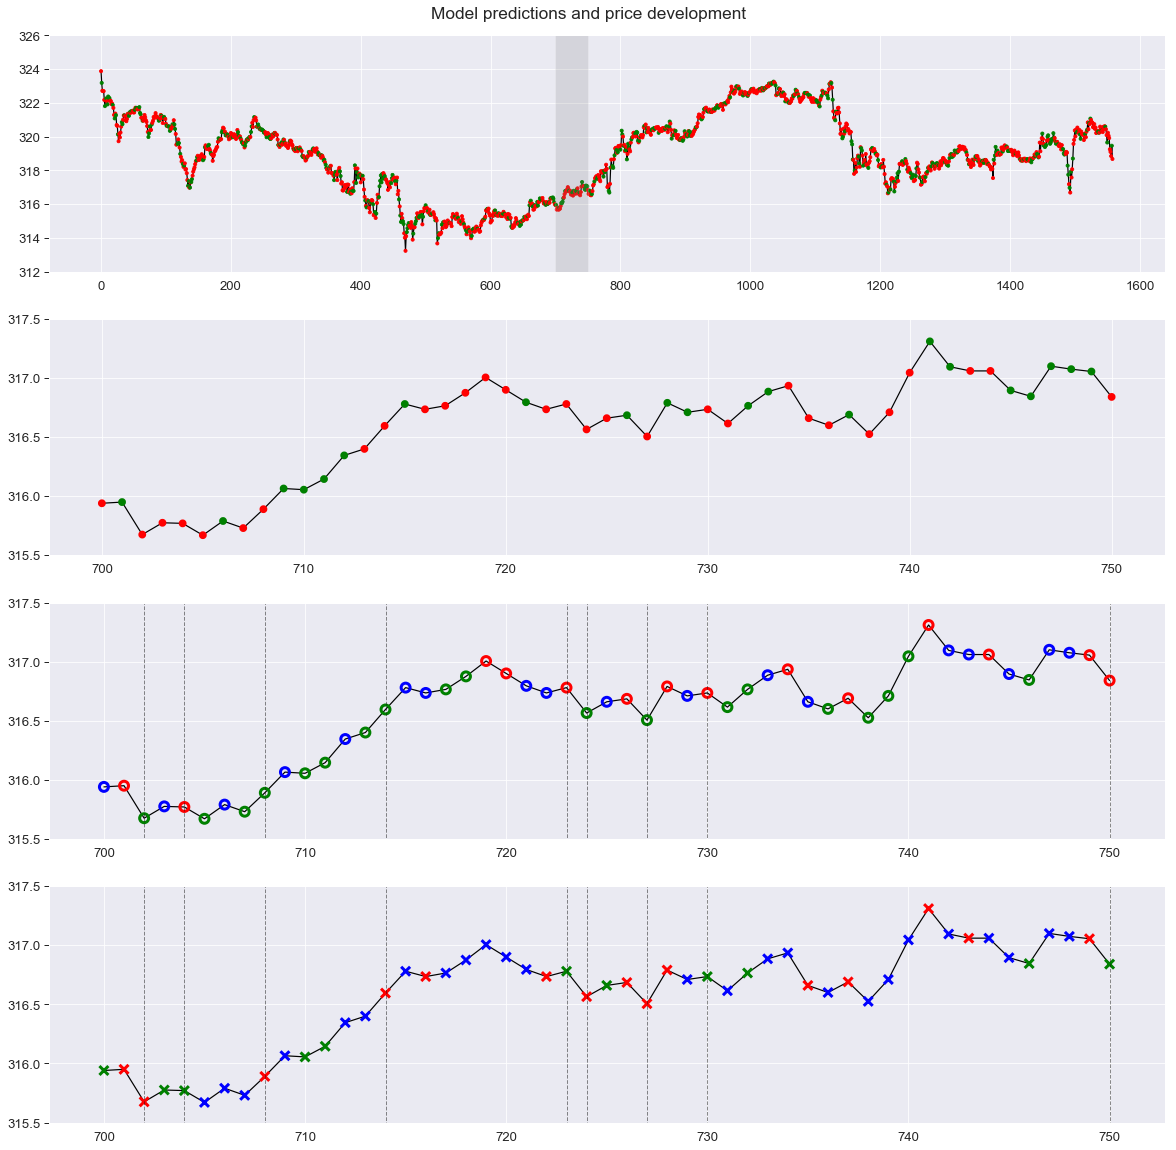

In [505]:
colors = {0:'red',1:'green'}
colors_2 = {0:'red',1:'blue',2:'green'}

zoom_period = [700,750]

fig,ax = plt.subplots(4,1,figsize=(20,20))

################################################ First plot ################################################

ax[0].plot(ticker_close_price.close,color='black')

ax2 = ax[0].twinx()

ax2.axvspan(zoom_period[0],zoom_period[1],
            0,1000,
            facecolor='grey', alpha=0.2)

## Adding the predicted labels
ax2.scatter(x = ticker_close_price.index,
            y=ticker_close_price.loc[:,'close'],
           c=pd.Series(correct_preds).apply(lambda x: colors[x]),marker='o',s=10)

pos = ax[0].get_yticks()
ax[0].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

################################################ Second plot ################################################

ax[1].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

ax2 = ax[1].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=pd.Series(correct_preds[zoom_period[0]:zoom_period[1]+1]).apply(lambda x: colors[x]),
            marker='o',linewidth=3)#,s=80

step = 0.5
np.arange(pos[0],pos[-1]+step,step)

pos = ax[1].get_yticks()
ax[1].set_ylim(pos[0],pos[-1])
ax[1].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

# ################################################ Third plot ################################################

ax[2].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

ax2 = ax[2].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           edgecolors=y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: colors_2[x]),
            marker='o',facecolors='none',s=80,linewidth=3)

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1)
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=0.5)

pos = ax[2].get_yticks()
ax[2].set_ylim(pos[0],pos[-1])
ax[2].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

# ################################################ Fourth plot ################################################

ax[3].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

ax2 = ax[3].twinx()

## Adding the predicted labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).apply(lambda x: colors_2[x]),
            marker='x',s=80,linewidth=3)

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[~booler[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle=':',lw=1)
# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1,facecolor='none',edgecolor='grey')
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=0.5)

pos = ax[3].get_yticks()
ax[3].set_ylim(pos[0],pos[-1])
ax[3].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

fig.suptitle('Model predictions and price development',y=0.9)

plt.show()

# Fourth attempt

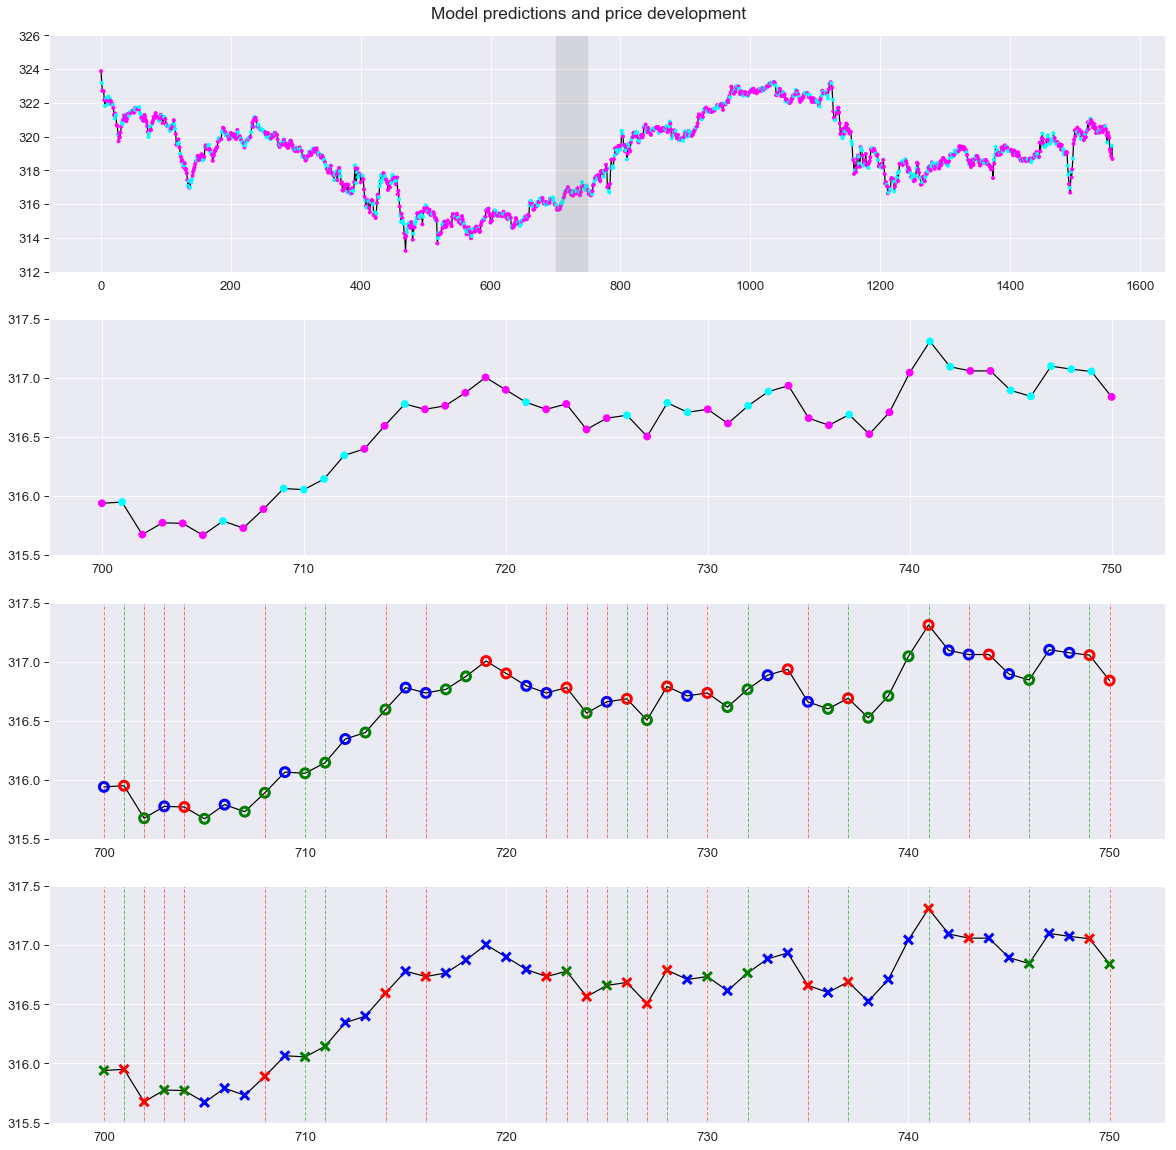

In [514]:
colors = {0:'magenta',1:'cyan'}
colors_2 = {0:'red',1:'blue',2:'green'}

zoom_period = [700,750]

fig,ax = plt.subplots(4,1,figsize=(20,20))

################################################ First plot ################################################

ax[0].plot(ticker_close_price.close,color='black')

ax2 = ax[0].twinx()

ax2.axvspan(zoom_period[0],zoom_period[1],
            0,1000,
            facecolor='grey', alpha=0.2)

## Adding the predicted labels
ax2.scatter(x = ticker_close_price.index,
            y=ticker_close_price.loc[:,'close'],
           c=pd.Series(correct_preds).apply(lambda x: colors[x]),marker='o',s=10)

pos = ax[0].get_yticks()
ax[0].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

################################################ Second plot ################################################

ax[1].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

ax2 = ax[1].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=pd.Series(correct_preds[zoom_period[0]:zoom_period[1]+1]).apply(lambda x: colors[x]),
            marker='o',linewidth=3)#,s=80

step = 0.5
np.arange(pos[0],pos[-1]+step,step)

pos = ax[1].get_yticks()
ax[1].set_ylim(pos[0],pos[-1])
ax[1].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

# ################################################ Third plot ################################################

ax[2].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

ax2 = ax[2].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           edgecolors=y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: colors_2[x]),
            marker='o',facecolors='none',s=80,linewidth=3)

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1)
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=0.5,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=0.5,color='green')

pos = ax[2].get_yticks()
ax[2].set_ylim(pos[0],pos[-1])
ax[2].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

# ################################################ Fourth plot ################################################

ax[3].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color='black')

ax2 = ax[3].twinx()

## Adding the predicted labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).apply(lambda x: colors_2[x]),
            marker='x',s=80,linewidth=3)

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[~booler[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle=':',lw=1)
# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1,facecolor='none',edgecolor='grey')
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=0.5,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=0.5,color='green')

pos = ax[3].get_yticks()
ax[3].set_ylim(pos[0],pos[-1])
ax[3].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])

fig.suptitle('Model predictions and price development',y=0.9)

plt.show()

# Fifth attempt

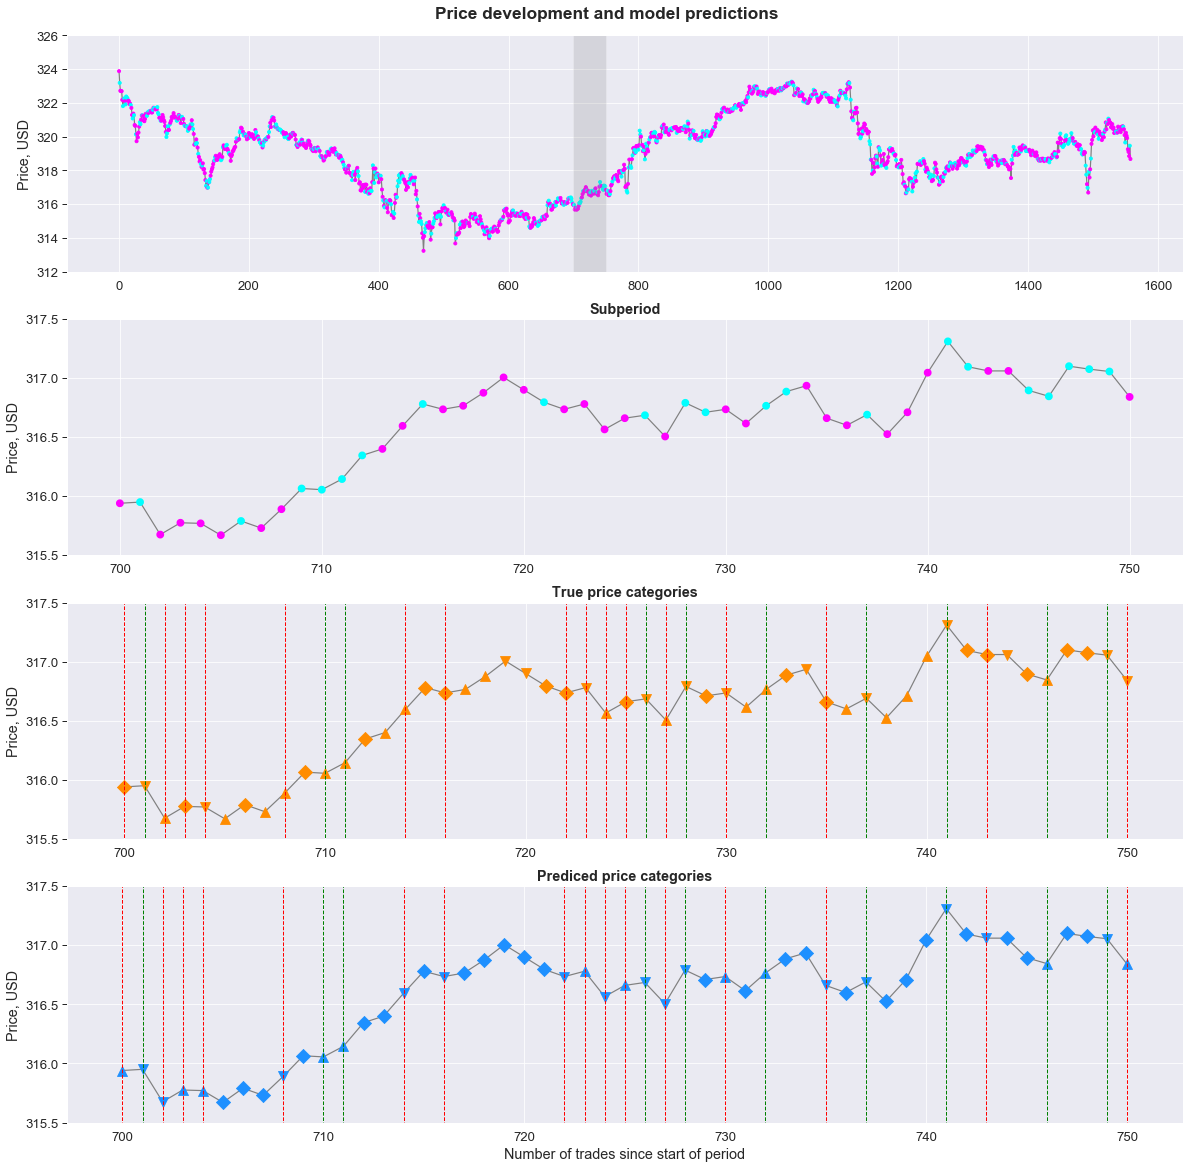

In [541]:
colors = {0:'magenta',1:'cyan'}
# colors_2 = {0:'red',1:'blue',2:'green'}
markers = {0:'v',1:'D',2:'^'}

sns.set_context("paper", font_scale=1.5)

zoom_period = [700,750]

fig,ax = plt.subplots(4,1,figsize=(20,20))
line_color = 'grey'
################################################ First plot ################################################

ax[0].plot(ticker_close_price.close,color=line_color)

ax2 = ax[0].twinx()

ax2.axvspan(zoom_period[0],zoom_period[1],
            0,1000,
            facecolor='grey', alpha=0.2)

## Adding the predicted labels
ax2.scatter(x = ticker_close_price.index,
            y=ticker_close_price.loc[:,'close'],
           c=pd.Series(correct_preds).apply(lambda x: colors[x]),marker='o',s=10)

pos = ax[0].get_yticks()
ax[0].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[0].set_ylabel('Price, USD')

################################################ Second plot ################################################

ax[1].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[1].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=pd.Series(correct_preds[zoom_period[0]:zoom_period[1]+1]).apply(lambda x: colors[x]),
            marker='o',linewidth=3)#,s=80

step = 0.5
np.arange(pos[0],pos[-1]+step,step)

pos = ax[1].get_yticks()
ax[1].set_ylim(pos[0],pos[-1])
ax[1].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[1].set_title('Subperiod',fontweight='bold')
ax[1].set_ylabel('Price, USD')

# ################################################ Third plot ################################################

ax[2].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[2].twinx()

## Adding actual labels
# ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
#             y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
#            edgecolors=y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: colors_2[x]),
#             marker='o',facecolors='none',s=80,linewidth=3)
for c in np.unique(y_test_ticker):
    temp_booler = y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).values==c
    ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1)[temp_booler],
                y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'].values[temp_booler],
               color='darkorange',#dodgerblue
                marker=markers[c],s=100)#y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: markers[x])

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1)
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='green')

pos = ax[2].get_yticks()
ax[2].set_ylim(pos[0],pos[-1])
ax[2].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[2].set_title('True price categories',fontweight='bold')
ax[2].set_ylabel('Price, USD')

# ################################################ Fourth plot ################################################

ax[3].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[3].twinx()

## Adding the predicted labels
# ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
#             y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
#            color=preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).apply(lambda x: colors_2[x]),
#             marker='x',s=80,linewidth=3)
for c in np.unique(preds_ticker.loc[:,'class']):
    temp_booler = preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).values==c
    ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1)[temp_booler],
                y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'].values[temp_booler],
               color='dodgerblue',#darkorange
                marker=markers[c],s=100)

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='green')

pos = ax[3].get_yticks()
ax[3].set_ylim(pos[0],pos[-1])
ax[3].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[3].set_title('Prediced price categories',fontweight='bold')
ax[3].set_xlabel('Number of trades since start of period')
ax[3].set_ylabel('Price, USD')

fig.suptitle('Price development and model predictions',y=0.9,fontweight='bold')


plt.show()

# Sixth Attempt

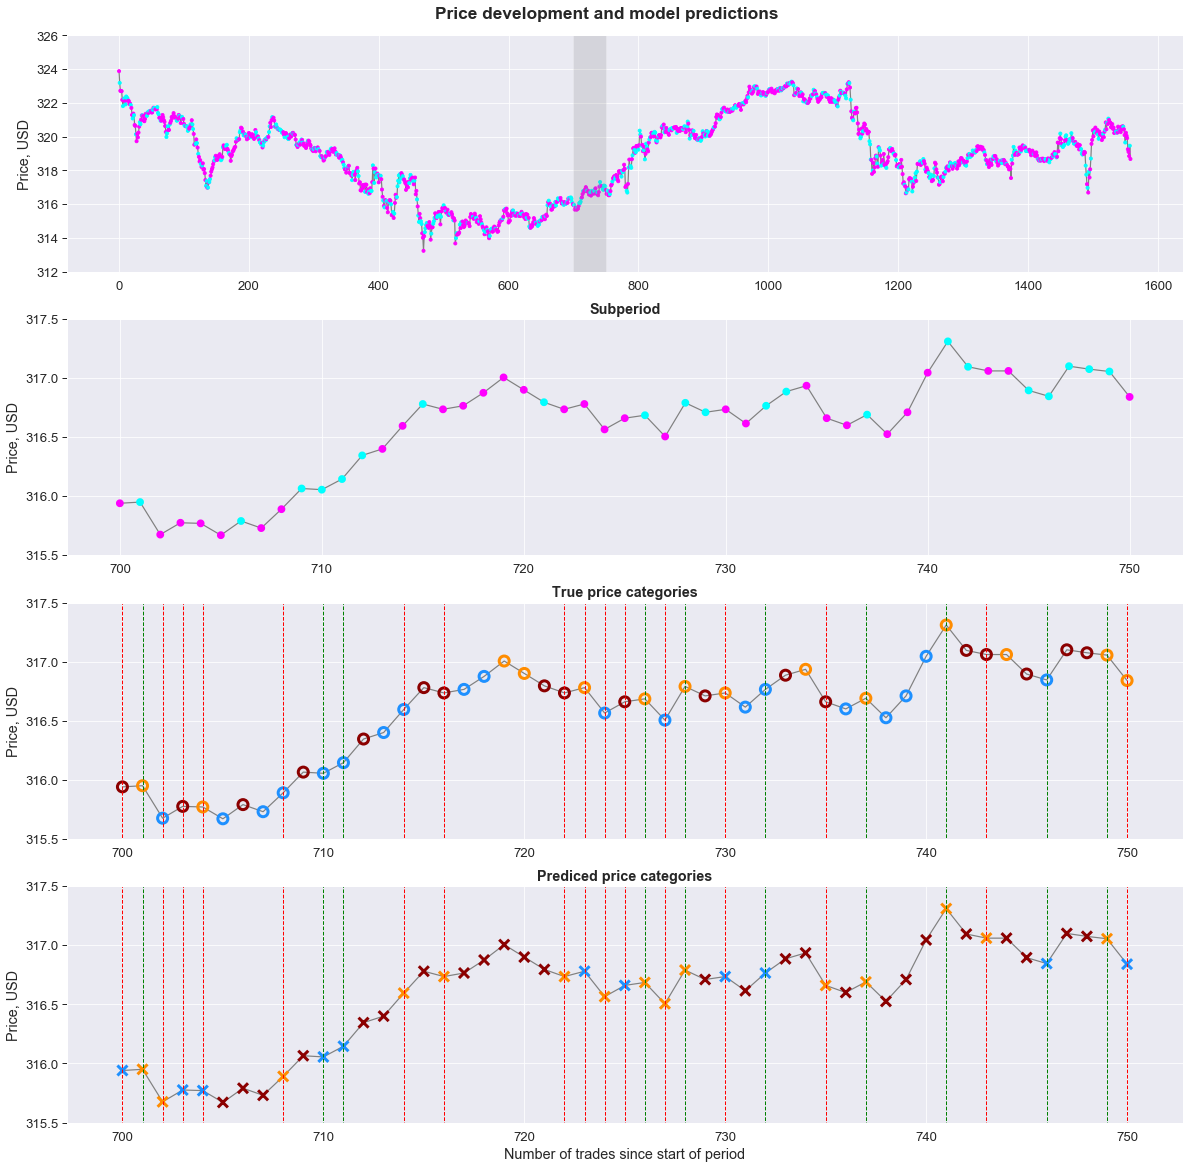

In [540]:
colors = {0:'magenta',1:'cyan'}
colors_2 = {0:'darkorange',1:'darkred',2:'dodgerblue'}
line_color = 'grey'

sns.set_context("paper", font_scale=1.5)

zoom_period = [700,750]

fig,ax = plt.subplots(4,1,figsize=(20,20))

################################################ First plot ################################################

ax[0].plot(ticker_close_price.close,color=line_color)

ax2 = ax[0].twinx()

ax2.axvspan(zoom_period[0],zoom_period[1],
            0,1000,
            facecolor='grey', alpha=0.2)

## Adding the predicted labels
ax2.scatter(x = ticker_close_price.index,
            y=ticker_close_price.loc[:,'close'],
           c=pd.Series(correct_preds).apply(lambda x: colors[x]),marker='o',s=10)

pos = ax[0].get_yticks()
ax[0].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[0].set_ylabel('Price, USD')

################################################ Second plot ################################################

ax[1].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[1].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=pd.Series(correct_preds[zoom_period[0]:zoom_period[1]+1]).apply(lambda x: colors[x]),
            marker='o',linewidth=3)#,s=80

step = 0.5
np.arange(pos[0],pos[-1]+step,step)

pos = ax[1].get_yticks()
ax[1].set_ylim(pos[0],pos[-1])
ax[1].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[1].set_title('Subperiod',fontweight='bold')
ax[1].set_ylabel('Price, USD')

# ################################################ Third plot ################################################

ax[2].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[2].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           edgecolors=y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: colors_2[x]),
            marker='o',facecolors='none',s=100,linewidth=3)

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1)
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='green')

pos = ax[2].get_yticks()
ax[2].set_ylim(pos[0],pos[-1])
ax[2].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[2].set_title('True price categories',fontweight='bold')
ax[2].set_ylabel('Price, USD')

# ################################################ Fourth plot ################################################

ax[3].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[3].twinx()

## Adding the predicted labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).apply(lambda x: colors_2[x]),
            marker='x',s=100,linewidth=3)

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[~booler[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle=':',lw=1)
# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1,facecolor='none',edgecolor='grey')
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='green')

pos = ax[3].get_yticks()
ax[3].set_ylim(pos[0],pos[-1])
ax[3].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[3].set_title('Prediced price categories',fontweight='bold')
ax[3].set_xlabel('Number of trades since start of period')
ax[3].set_ylabel('Price, USD')

fig.suptitle('Price development and model predictions',y=0.9,fontweight='bold')

plt.show()

# Seventh attempt - fifth attempt with conditional alpha

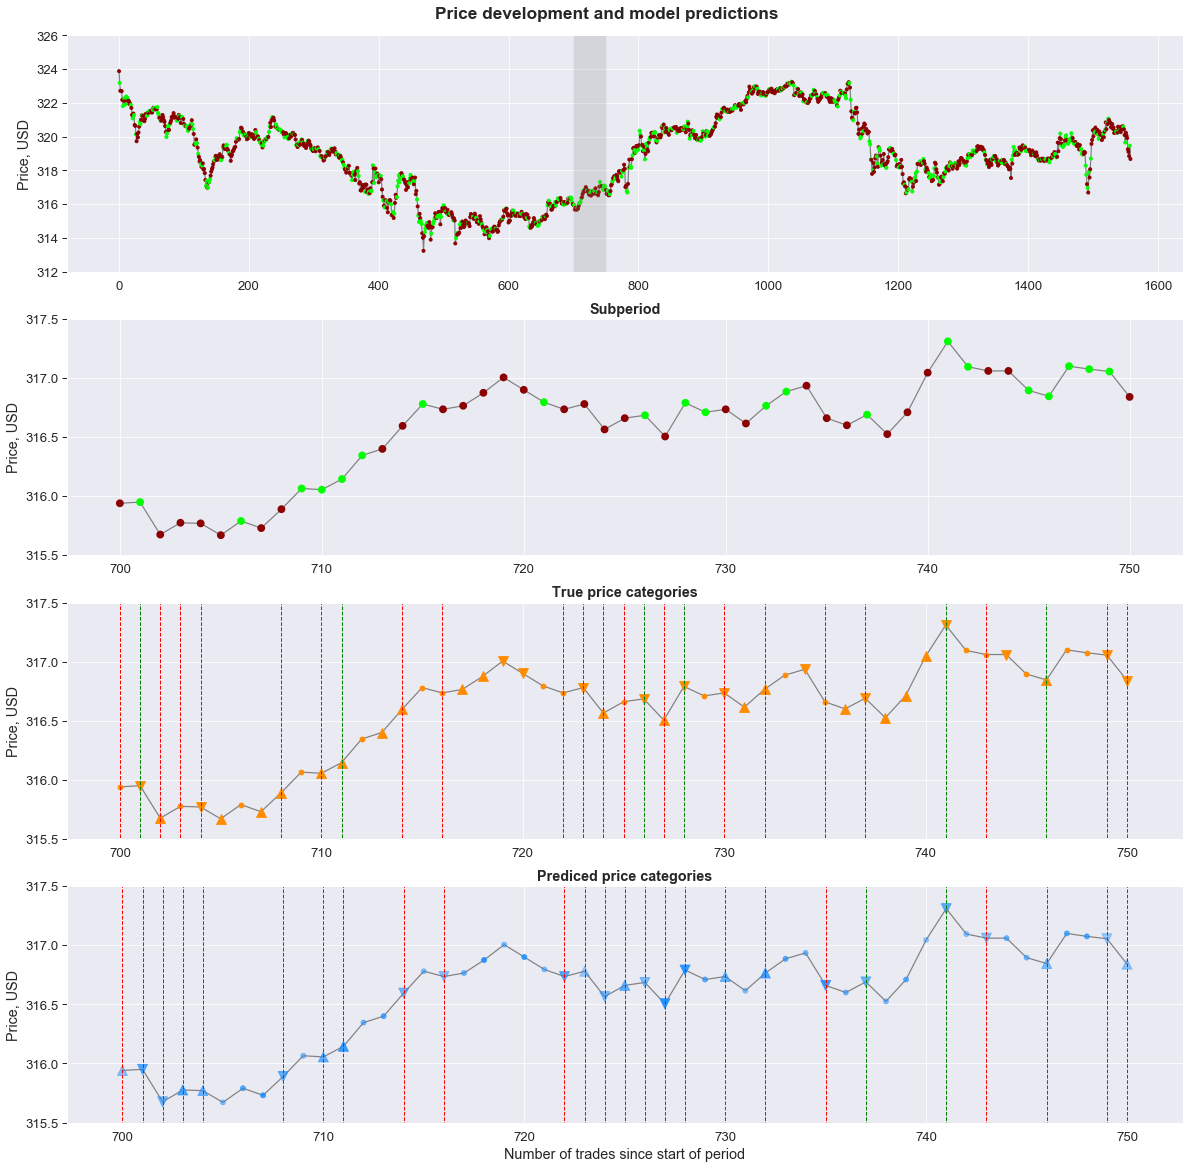

In [608]:
colors = {0:'darkred',1:'lime'}
# colors_2 = {0:'red',1:'blue',2:'green'}
markers = {0:'v',1:'.',2:'^'}

## Dodgeblue: rgb(30,144,255)

conditional_alpha = np.zeros((preds_ticker.shape[0],4))
conditional_alpha[:,0] = 30/255
conditional_alpha[:,1] = 144/255
conditional_alpha[:,2] = 255/255
conditional_alpha[:,3] = preds_ticker.loc[:,'confidence']

sns.set_context("paper", font_scale=1.5)

zoom_period = [700,750]

fig,ax = plt.subplots(4,1,figsize=(20,20))
line_color = 'grey'
################################################ First plot ################################################

ax[0].plot(ticker_close_price.close,color=line_color)

ax2 = ax[0].twinx()

ax2.axvspan(zoom_period[0],zoom_period[1],
            0,1000,
            facecolor='grey', alpha=0.2)

## Adding the predicted labels
ax2.scatter(x = ticker_close_price.index,
            y=ticker_close_price.loc[:,'close'],
           c=pd.Series(correct_preds).apply(lambda x: colors[x]),marker='o',s=10)

pos = ax[0].get_yticks()
ax[0].set_ylim(pos[0],pos[-1])
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[0].set_ylabel('Price, USD')

################################################ Second plot ################################################

ax[1].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[1].twinx()

## Adding actual labels
ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
            y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
           color=pd.Series(correct_preds[zoom_period[0]:zoom_period[1]+1]).apply(lambda x: colors[x]),
            marker='o',linewidth=3)#,s=80

step = 0.5
np.arange(pos[0],pos[-1]+step,step)

pos = ax[1].get_yticks()
ax[1].set_ylim(pos[0],pos[-1])
ax[1].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[1].set_title('Subperiod',fontweight='bold')
ax[1].set_ylabel('Price, USD')

# ################################################ Third plot ################################################

ax[2].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[2].twinx()

## Adding actual labels
# ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
#             y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
#            edgecolors=y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: colors_2[x]),
#             marker='o',facecolors='none',s=80,linewidth=3)
for c in np.unique(y_test_ticker):
    temp_booler = y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).values==c
    ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1)[temp_booler],
                y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'].values[temp_booler],
               color='darkorange',#dodgerblue
                marker=markers[c],s=100)#y_test_ticker.loc[zoom_period[0]:zoom_period[1],0].astype(int).apply(lambda x: markers[x])

# ax2.bar(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],500,
#         width=0.1,linestyle='-.',lw=1)
ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='green')

pos = ax[2].get_yticks()
ax[2].set_ylim(pos[0],pos[-1])
ax[2].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[2].set_title('True price categories',fontweight='bold')
ax[2].set_ylabel('Price, USD')

# ################################################ Fourth plot ################################################

ax[3].plot(ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],color=line_color)

ax2 = ax[3].twinx()

## Adding the predicted labels
# ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1),
#             y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'],
#            color=preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).apply(lambda x: colors_2[x]),
#             marker='x',s=80,linewidth=3)
for c in np.unique(preds_ticker.loc[:,'class']):
    temp_booler = preds_ticker.loc[zoom_period[0]:zoom_period[1],'class'].astype(int).values==c
    ax2.scatter(x = np.arange(zoom_period[0],zoom_period[1]+1)[temp_booler],
                y=ticker_close_price.loc[zoom_period[0]:zoom_period[1],'close'].values[temp_booler],
               c=conditional_alpha[zoom_period[0]:zoom_period[1]+1][temp_booler],#'dodgerblue',#darkorange
                marker=markers[c],s=100)

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_od[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='red')

ax2.vlines(np.arange(zoom_period[0],zoom_period[1]+1)[booler_sd[zoom_period[0]:zoom_period[1]+1]],0,500,
        linestyle='--',lw=1,alpha=1,color='green')

pos = ax[3].get_yticks()
ax[3].set_ylim(pos[0],pos[-1])
ax[3].set_yticks(np.arange(pos[0],pos[-1]+step,step))
ax2.set_ylim(pos[0],pos[-1])
ax2.set_yticks([])
ax[3].set_title('Prediced price categories',fontweight='bold')
ax[3].set_xlabel('Number of trades since start of period')
ax[3].set_ylabel('Price, USD')

fig.suptitle('Price development and model predictions',y=0.9,fontweight='bold')


plt.show()

In [547]:
preds_ticker.loc[:,'confidence'] = preds_ticker.iloc[:,0:n_classes].max(axis=1)

In [548]:
preds_ticker

0         1         2  class  confidence
0     0.210943  0.485779  0.303278      1    0.485779
1     0.999916  0.000077  0.000006      0    0.999916
2     0.989551  0.008264  0.002185      0    0.989551
3     0.132461  0.313910  0.553629      2    0.553629
4     0.341063  0.005577  0.653360      2    0.653360
...        ...       ...       ...    ...         ...
1554  0.059957  0.459151  0.480892      2    0.480892
1555  0.302475  0.244609  0.452916      2    0.452916
1556  0.183098  0.589710  0.227192      1    0.589710
1557  0.952216  0.037436  0.010348      0    0.952216
1558  0.335245  0.473994  0.190761      1    0.473994

[1559 rows x 5 columns]

# Aggregated level

In [562]:
y_test.shape[0]/55

1559.0

In [564]:
y_test.shape[0]

85745

In [566]:
preds

0         1         2  class  confidence
0      0.210943  0.485779  0.303278      1    0.485779
1      0.169946  0.502319  0.327735      1    0.502319
2      0.347786  0.382853  0.269361      1    0.382853
3      0.177971  0.570690  0.251339      1    0.570690
4      0.054643  0.503562  0.441796      1    0.503562
...         ...       ...       ...    ...         ...
85740  0.399605  0.160099  0.440296      2    0.399605
85741  0.123252  0.142007  0.734741      2    0.142007
85742  0.003124  0.065805  0.931071      2    0.065805
85743  0.004081  0.027036  0.968883      2    0.027036
85744  0.246307  0.246774  0.506919      2    0.246774

[85745 rows x 5 columns]

In [570]:
share_of_correct_preds = []

i_prev = 0

for i in np.arange(55,y_test.shape[0]+55,55):
    
    share_of_correct_preds.append(sum(np.equal(y_test.loc[i_prev:i,0].values,preds.loc[i_prev:i,'class'].values))/55)
    
    i_prev = i

In [571]:
len(share_of_correct_preds)

1559

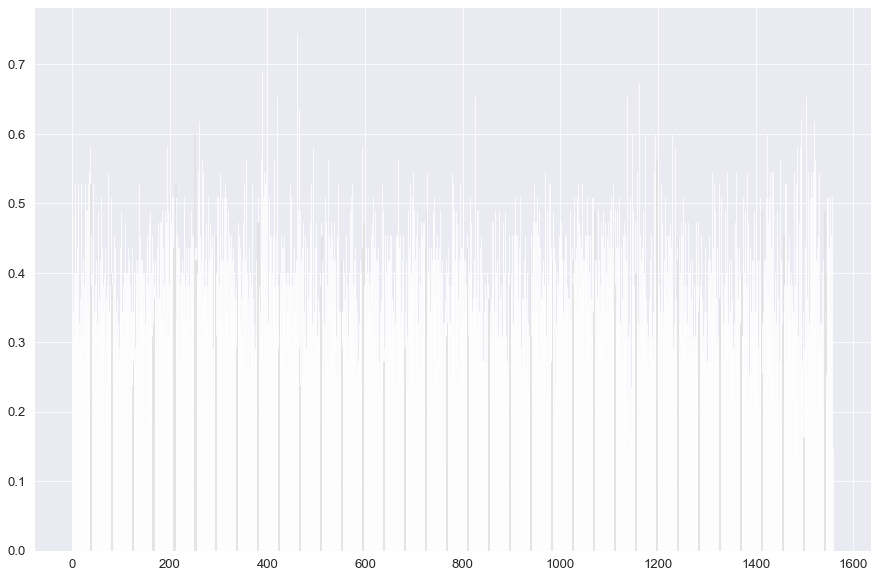

In [585]:
plt.figure(figsize=(15,10))
plt.bar(np.arange(len(share_of_correct_preds)),
        share_of_correct_preds,
        color='black',fill='blue',width=0.1)
# sns.barplot(x = np.arange(len(share_of_correct_preds)),y = share_of_correct_preds,color='blue',fill='blue')
plt.show()

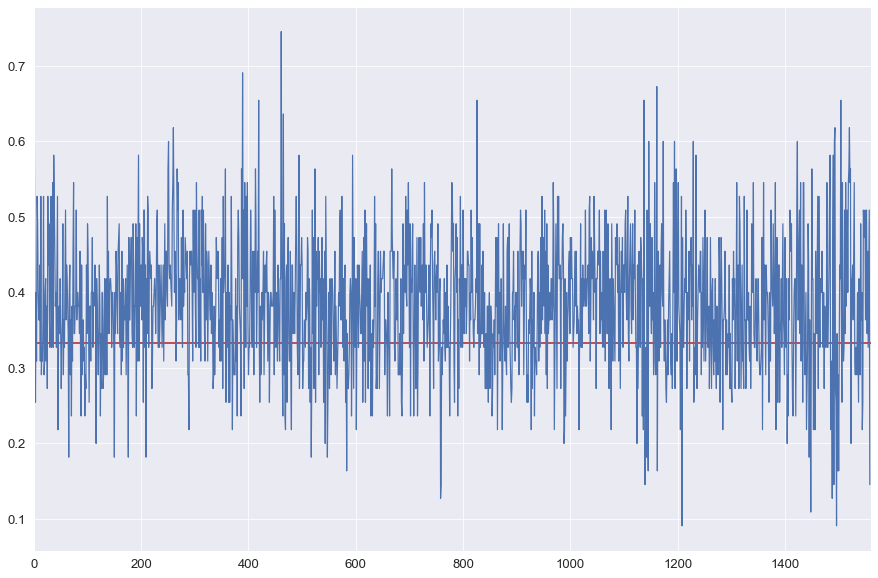

In [609]:
plt.figure(figsize=(15,10))
plt.hlines(1/n_classes,0,1600,color='r',lw=2)
plt.plot(share_of_correct_preds,
#         color='black',fill='blue',width=0.1
        )
plt.xlim(0,1560)
# sns.barplot(x = np.arange(len(share_of_correct_preds)),y = share_of_correct_preds,color='blue',fill='blue')
plt.show()

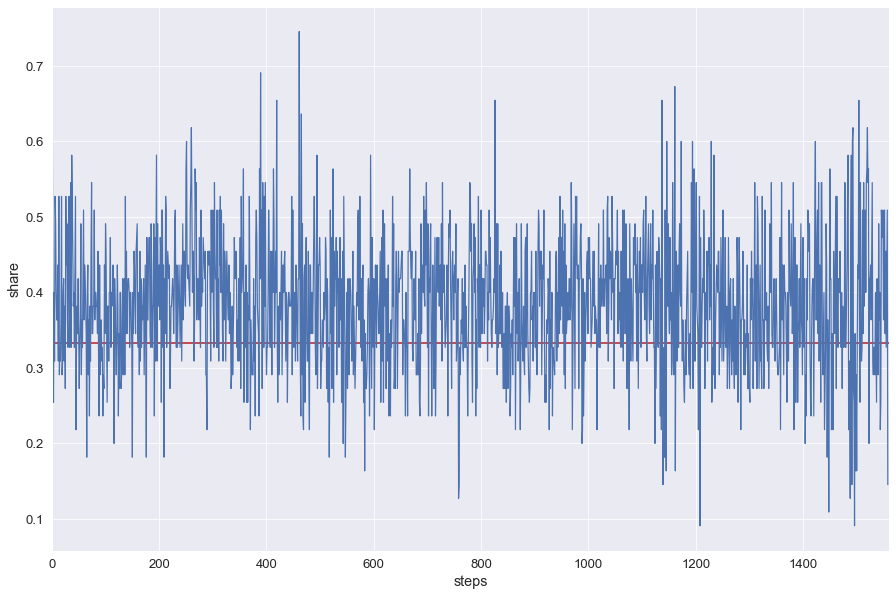

In [621]:
# sns.lineplot(x="timepoint", y="signal",
#              hue="region", style="event",
#              data=fmri)
plt.figure(figsize=(15,10))
plt.hlines(1/n_classes,0,1600,color='r',lw=2)
# plt.plot(share_of_correct_preds,
# #         color='black',fill='blue',width=0.1
#         )
sns.lineplot(x='steps', y="share",ci='sd',
#              style="stim",
             data=pd.DataFrame({'share':share_of_correct_preds,'steps':np.arange(len(share_of_correct_preds))}))
plt.xlim(0,1560)
# sns.barplot(x = np.arange(len(share_of_correct_preds)),y = share_of_correct_preds,color='blue',fill='blue')
plt.show()

In [625]:
combined_table_lr[combined_table_lr.loc[:,'label-type']=='1']

run_id batch-shuffle batch-size  \
731  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_215             1       3300   
346  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_601             0       3300   
77   HD_cd9ee539-71c9-4336-abd1-d57be726ee53_871             0      10725   
15   HD_cd9ee539-71c9-4336-abd1-d57be726ee53_933             1      21450   
871   HD_cd9ee539-71c9-4336-abd1-d57be726ee53_75             1      21450   
..                                           ...           ...        ...   
422  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_524             0      10725   
363  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_583             0      21450   
928   HD_cd9ee539-71c9-4336-abd1-d57be726ee53_19             0       3300   
294  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_651             0      10725   
265  HD_cd9ee539-71c9-4336-abd1-d57be726ee53_681             1       3300   

    feature-lags featureset   l2-penalty l2-type label-type learning-rate  \
731            1          2       0.0001       5          1         0.001   
346            1          2       0.0001       0          1         0.001   
77             3          0  10000000000       0          1         0.001   
15             0          3         1000       0          1         0.001   
871            1          3       0.0001       4          1          0.01   
..           ...        ...          ...     ...        ...           ...   
422            0          2         0.01       4          1        0.0001   
363            5          0          100       0          1         0.001   
928            1          2            1       0          1          0.01   
294            1          3          100       0          1          0.01   
265            0          1          0.1       2          1         0.001   

    loss-from-logits n-epochs pastobs-in-percentage pre-processing  \
731                0      150                     0        stacked   
346                0      150                     0            pow   
77                 0      150                     0            pow   
15                 0      150                     1       quantgau   
871                0      150                     0            std   
..               ...      ...                   ...            ...   
422                1      150                     1         minmax   
363                1      150                     0         minmax   
928                1      150                     1       quantgau   
294                1      150                     1         minmax   
265                1      150                     0         minmax   

                   id       AUC  Accuracy      Loss  Train AUC  \
731  d57be726ee53_215  0.614858  0.428229  1.084257   0.614847   
346  d57be726ee53_601  0.613977  0.429199  1.053789   0.613960   
77   d57be726ee53_871  0.607980  0.424591  2.045013   0.607961   
15   d57be726ee53_933  0.605788  0.432893  1.051603   0.605735   
871   d57be726ee53_75  0.604643  0.414105  1.068349   0.604640   
..                ...       ...       ...       ...        ...   
422  d57be726ee53_524  0.051673  0.383311  1.096505   0.051648   
363  d57be726ee53_583  0.049979  0.398386  1.072164   0.049958   
928   d57be726ee53_19  0.016247  0.425132  1.056311   0.016245   
294  d57be726ee53_651  0.011383  0.408051  1.071695   0.011374   
265  d57be726ee53_681  0.008479  0.341462  1.098366   0.008473   

     Train Accuracy  Train Loss  
731        0.423406    1.085161  
346        0.423725    1.056414  
77         0.420847   17.598856  
15         0.426740    1.054513  
871        0.417632    1.063685  
..              ...         ...  
422        0.386722    1.095382  
363        0.401813    1.068874  
928        0.412414    1.065845  
294        0.395270    1.077760  
265        0.356619    1.097501  

[179 rows x 20 columns]

In [27]:
np.random.randint(0,10,3)

array([7, 9, 8])

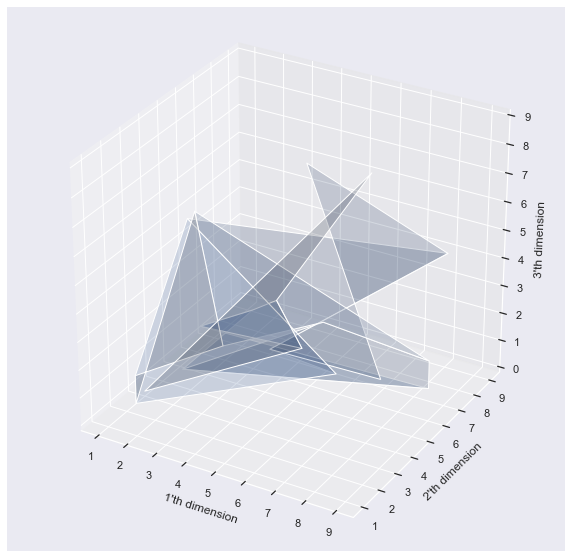

In [37]:
# df = pd.read_csv('2016.csv')
# sns.set(style = "darkgrid")

points = 10

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = np.random.randint(0,10,(points,2))#df['Happiness Score']
y = np.random.randint(0,10,(points,2))#df['Economy (GDP per Capita)']
z = np.random.randint(0,10,(points,2))#df['Health (Life Expectancy)']

ax.set_xlabel("1'th dimension")
ax.set_ylabel("2'th dimension")
ax.set_zlabel("3'th dimension")

# ax.scatter(x, y, z)
# ax.plot(x, y, z,marker = '.')
ax.plot_surface(x, y, z, alpha=0.2)

plt.show()

## Pre-processing

In [ ]:
{i:colname for i,colname in enumerate(train_ds.columns)}

In [ ]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing(X_train,X_test,ppdict)

In [ ]:
ppX_train.iloc[:,0].mean(),ppX_train.iloc[:,0].std()

## Prepping for models

In [ ]:
N_VALIDATION = val_y.shape[0] #int(1e3)
N_TRAIN = train_y.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

## A Logistic Regression model in TF/Keras

In [ ]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1,
                       input_shape=(FEATURES,),
                       activation='sigmoid',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=0) #(val_features, val_labels))

In [ ]:
model.evaluate(validate_ds,  val_y, verbose=2)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs